In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dateutil.parser import parse
import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import r2_score

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Raw Data has Date and Time as dindivual columns only

In [10]:
# Combine Date and Time colummns into a single column 
#df_2018['datetime'] = df_2018['Date'] + ' ' + df_2018['Time'] 
#df_2017['datetime'] = df_2017['Date'] + ' ' + df_2017['Time'] 
#df_2016['datetime'] = df_2016['Date'] + ' ' + df_2016['Time'] 
#df_2015['datetime'] = df_2015['Date'] + ' ' + df_2015['Time'] 
#df_2014['datetime'] = df_2014['Date'] + ' ' + df_2014['Time'] 

In [13]:
# Save each yearly turnstile df to csv with Date and Time combined to datetime
# to allow loading as dtype when reading csv.    
#df_2018.to_csv('df_2018.csv')
#df_2017.to_csv('df_2017.csv')
#df_2016.to_csv('df_2016.csv')
#df_2015.to_csv('df_2015.csv')
#df_2014.to_csv('df_2014.csv')

### A Reminder of Time Wasted
Unfortunetly I ran the below code to change 46 million items to a date time object. 

In [6]:
# convert datetime filed from dtype object to dtype datetime - this took hours to run
#df_2018['datetime'] = pd.to_datetime(df_2018['datetime'])
#df_2017['datetime'] = pd.to_datetime(df_2017['datetime'])
#df_2016['datetime'] = pd.to_datetime(df_2016['datetime'])
#df_2015['datetime'] = pd.to_datetime(df_2015['datetime'])
#df_2014['datetime'] = pd.to_datetime(df_2014['datetime'])

#### Load Turnstile data with datetime column added so it can be read as a datetime object

In [3]:
df_2018 = pd.read_csv('./df_2018.csv',
                      dtype={"C/A": object, "Unit" : object, "SCP" : object, "Station" : object,
                             "Line Name" : object, "Division" : object, "Description" : object,
                            "Entries" : int, "Exits" : int}, parse_dates=['datetime'])
df_2017 = pd.read_csv('./df_2017.csv',
                      dtype={"C/A": object, "Unit" : object, "SCP" : object, "Station" : object,
                             "Line Name" : object, "Division" : object, "Description" : object,
                            "Entries" : int, "Exits" : int},  parse_dates=['datetime'])
df_2016 = pd.read_csv('./df_2016.csv',
                      dtype={"C/A": object, "Unit" : object, "SCP" : object, "Station" : object,
                             "Line Name" : object, "Division" : object, "Description" : object,
                            "Entries" : int, "Exits" : int}, parse_dates=['datetime'])
df_2015 = pd.read_csv('./df_2015.csv',
                      dtype={"C/A": object, "Unit" : object, "SCP" : object, "Station" : object,
                             "Line Name" : object, "Division" : object, "Description" : object,
                            "Entries" : int, "Exits" : int}, parse_dates=['datetime'])
df_2014 = pd.read_csv('./df_2014.csv',
                      dtype={"C/A": object, "Unit" : object, "SCP" : object, "Station" : object,
                             "Line Name" : object, "Division" : object, "Description" : object,
                            "Entries" : int, "Exits" : int}, parse_dates=['datetime'])

In [4]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7312716 entries, 0 to 7312715
Data columns (total 13 columns):
Unnamed: 0                                                    int64
C/A                                                           object
Unit                                                          object
SCP                                                           object
Station                                                       object
Line Name                                                     object
Division                                                      object
Date                                                          object
Time                                                          object
Description                                                   object
Entries                                                       int32
Exits                                                         int64
datetime                                                      

In [9]:
# Remove spaces from columns of all 5 yearly frames
frames = [df_2014, df_2015, df_2016, df_2017, df_2018]

for frame in frames:
    frame.columns = frame.columns.str.replace(' ', '')

In [12]:
# Add a column to each yearly frame to indicate the year it is from
df_2018['Year'] = 2018
df_2017['Year'] = 2017
df_2016['Year'] = 2016
df_2015['Year'] = 2015
df_2014['Year'] = 2014

In [11]:
# Combine the yearly frames into a single dataframe
df = pd.concat(frames)

In [13]:
# Examine the shape of the combined dataframe
df.shape

(46431490, 14)

### Create New DataFrame with Daily Counts for Entrances, Exits and total Traffic.  

In [15]:
# Reset the index of the combined dataframe
df.reset_index(inplace=True)

# Drop the erroneous columns
df.drop(columns=['index', 'Unnamed:0'], inplace=True)

# Crate a column labeling each row with a numeric code for the day of the week
df['weekday'] = df['datetime'].dt.dayofweek

# Sort by Station Unit number, booth, turnstile indetification and then datetime.
df.sort_values(['Unit','C/A','SCP','datetime'], inplace=True)

# Create columns to show number of entries and exists
df['Hourly_Entries'] = df['Entries'].diff()
df['Hourly_Exits'] = df['Exits'].diff()

hourly = ['Hourly_Entries', 'Hourly_Exits']

#set all negative hourly entries to absolute value
for item in hourly:
    df.loc[df[item] < 0, item] = abs(df[item])
    df[df[item] < 0]
    
df['traffic'] = df[hourly].sum(axis=1)

# Create a colume to filter out rows which are showing a full week+ of data
df['valid'] = df['traffic'] <= 10000

# Create a mask to filter out weekly turnstile traffic
mask_not_valid = df['valid'] == False 
mask_valid = df['valid'] == True 

# Create a new dataframe containing only valid turnstile data. 
df_sum_traffic = pd.DataFrame(df[mask_valid].groupby(['Unit','C/A','SCP','Date','weekday'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())

df_sum_traffic.reset_index(inplace=True)

## Full System by Turnstile

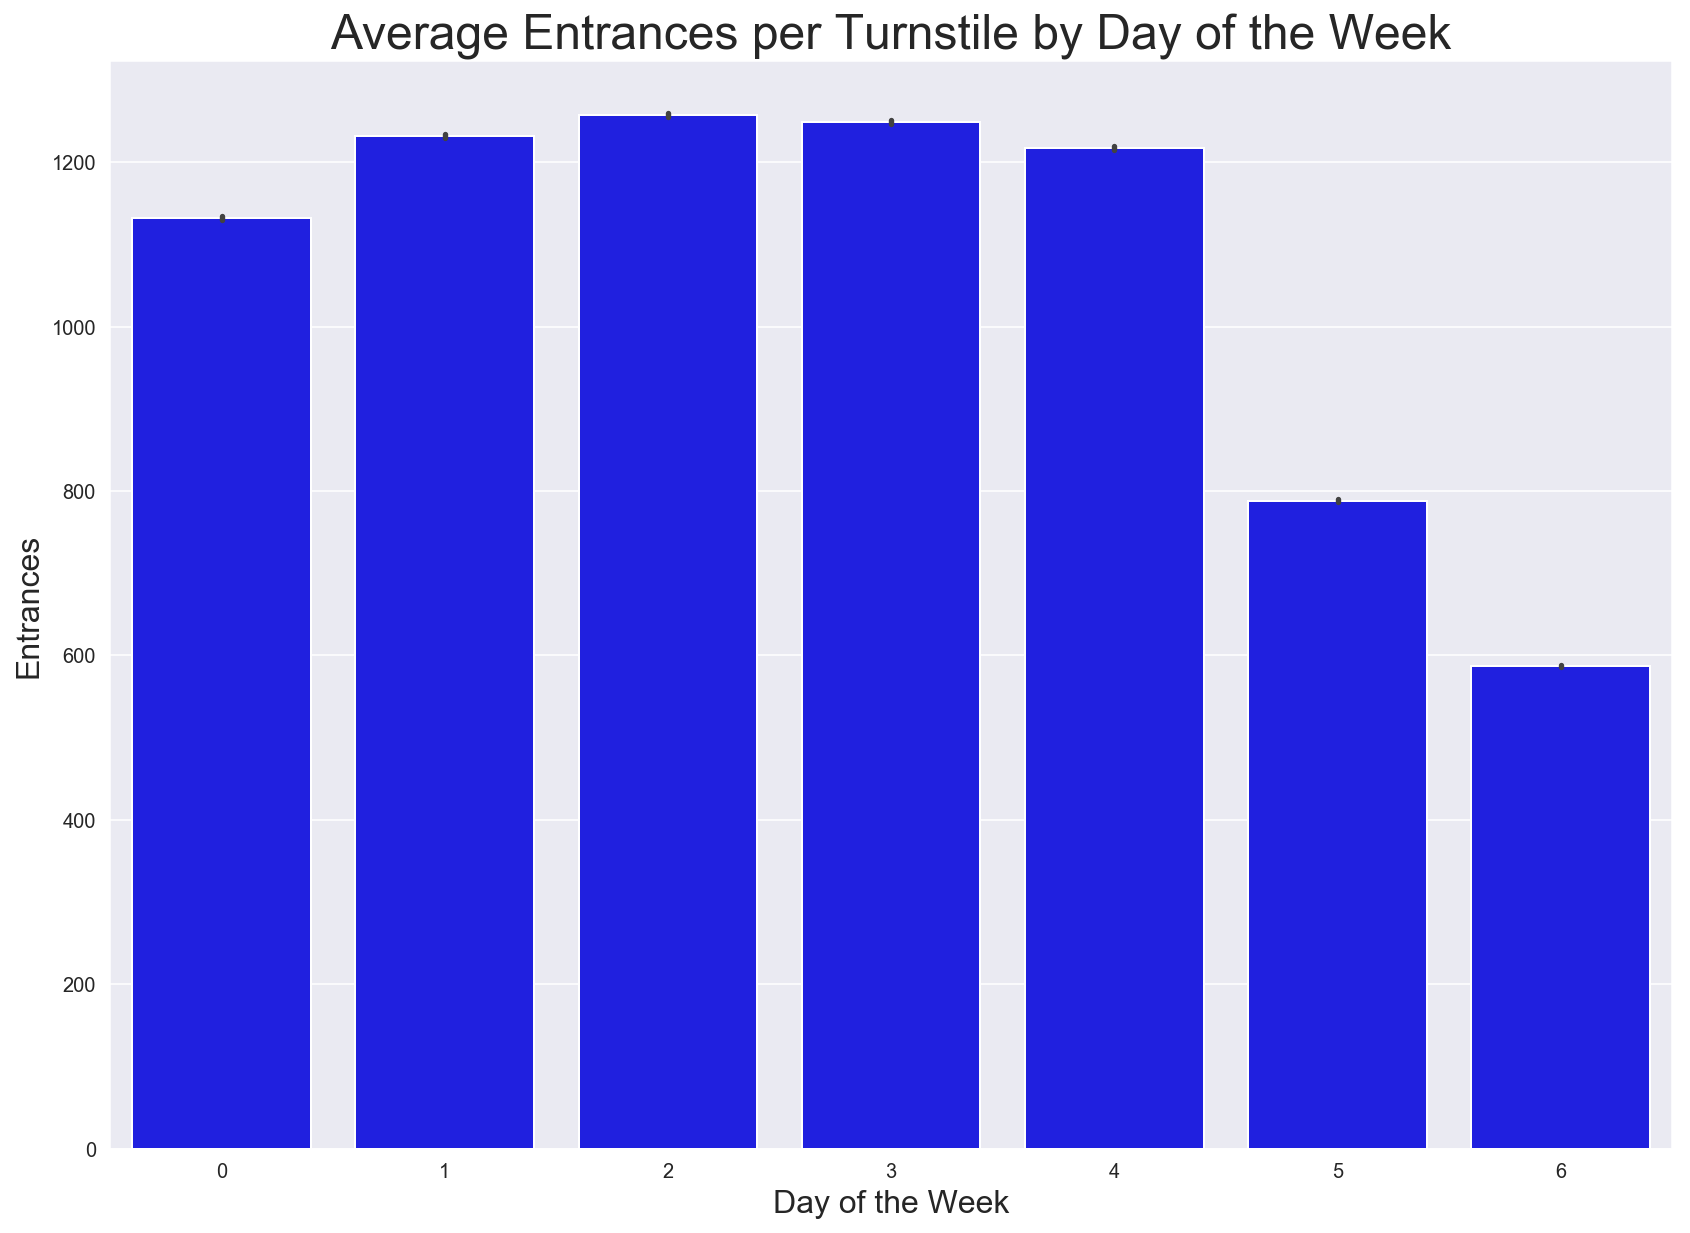

In [17]:
plt.figure(figsize=(14,10))
sns.barplot(x=df_sum_traffic.weekday, y=df_sum_traffic.Hourly_Entries, color='b');
plt.title('Average Entrances per Turnstile by Day of the Week', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Day of the Week', fontsize=16);

## Full System by Date

In [18]:
# Create a dataframe grouping ridership by date
df_daily_traffic = pd.DataFrame(df[mask_valid].groupby(['Date','weekday'])['traffic','Hourly_Entries', 'Hourly_Exits'].sum())

In [21]:
df_daily_traffic.reset_index(inplace=True)

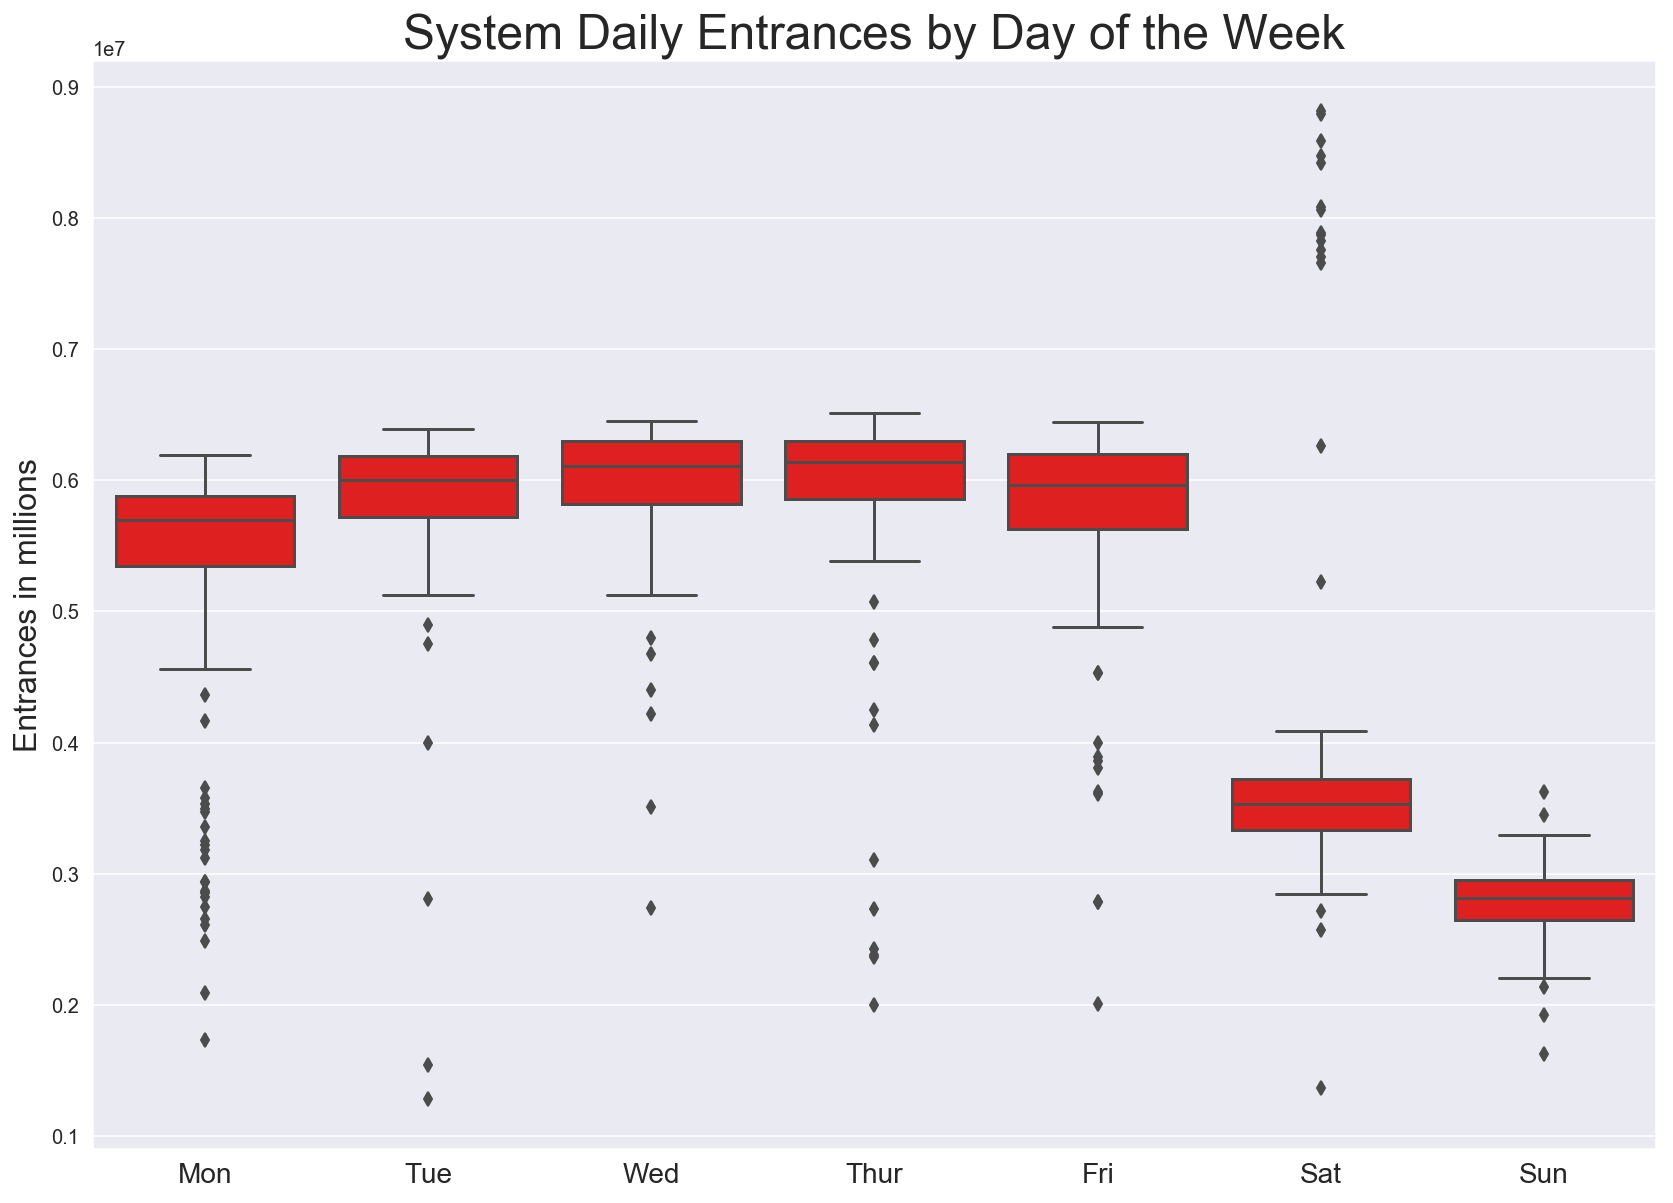

In [47]:
plt.figure(figsize=(14,10))
sns.boxplot(x=df_daily_traffic.weekday, y=df_daily_traffic.Hourly_Entries, color='r');
plt.title('System Daily Entrances by Day of the Week', fontsize=24);
plt.ylabel('Entrances in millions', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], fontsize=14);

In [24]:
# Set 'Date' column to datetime then sort by Date and set as index
df_daily_traffic['Date'] = pd.to_datetime(df_daily_traffic['Date'])
df_daily_traffic.sort_values(['Date'], inplace=True)
df_daily_traffic.set_index('Date', inplace=True)

### Full System Autocorrelation 
There are distincet weekly patterns in the data. 

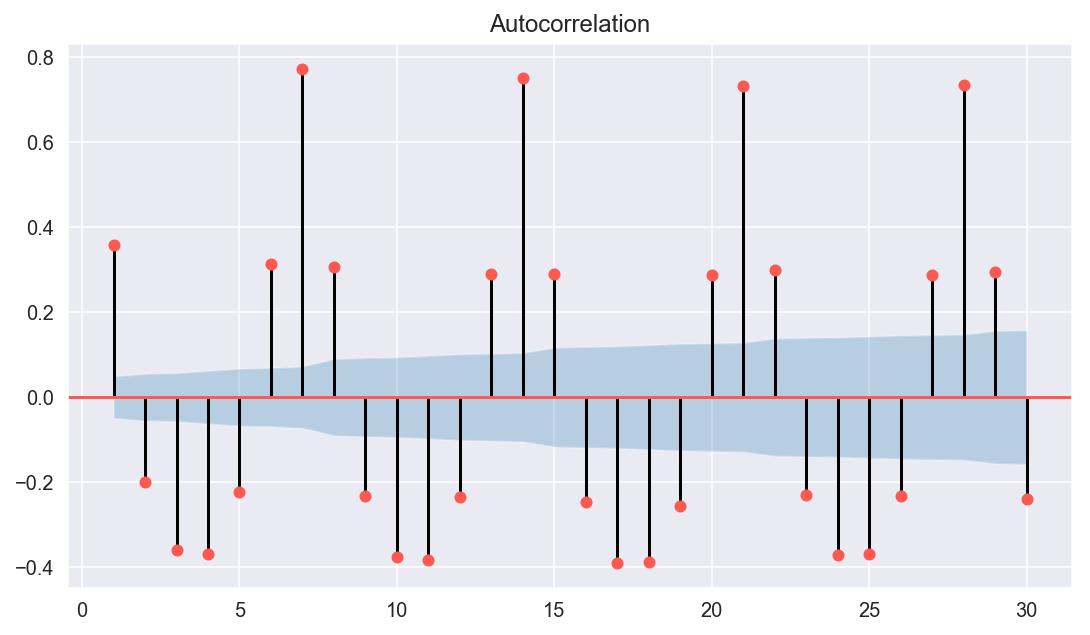

In [28]:
fig, ax = plt.subplots(figsize = (9, 5))
plot_acf(df_daily_traffic['Hourly_Entries'], lags = 30, ax = ax, color=sns.xkcd_rgb["coral"], zero=False)
plt.show();

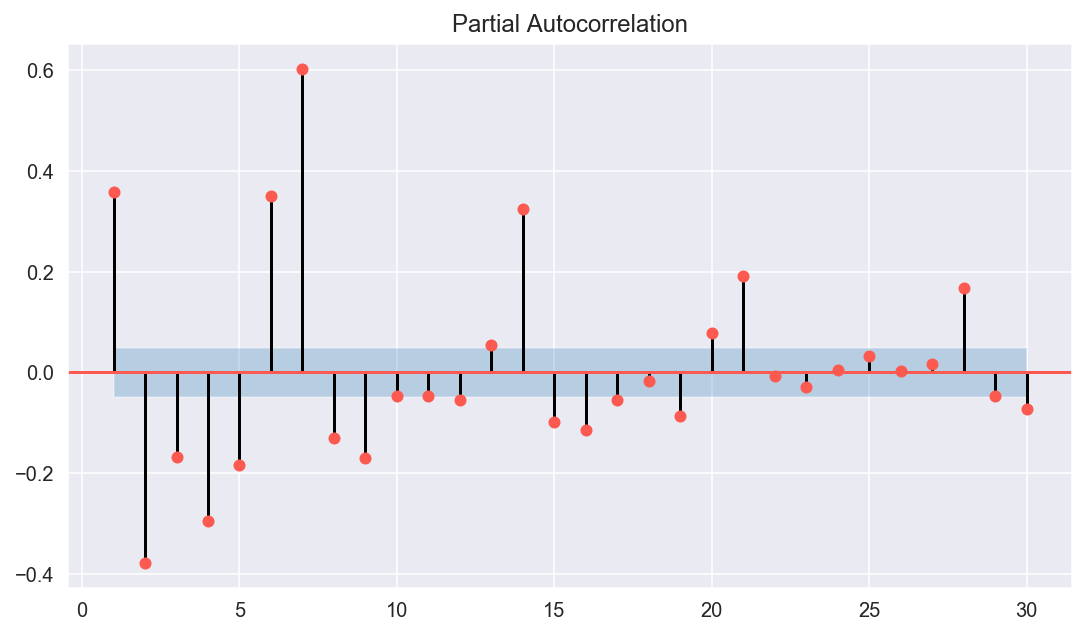

In [29]:
fig, ax = plt.subplots(figsize = (9, 5))
plot_pacf(df_daily_traffic['Hourly_Entries'], lags = 30, ax = ax, color=sns.xkcd_rgb["coral"], zero=False)
plt.show();

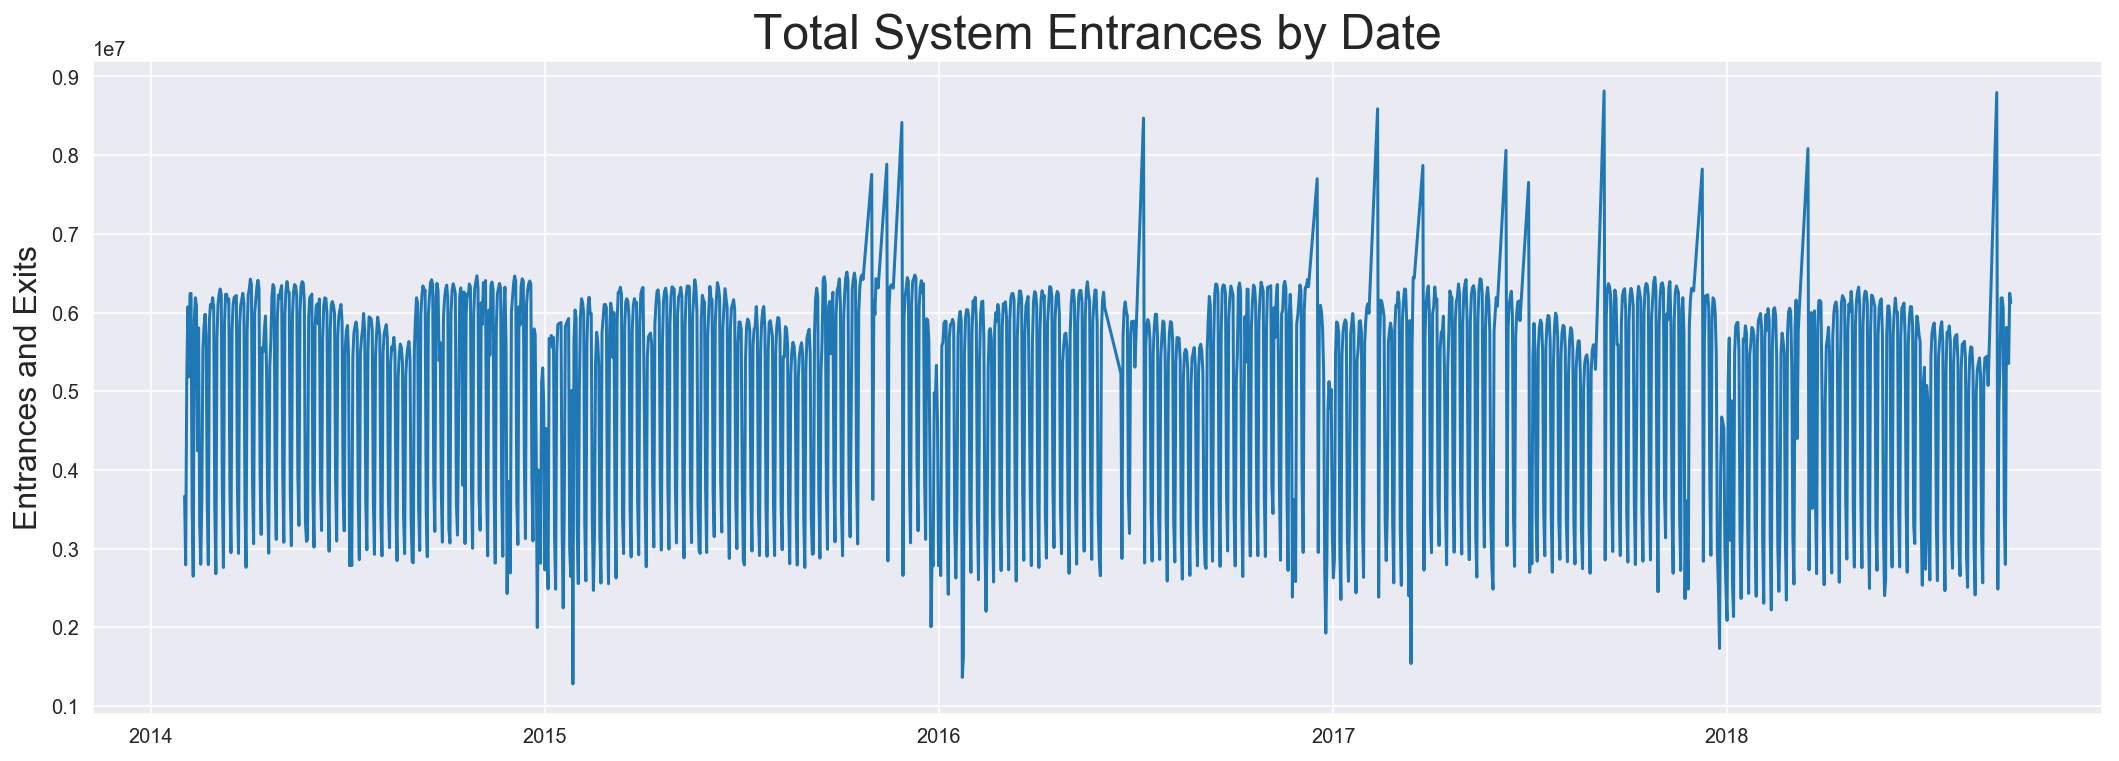

In [49]:
plt.figure(figsize=(18,6))
pd.options.display.float_format = '{:.0f}'.format
sns.lineplot(df_daily_traffic.index,df_daily_traffic.Hourly_Entries);
plt.title('Total System Entrances by Date', fontsize=24);
plt.ylabel('Entrances and Exits', fontsize=16);
plt.xlabel('', fontsize=16);

## Daily masks

In [50]:
# Create a mask for each day of the week 
mask_monday = df_daily_traffic['weekday'] == 0
mask_tuesday = df_daily_traffic['weekday'] == 1
mask_wednesday = df_daily_traffic['weekday'] == 2
mask_thursday = df_daily_traffic['weekday'] == 3
mask_firday = df_daily_traffic['weekday'] == 4
mask_saturday = df_daily_traffic['weekday'] == 5
mask_sunday = df_daily_traffic['weekday'] == 6

## Sunday

Sunday was the most dissimlar day of the week. Looking only at sundays to see how the correlate.  

In [51]:
# Create a dataframe of only sundays
df_sunday_traffic = pd.DataFrame(df_daily_traffic[mask_sunday])

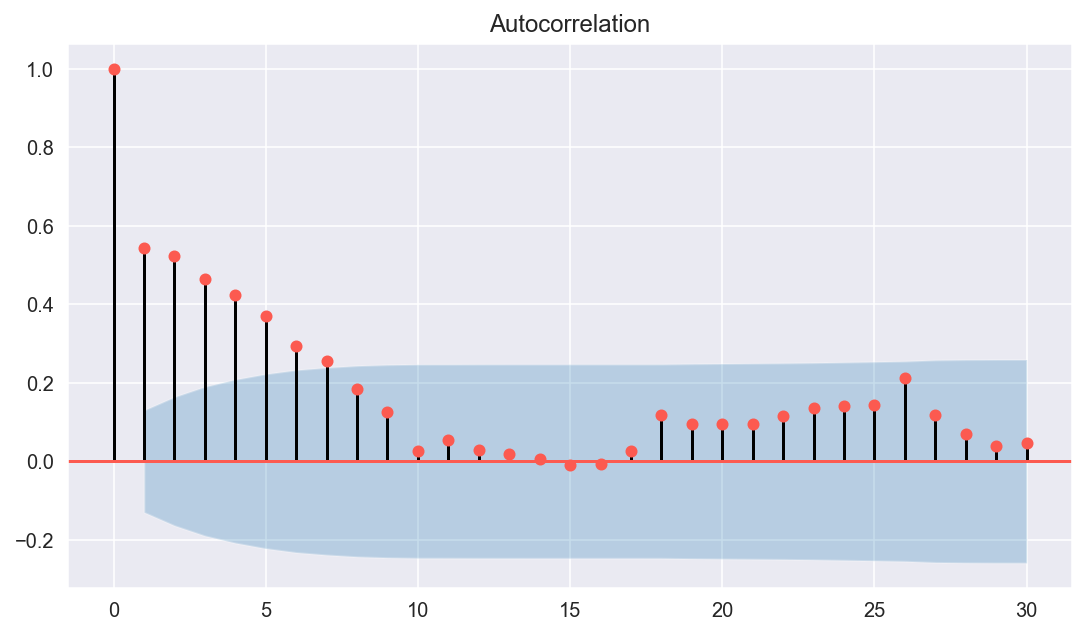

In [52]:
fig, ax = plt.subplots(figsize = (9, 5))
plot_acf(df_sunday_traffic['traffic'], lags = 30, ax = ax, color=sns.xkcd_rgb["coral"])
plt.show();

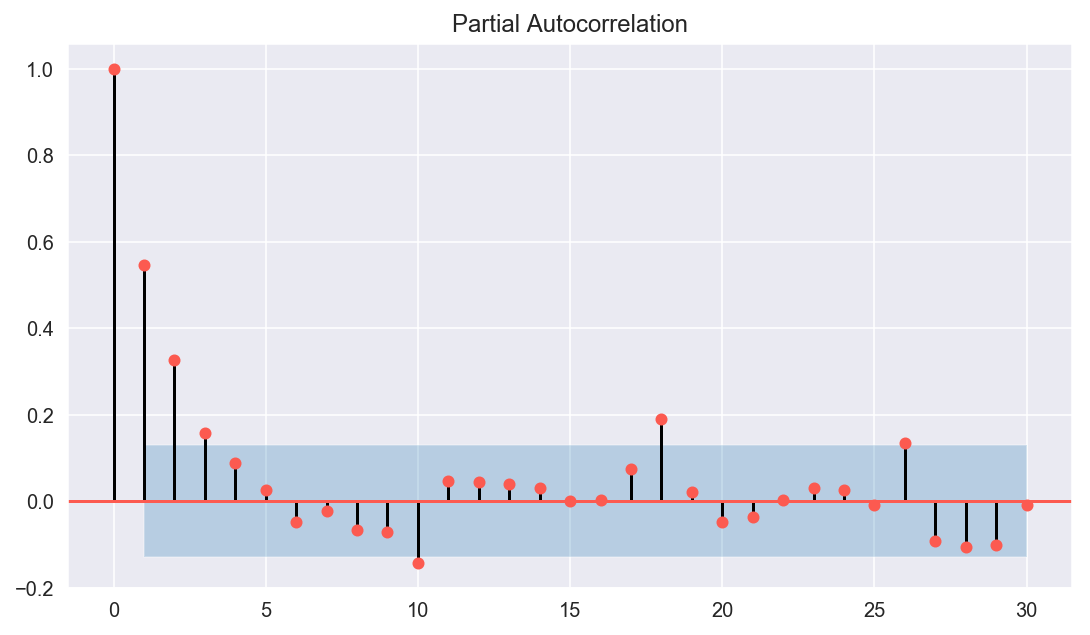

In [53]:
fig, ax = plt.subplots(figsize = (9, 5))
plot_pacf(df_sunday_traffic['traffic'], lags = 30, ax = ax, color=sns.xkcd_rgb["coral"])
plt.show();

# Prince St

In [66]:
# Create a mask to filer only Price St. 
mask_prince = df['Unit'] == 'R086'

In [67]:
df[mask_prince].head()

level_0   C/A  Unit       SCP          Station LineName Division  \
81205    81205  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   
81206    81206  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   
81207    81207  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   
81208    81208  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   
81209    81209  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   

             Date      Time Description  Entries    Exits            datetime  \
81205  02/01/2014  03:00:00     REGULAR  7731499  2735573 2014-02-01 03:00:00   
81206  02/01/2014  07:00:00     REGULAR  7731510  2735581 2014-02-01 07:00:00   
81207  02/01/2014  11:00:00     REGULAR  7731583  2735709 2014-02-01 11:00:00   
81208  02/01/2014  15:00:00     REGULAR  7732030  2735952 2014-02-01 15:00:00   
81209  02/01/2014  19:00:00     REGULAR  7733098  2736141 2014-02-01 19:00:00   

       Year  weekday  Hourly_Entries  Hourly_Exits  traffic  valid  
81205  2014        5         7719191       2680581 10399772  False  
81206  2014        5              11             8       19   True  
81207  2014        5              73           128      201   True  
81208  2014        5             447           243      690   True  
81209  2014        5            1068           189     1257   True

In [71]:
# Check the number of unique dates which appear in the turnstile data for Prince St
prince_dates = pd.DataFrame(df[mask_prince].Date.unique())
print(prince_dates.shape)

(1589, 1)


In [269]:
# Check the row counts for each unique turnstile at Prince Street.
df[mask_prince].SCP.value_counts()

00-00-00    9829
00-00-04    9826
00-00-02    9826
00-00-03    9825
00-00-01    9824
01-00-02    9750
01-00-00    9749
01-00-03    9748
01-00-01    9745
01-00-04    9704
00-07-00     722
01-04-00     720
01-07-00     719
00-04-00     715
00-07-01     704
Name: SCP, dtype: int64

In [73]:
# Create a dataframe consiting of only the data from Prince St
df_prince = pd.DataFrame(df[mask_prince].sort_values(['SCP','datetime']))
df_prince.head()

level_0   C/A  Unit       SCP          Station LineName Division  \
81205    81205  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   
81206    81206  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   
81207    81207  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   
81208    81208  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   
81209    81209  A041  R086  00-00-00  PRINCE ST-B'WAY       NR      BMT   

             Date      Time Description  Entries    Exits            datetime  \
81205  02/01/2014  03:00:00     REGULAR  7731499  2735573 2014-02-01 03:00:00   
81206  02/01/2014  07:00:00     REGULAR  7731510  2735581 2014-02-01 07:00:00   
81207  02/01/2014  11:00:00     REGULAR  7731583  2735709 2014-02-01 11:00:00   
81208  02/01/2014  15:00:00     REGULAR  7732030  2735952 2014-02-01 15:00:00   
81209  02/01/2014  19:00:00     REGULAR  7733098  2736141 2014-02-01 19:00:00   

       Year  weekday  Hourly_Entries  Hourly_Exits  traffic  valid  
81205  2014        5         7719191       2680581 10399772  False  
81206  2014        5              11             8       19   True  
81207  2014        5              73           128      201   True  
81208  2014        5             447           243      690   True  
81209  2014        5            1068           189     1257   True

In [74]:
# Create masks for each unique turnstile at Prince St. 
mask_000000 = df_prince['SCP'] == '00-00-00'
mask_000004 = df_prince['SCP'] == '00-00-04'
mask_000002 = df_prince['SCP'] == '00-00-02'
mask_000003 = df_prince['SCP'] == '00-00-03'
mask_000001 = df_prince['SCP'] == '00-00-01'
mask_010002 = df_prince['SCP'] == '01-00-02'
mask_010000 = df_prince['SCP'] == '01-00-00'
mask_010003 = df_prince['SCP'] == '01-00-03'
mask_010001 = df_prince['SCP'] == '01-00-01'
mask_010004 = df_prince['SCP'] == '01-00-04'
mask_000700 = df_prince['SCP'] == '00-07-00'
mask_010400 = df_prince['SCP'] == '01-04-00'
mask_010700 = df_prince['SCP'] == '01-07-00'
mask_000400 = df_prince['SCP'] == '00-04-00'
mask_000701 = df_prince['SCP'] == '00-07-01'

In [75]:
# Create dataframe for each unique turnstile at Price St
prince_000000 = pd.DataFrame(df_prince[mask_000000]).sort_values(['datetime'])
prince_000004 = pd.DataFrame(df_prince[mask_000004]).sort_values(['datetime'])
prince_000002 = pd.DataFrame(df_prince[mask_000002]).sort_values(['datetime'])
prince_000003 = pd.DataFrame(df_prince[mask_000003]).sort_values(['datetime'])
prince_000001 = pd.DataFrame(df_prince[mask_000001]).sort_values(['datetime'])
prince_010002 = pd.DataFrame(df_prince[mask_010002]).sort_values(['datetime'])
prince_010000 = pd.DataFrame(df_prince[mask_010000]).sort_values(['datetime'])
prince_010003 = pd.DataFrame(df_prince[mask_010003]).sort_values(['datetime'])
prince_010001 = pd.DataFrame(df_prince[mask_010001]).sort_values(['datetime'])
prince_010004 = pd.DataFrame(df_prince[mask_010004]).sort_values(['datetime'])
prince_000700 = pd.DataFrame(df_prince[mask_000700]).sort_values(['datetime'])
prince_010400 = pd.DataFrame(df_prince[mask_010400]).sort_values(['datetime'])
prince_010700 = pd.DataFrame(df_prince[mask_010700]).sort_values(['datetime'])
prince_000400 = pd.DataFrame(df_prince[mask_000400]).sort_values(['datetime'])
prince_000701 = pd.DataFrame(df_prince[mask_000701]).sort_values(['datetime'])

In [76]:
# check the differneces for each unique turnstile at Prince St
prince_000000['Hourly_Entries'] = prince_000000['Entries'].diff()
prince_000000['Hourly_Exits'] = prince_000000['Exits'].diff()
prince_000004['Hourly_Entries'] = prince_000004['Entries'].diff()
prince_000004['Hourly_Exits'] = prince_000004['Exits'].diff()
prince_000002['Hourly_Entries'] = prince_000002['Entries'].diff()
prince_000002['Hourly_Exits'] = prince_000002['Exits'].diff()
prince_000003['Hourly_Entries'] = prince_000003['Entries'].diff()
prince_000003['Hourly_Exits'] = prince_000003['Exits'].diff()
prince_000001['Hourly_Entries'] = prince_000001['Entries'].diff()
prince_000001['Hourly_Exits'] = prince_000001['Exits'].diff()
prince_010000['Hourly_Entries'] = prince_010000['Entries'].diff()
prince_010000['Hourly_Exits'] = prince_010000['Exits'].diff()
prince_010004['Hourly_Entries'] = prince_010004['Entries'].diff()
prince_010004['Hourly_Exits'] = prince_010004['Exits'].diff()
prince_010002['Hourly_Entries'] = prince_010002['Entries'].diff()
prince_010002['Hourly_Exits'] = prince_010002['Exits'].diff()
prince_010003['Hourly_Entries'] = prince_010003['Entries'].diff()
prince_010003['Hourly_Exits'] = prince_010003['Exits'].diff()
prince_010001['Hourly_Entries'] = prince_010001['Entries'].diff()
prince_010001['Hourly_Exits'] = prince_010001['Exits'].diff()
prince_000700['Hourly_Entries'] = prince_000700['Entries'].diff()
prince_000700['Hourly_Exits'] = prince_000700['Exits'].diff()
prince_010400['Hourly_Entries'] = prince_010400['Entries'].diff()
prince_010400['Hourly_Exits'] = prince_010400['Exits'].diff()
prince_010700['Hourly_Entries'] = prince_010700['Entries'].diff()
prince_010700['Hourly_Exits'] = prince_010700['Exits'].diff()
prince_000400['Hourly_Entries'] = prince_000400['Entries'].diff()
prince_000400['Hourly_Exits'] = prince_000400['Exits'].diff()
prince_000701['Hourly_Entries'] = prince_000701['Entries'].diff()
prince_000701['Hourly_Exits'] = prince_000701['Exits'].diff()

### Turnstile Counters Reset

Two of the turnstiles had their couters reset during observation period.  This resulted in negative differences when calulating Hourly block instance counts. 

There are a few charts below.  The first two are a baseline showing a turnstile, 00-00-00, which did not experiance a reset during the observation period, showing Hourly block instances of Entries and Exits.  Next are the same charts for the two turnstiles, 01-00-02 and 01-00-04, which experianced resets during the observation period, the latter of which experianced multiple resets.  

#### Turnstile 00-00-00

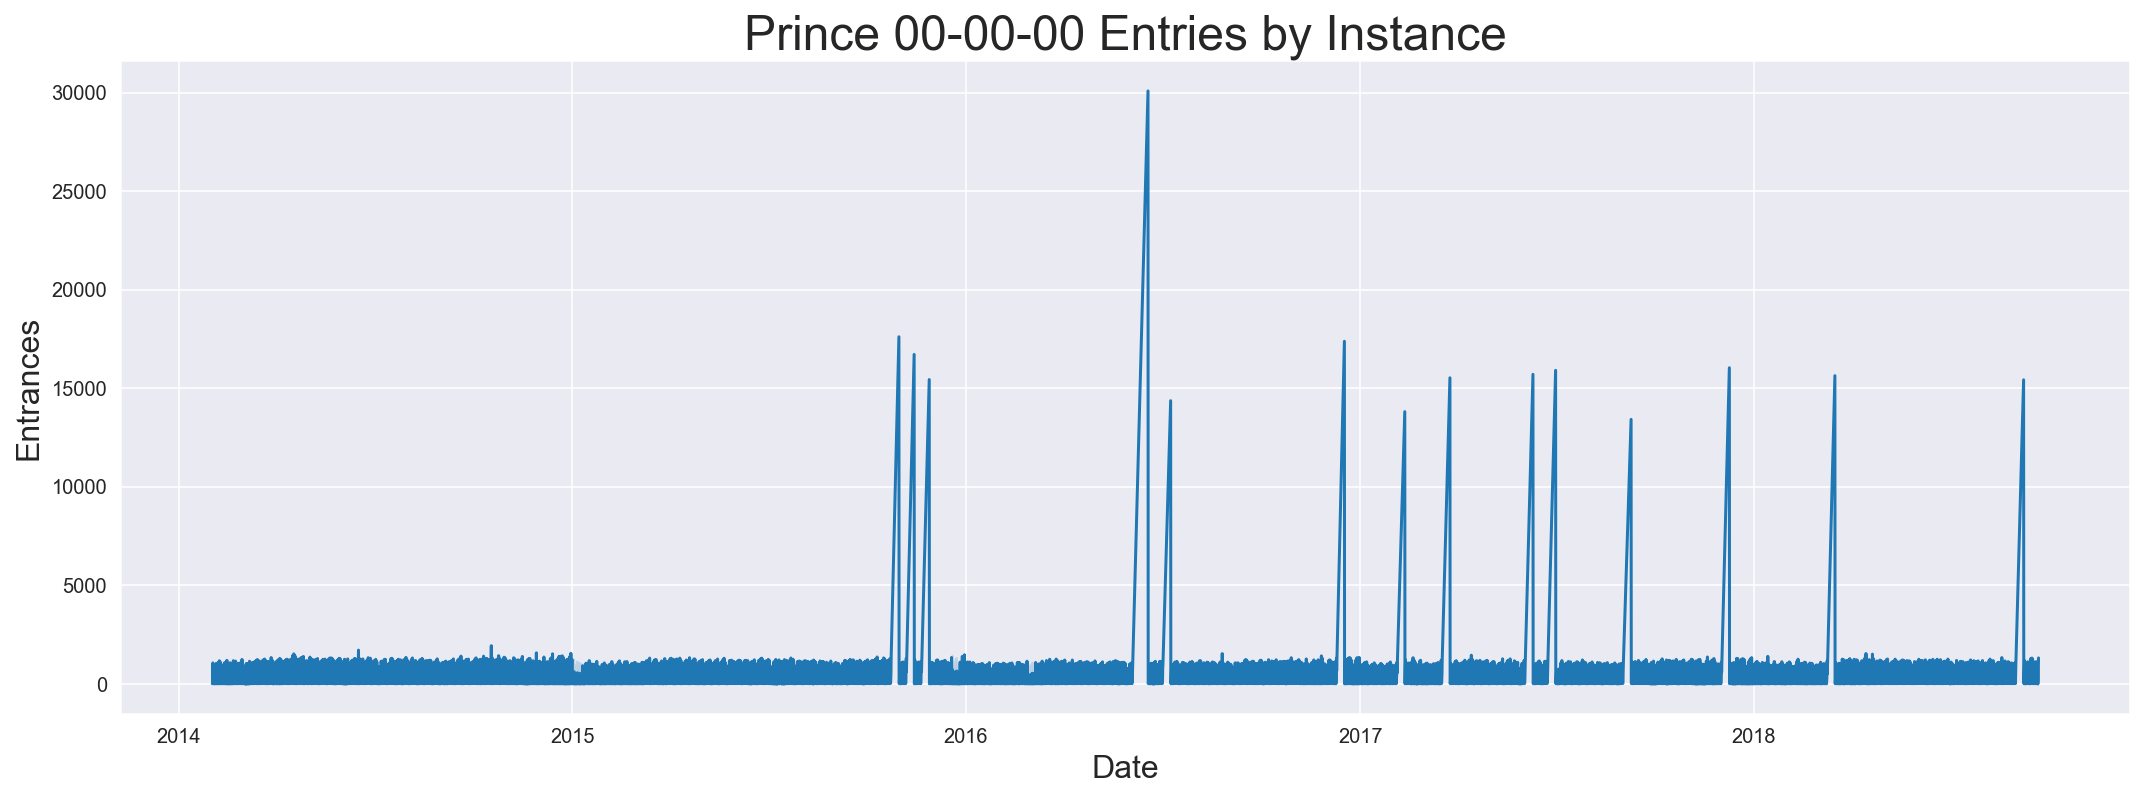

In [78]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000000.datetime,prince_000000.Hourly_Entries);
plt.title('Prince 00-00-00 Entries by Instance', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

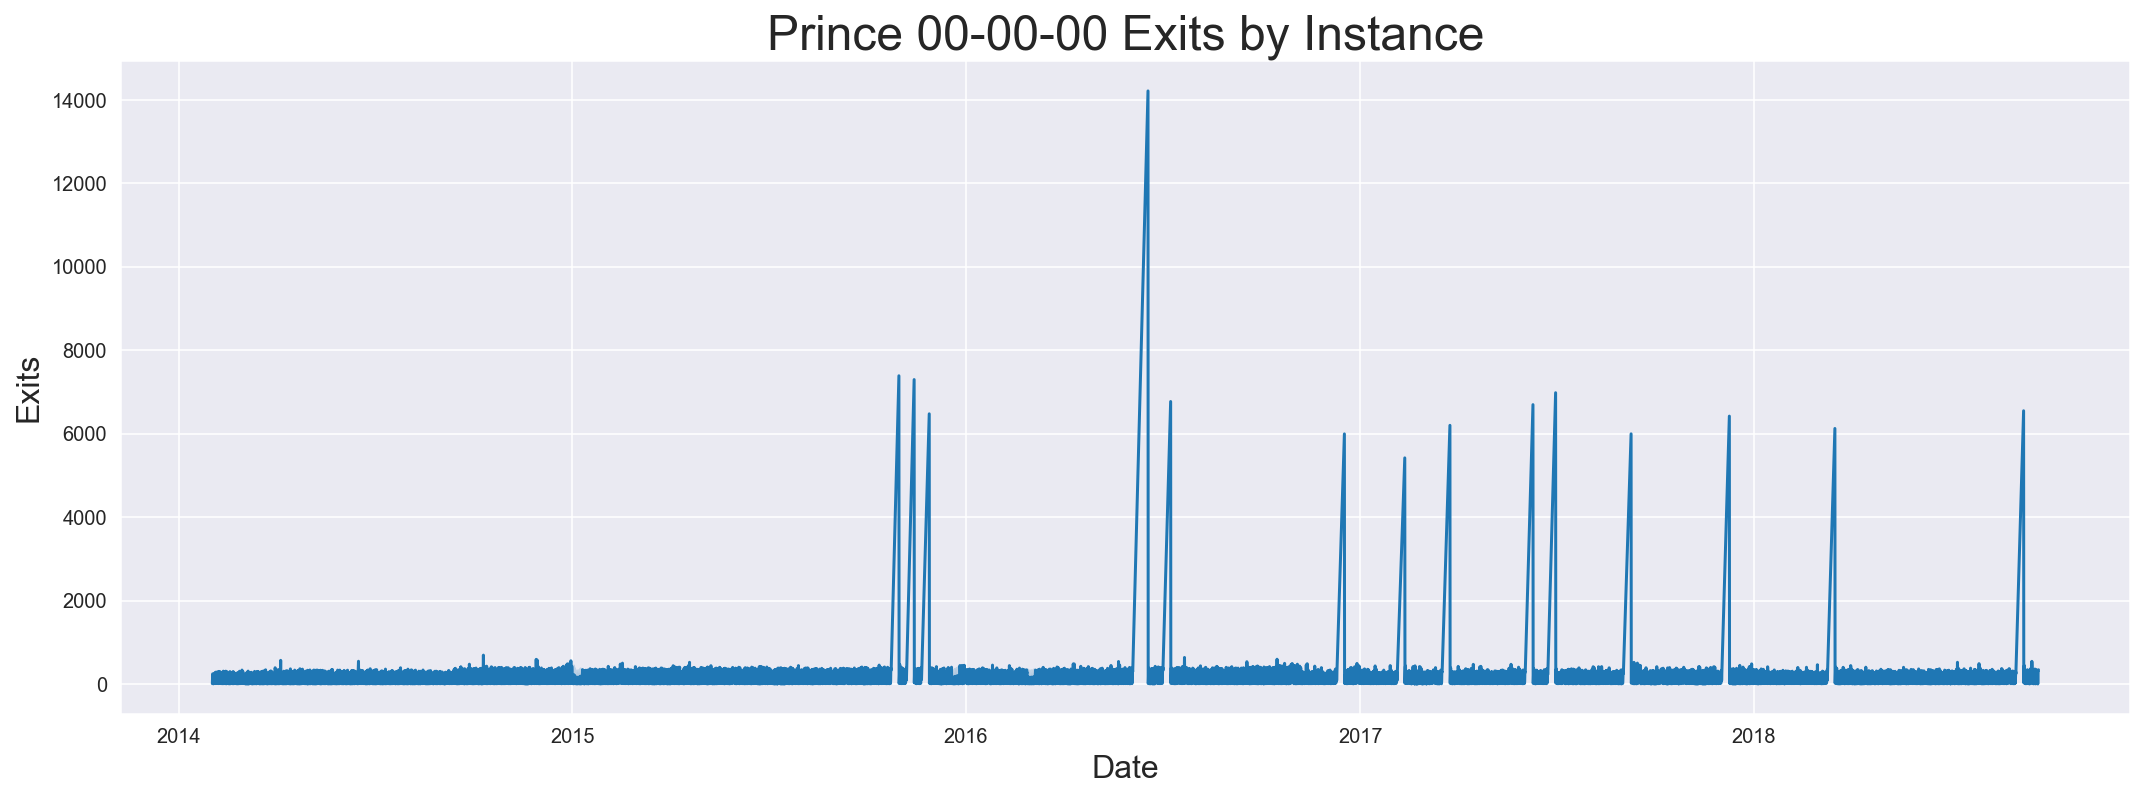

In [79]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000000.datetime,prince_000000.Hourly_Exits);
plt.title('Prince 00-00-00 Exits by Instance', fontsize=24);
plt.ylabel('Exits', fontsize=16);
plt.xlabel('Date', fontsize=16);

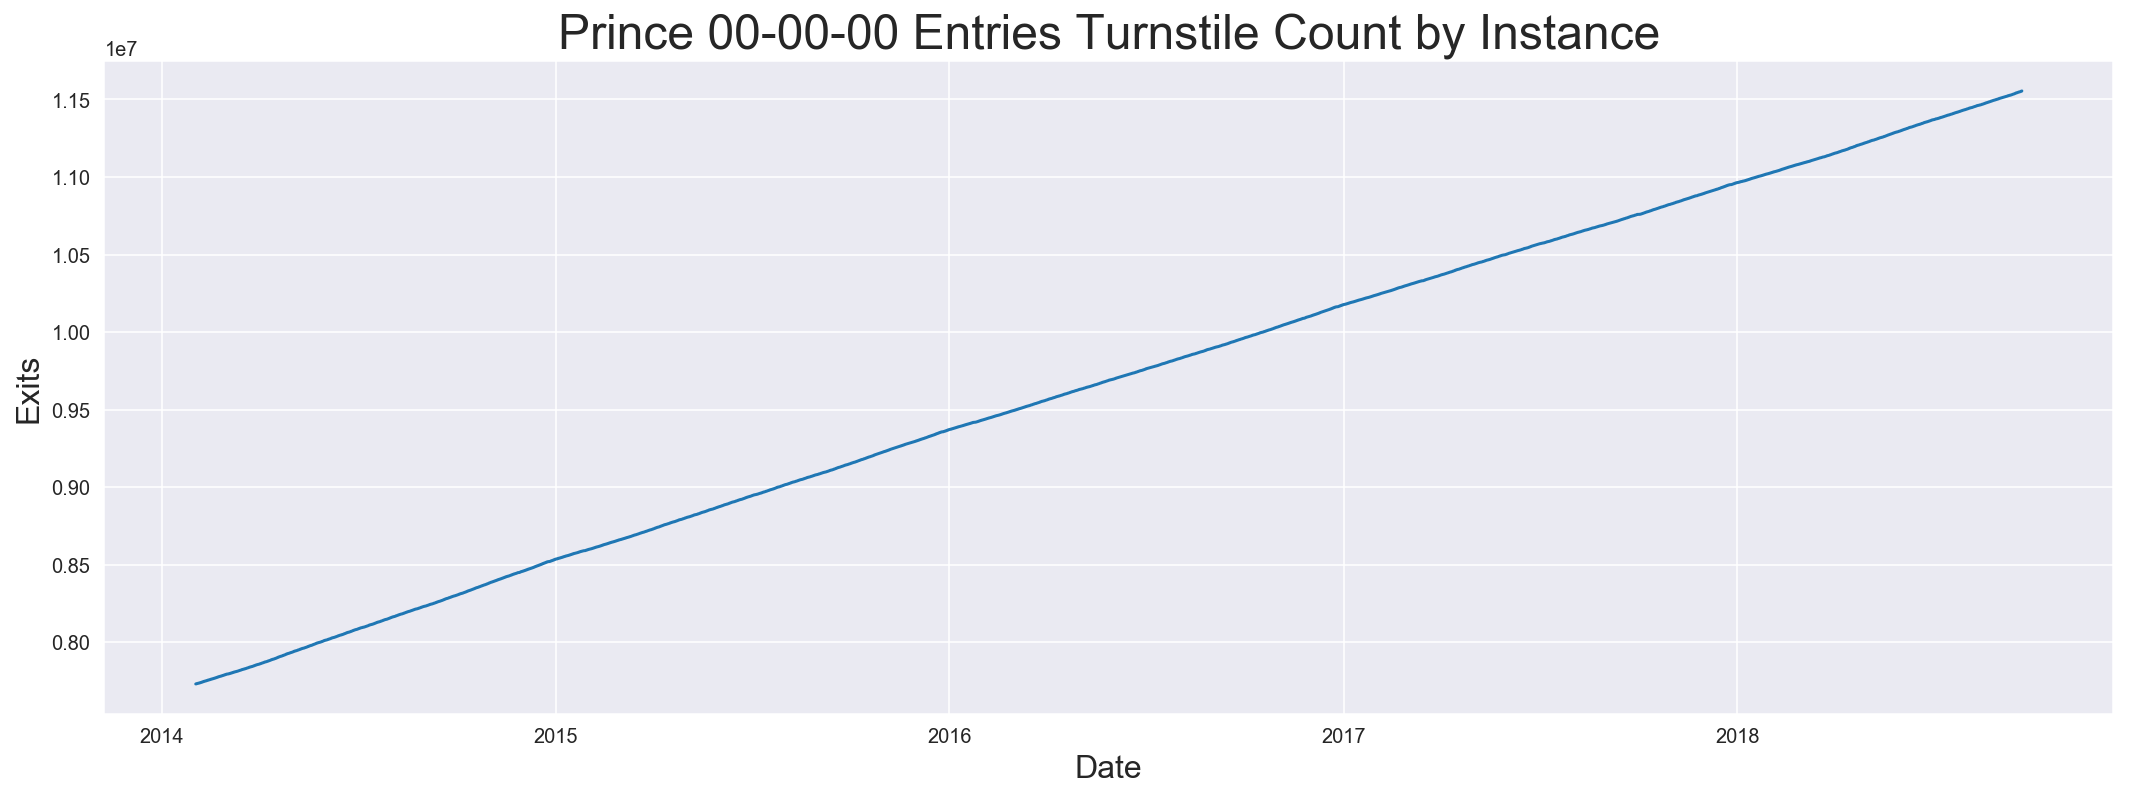

In [80]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000000.datetime,prince_000000.Entries);
plt.title('Prince 00-00-00 Entries Turnstile Count by Instance', fontsize=24);
plt.ylabel('Exits', fontsize=16);
plt.xlabel('Date', fontsize=16);

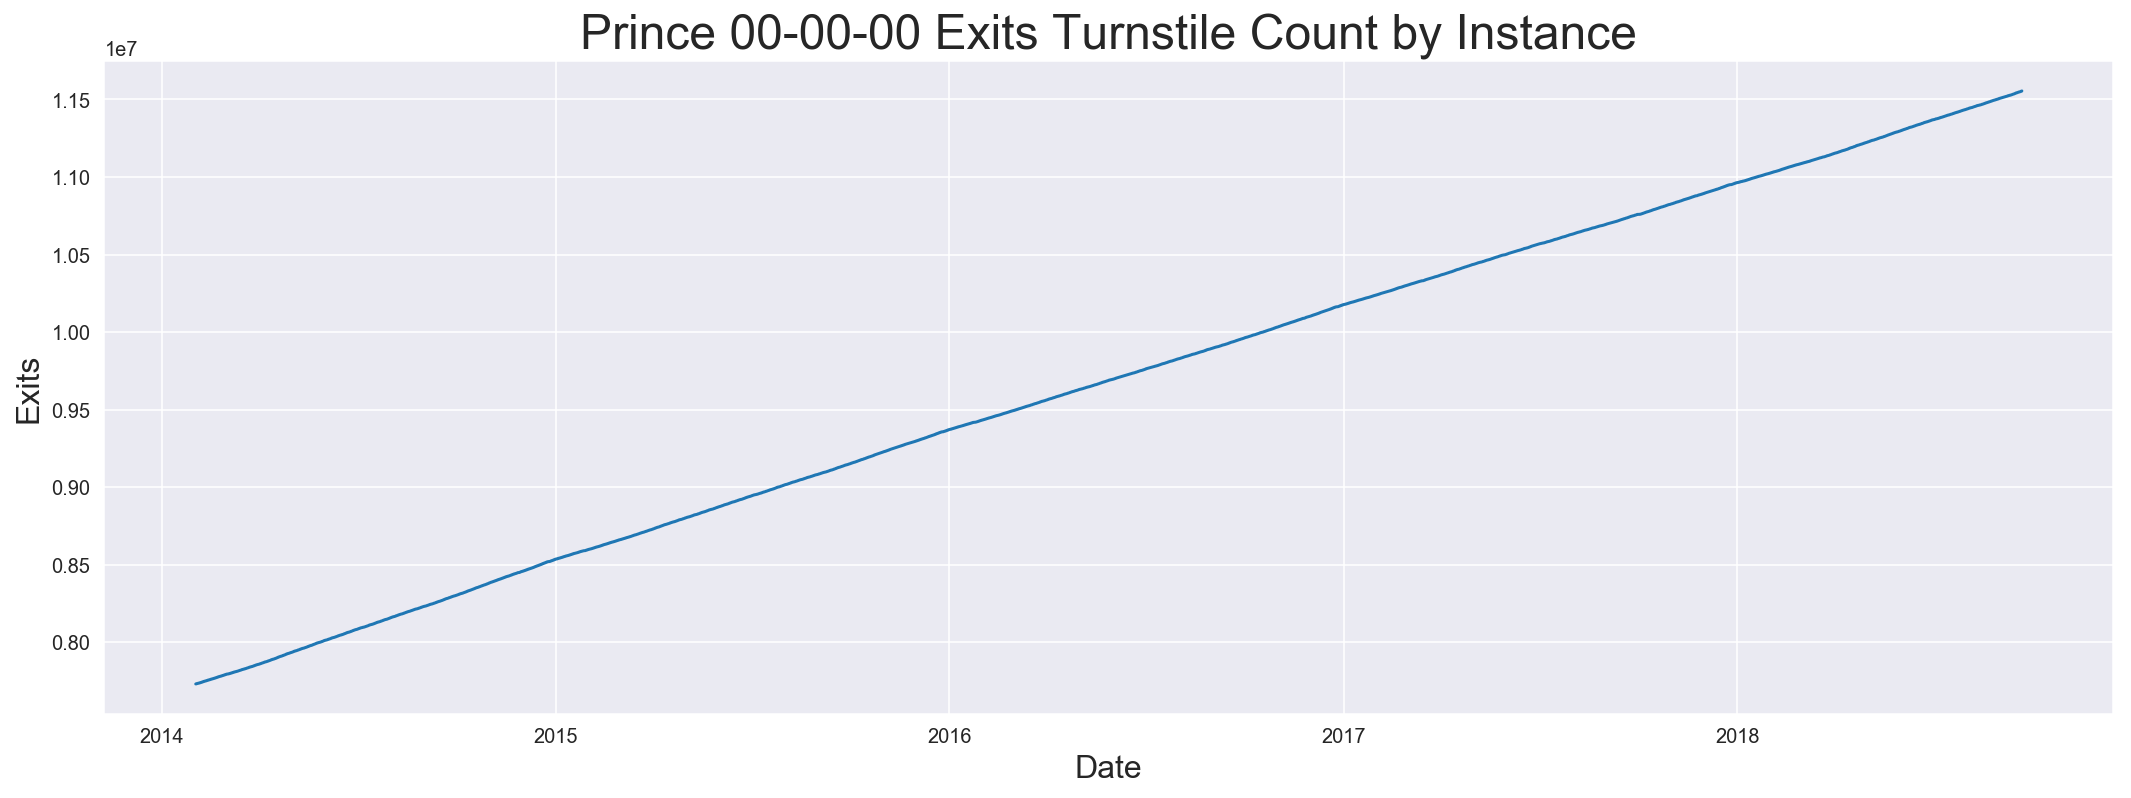

In [81]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000000.datetime,prince_000000.Entries);
plt.title('Prince 00-00-00 Exits Turnstile Count by Instance', fontsize=24);
plt.ylabel('Exits', fontsize=16);
plt.xlabel('Date', fontsize=16);

#### Turnstile 01-00-02

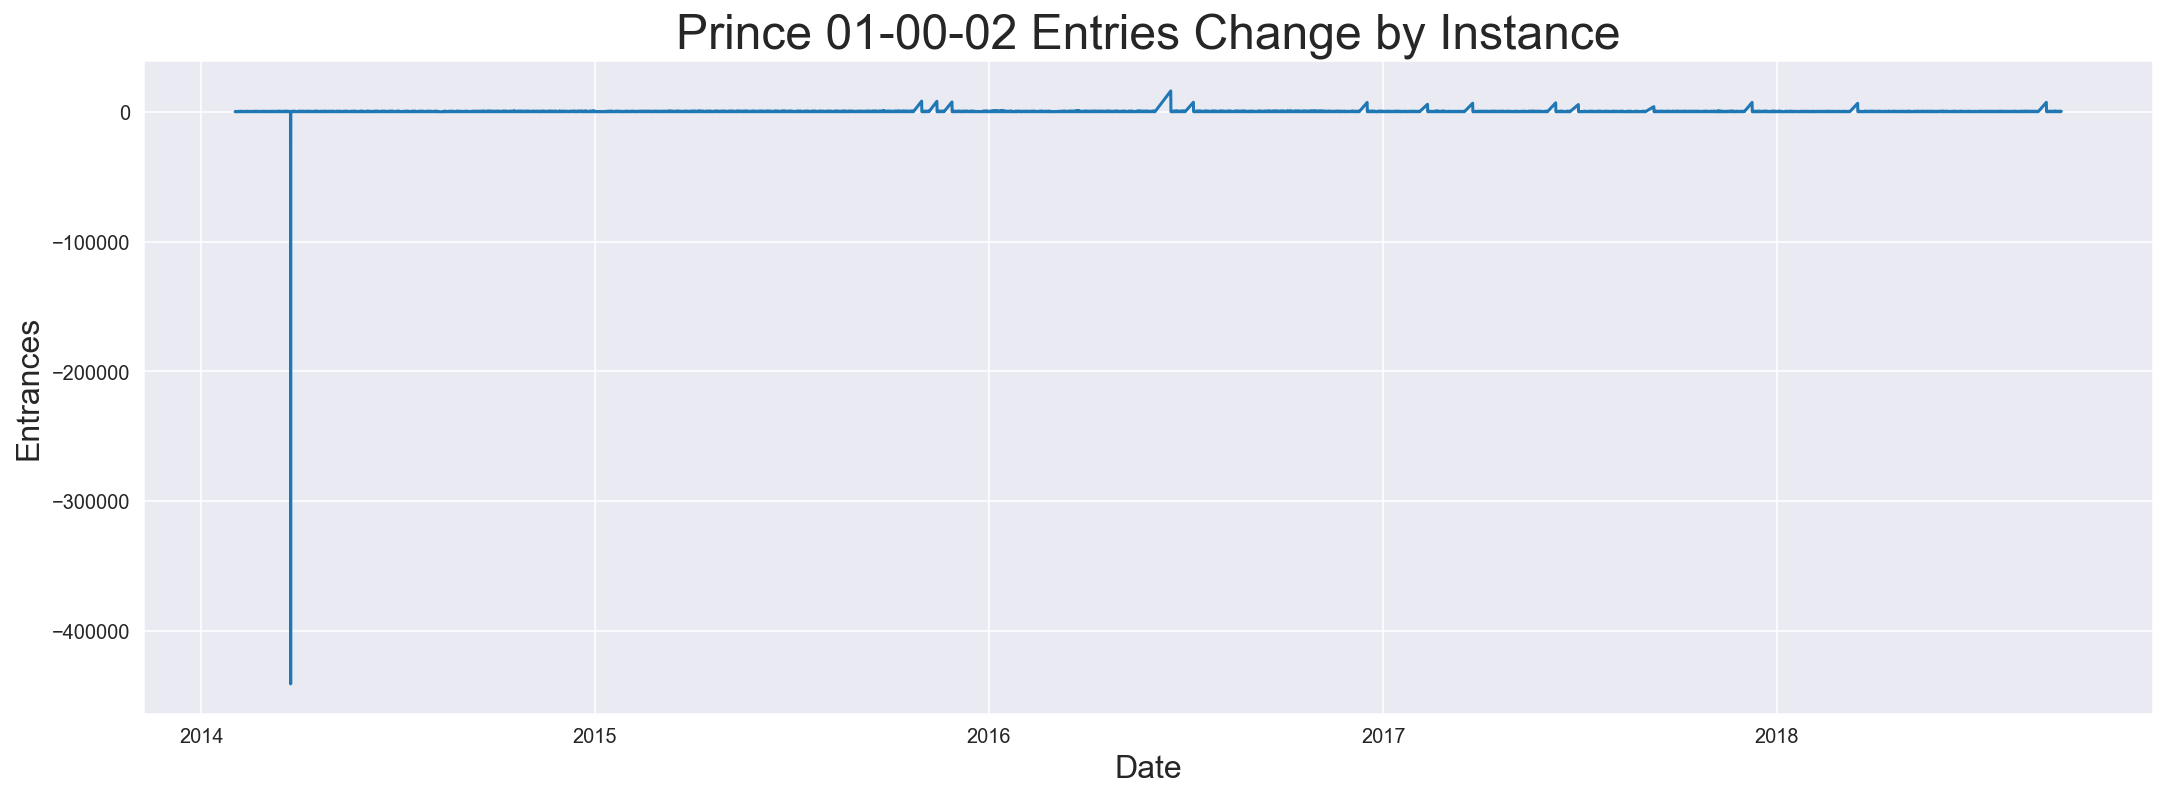

In [82]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010002.datetime,prince_010002.Hourly_Entries);
plt.title('Prince 01-00-02 Entries Change by Instance', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

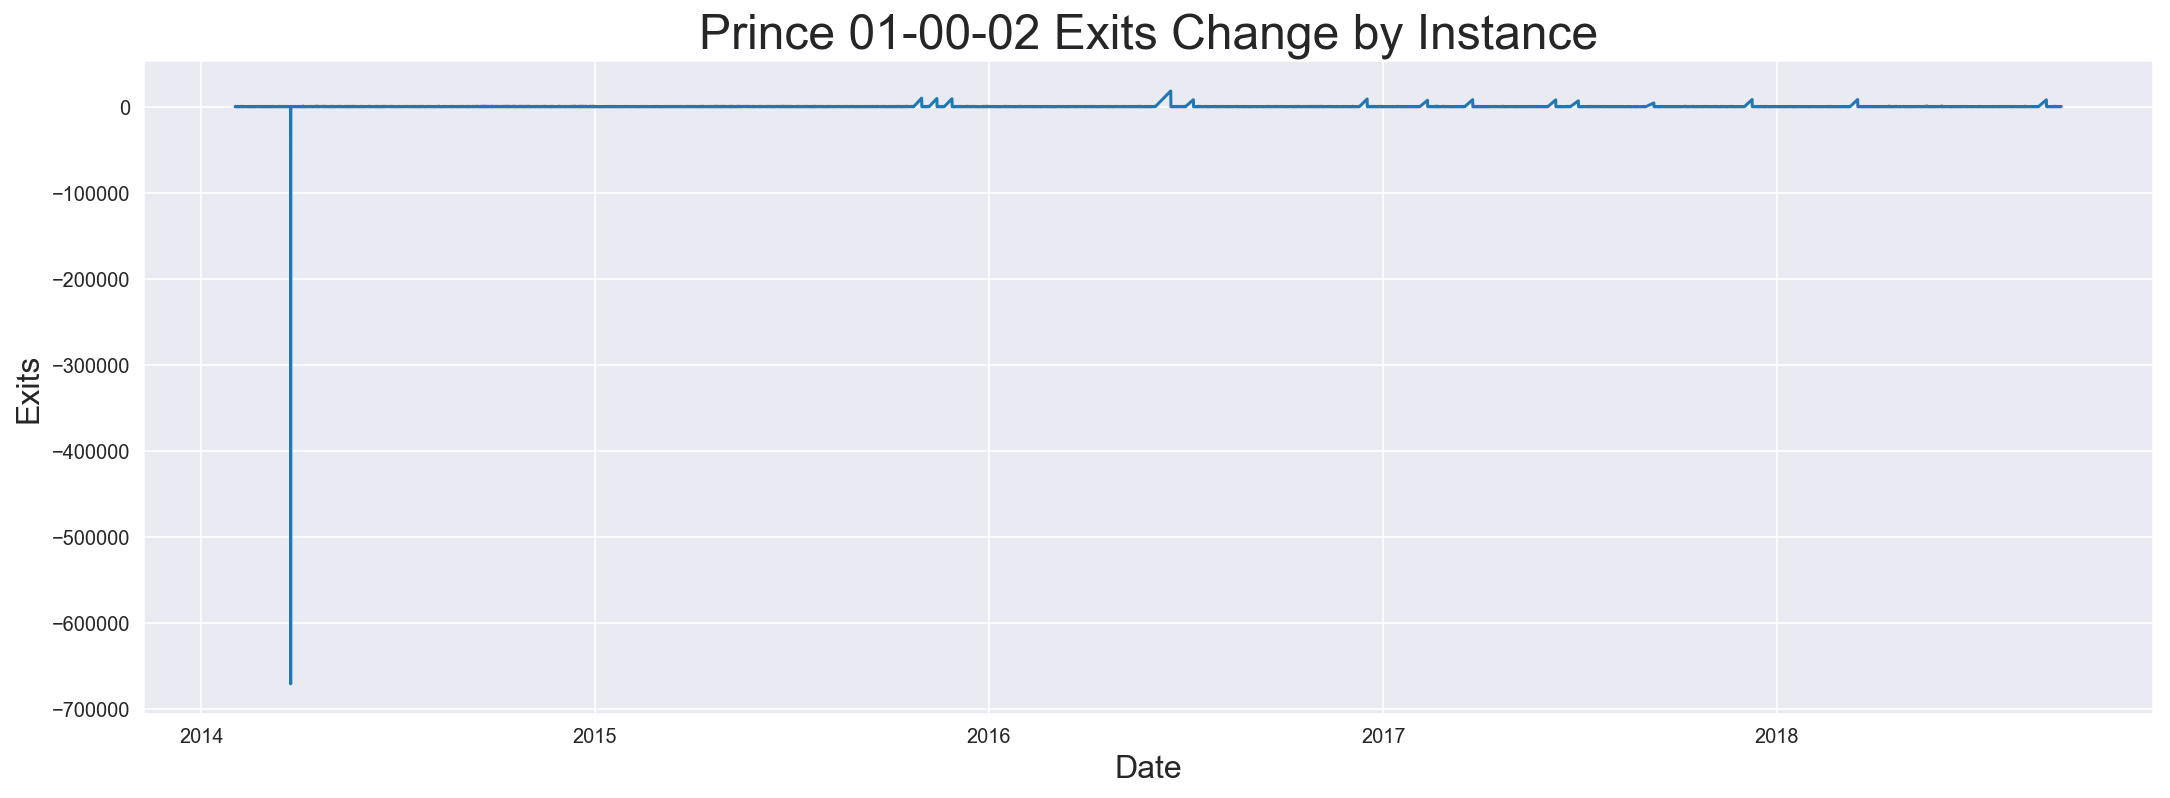

In [83]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010002.datetime,prince_010002.Hourly_Exits);
plt.title('Prince 01-00-02 Exits Change by Instance', fontsize=24);
plt.ylabel('Exits', fontsize=16);
plt.xlabel('Date', fontsize=16);

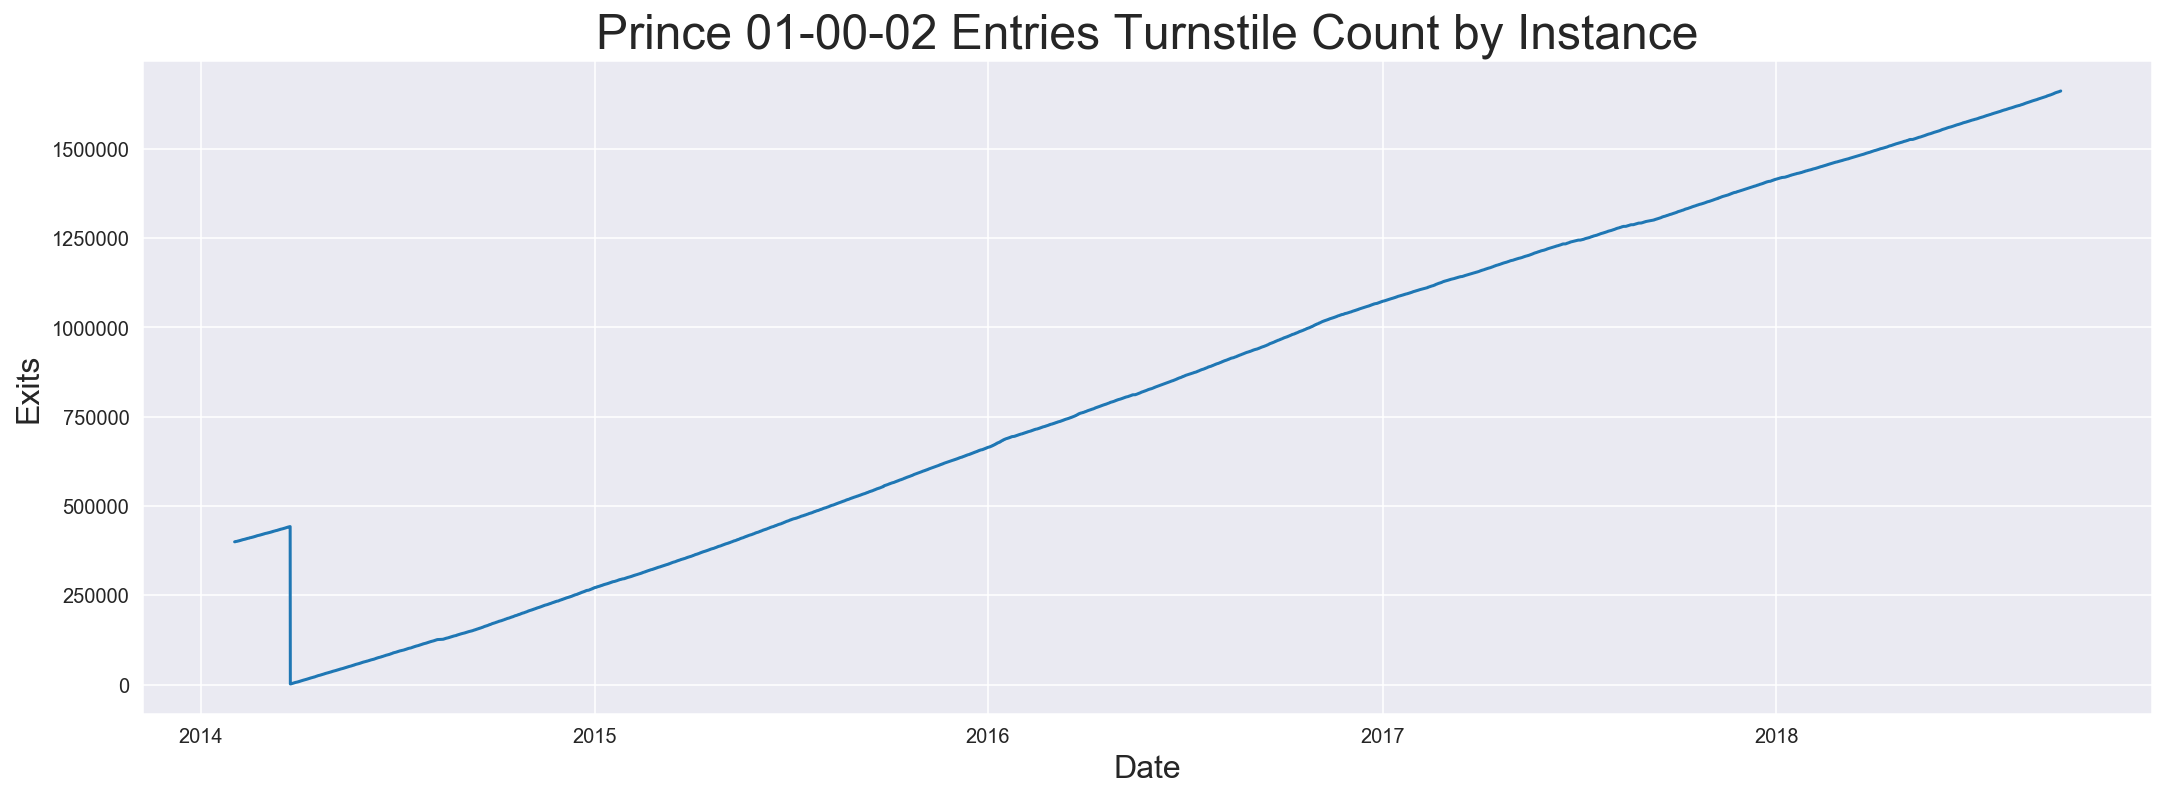

In [84]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010002.datetime,prince_010002.Entries);
plt.title('Prince 01-00-02 Entries Turnstile Count by Instance', fontsize=24);
plt.ylabel('Exits', fontsize=16);
plt.xlabel('Date', fontsize=16);

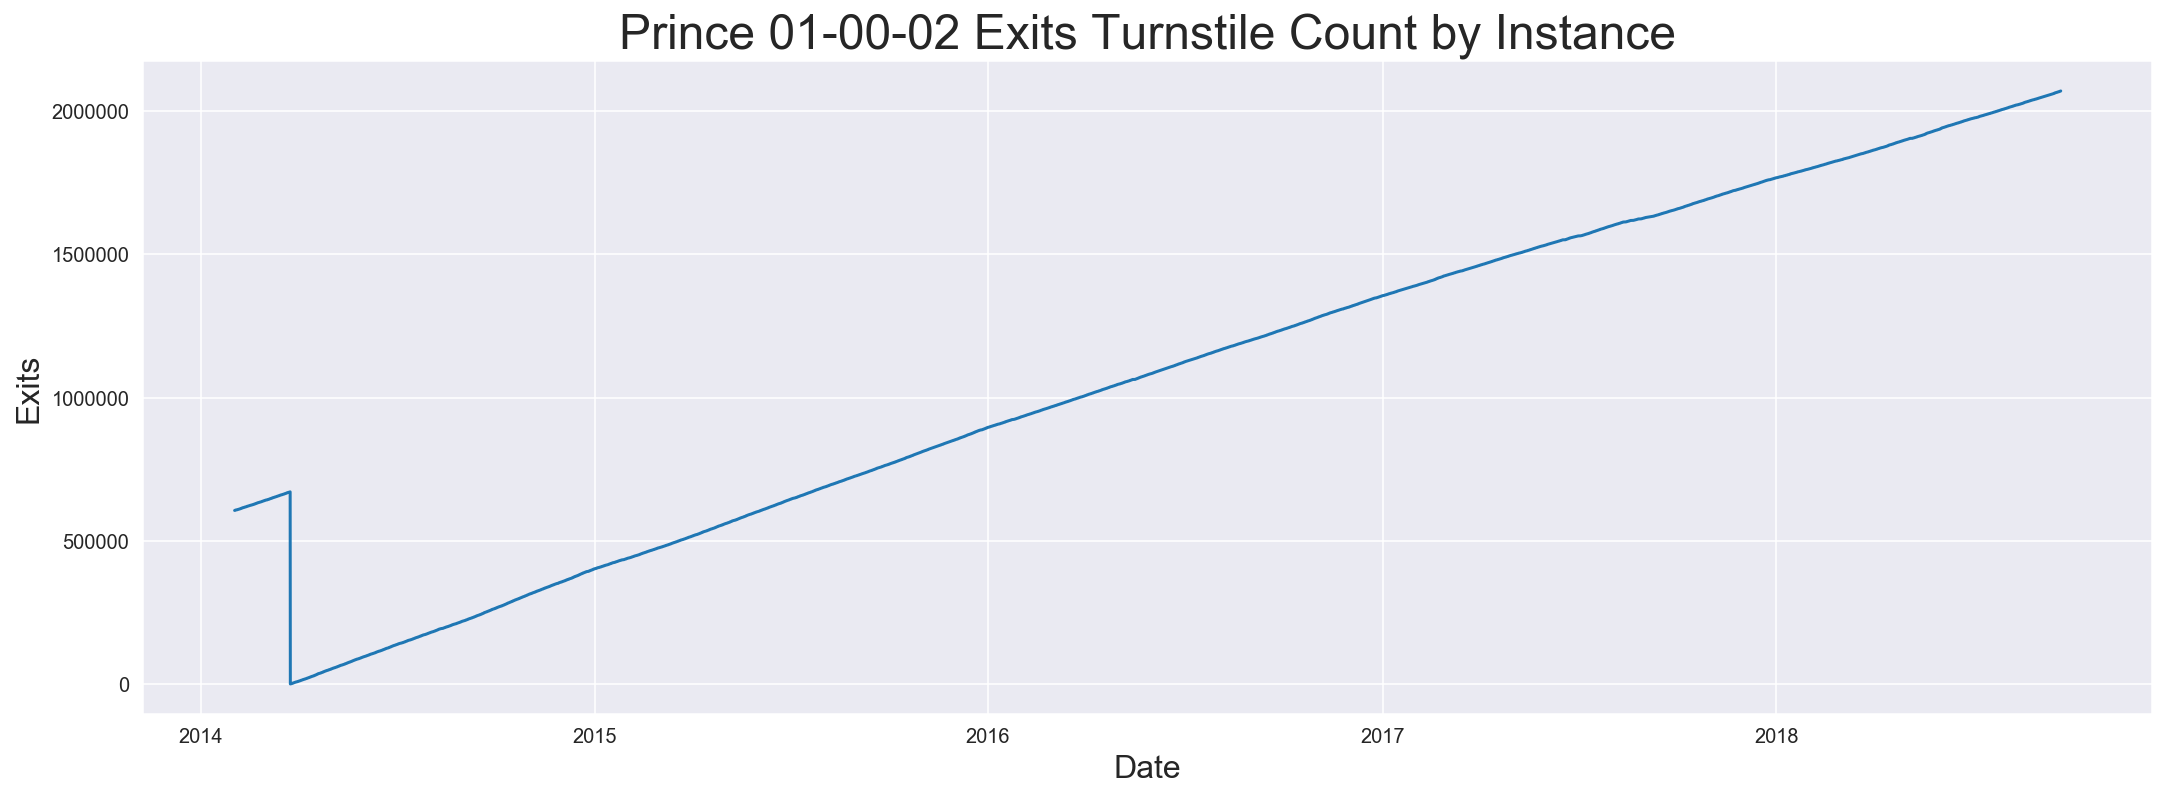

In [85]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010002.datetime,prince_010002.Exits);
plt.title('Prince 01-00-02 Exits Turnstile Count by Instance', fontsize=24);
plt.ylabel('Exits', fontsize=16);
plt.xlabel('Date', fontsize=16);

#### Setting the Negative Hourly block count values to the Turnstile Count

In [86]:
# Reset the index to allow proper indexing for replacement
prince_010002.reset_index(inplace=True)
prince_010002.drop(columns=['index'], inplace=True)

In [87]:
# create a mask to show the negative Hourly count value
prince_010002_neg = prince_010002['Hourly_Entries'] < 0

In [88]:
#show the row with the negative value 
prince_010002[prince_010002_neg]

level_0   C/A  Unit       SCP          Station LineName Division  \
311  1820414  A042  R086  01-00-02  PRINCE ST-B'WAY       NR      BMT   

           Date      Time Description  Entries  Exits            datetime  \
311  03/24/2014  20:00:00     REGULAR     1890     57 2014-03-24 20:00:00   

     Year  weekday  Hourly_Entries  Hourly_Exits  traffic  valid  
311  2014        0         -440614       -670731  1111345  False

In [89]:
# Set the values for the Hourly_Entries and Hourly_Exits cells in the affected row to the Turnstile Count
prince_010002.at[311, 'Hourly_Entries'] = prince_010002.at[311, 'Entries']
prince_010002.at[311, 'Hourly_Exits'] = prince_010002.at[311, 'Exits']

In [90]:
# Show the values of the updated cells
print(prince_010002.at[311, 'Hourly_Entries'])
print(prince_010002.at[311, 'Hourly_Exits'])

1890.0
57.0


#### Turnstile 01-00-04

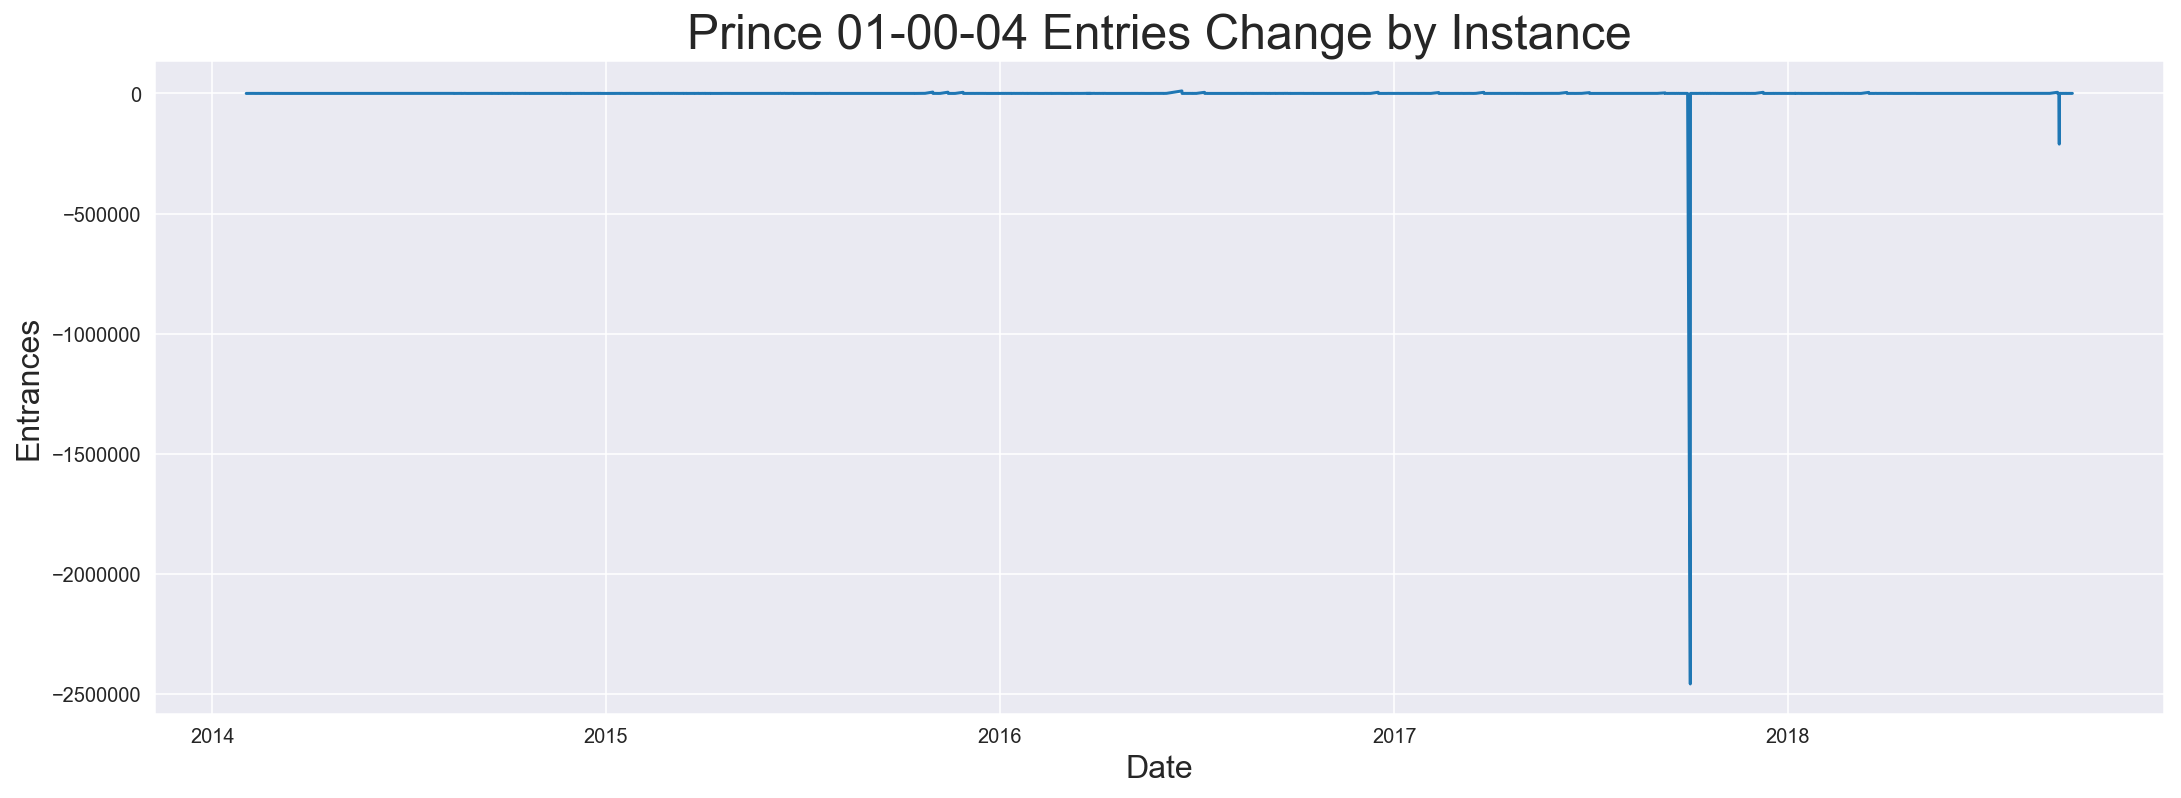

In [91]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010004.datetime,prince_010004.Hourly_Entries);
plt.title('Prince 01-00-04 Entries Change by Instance', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

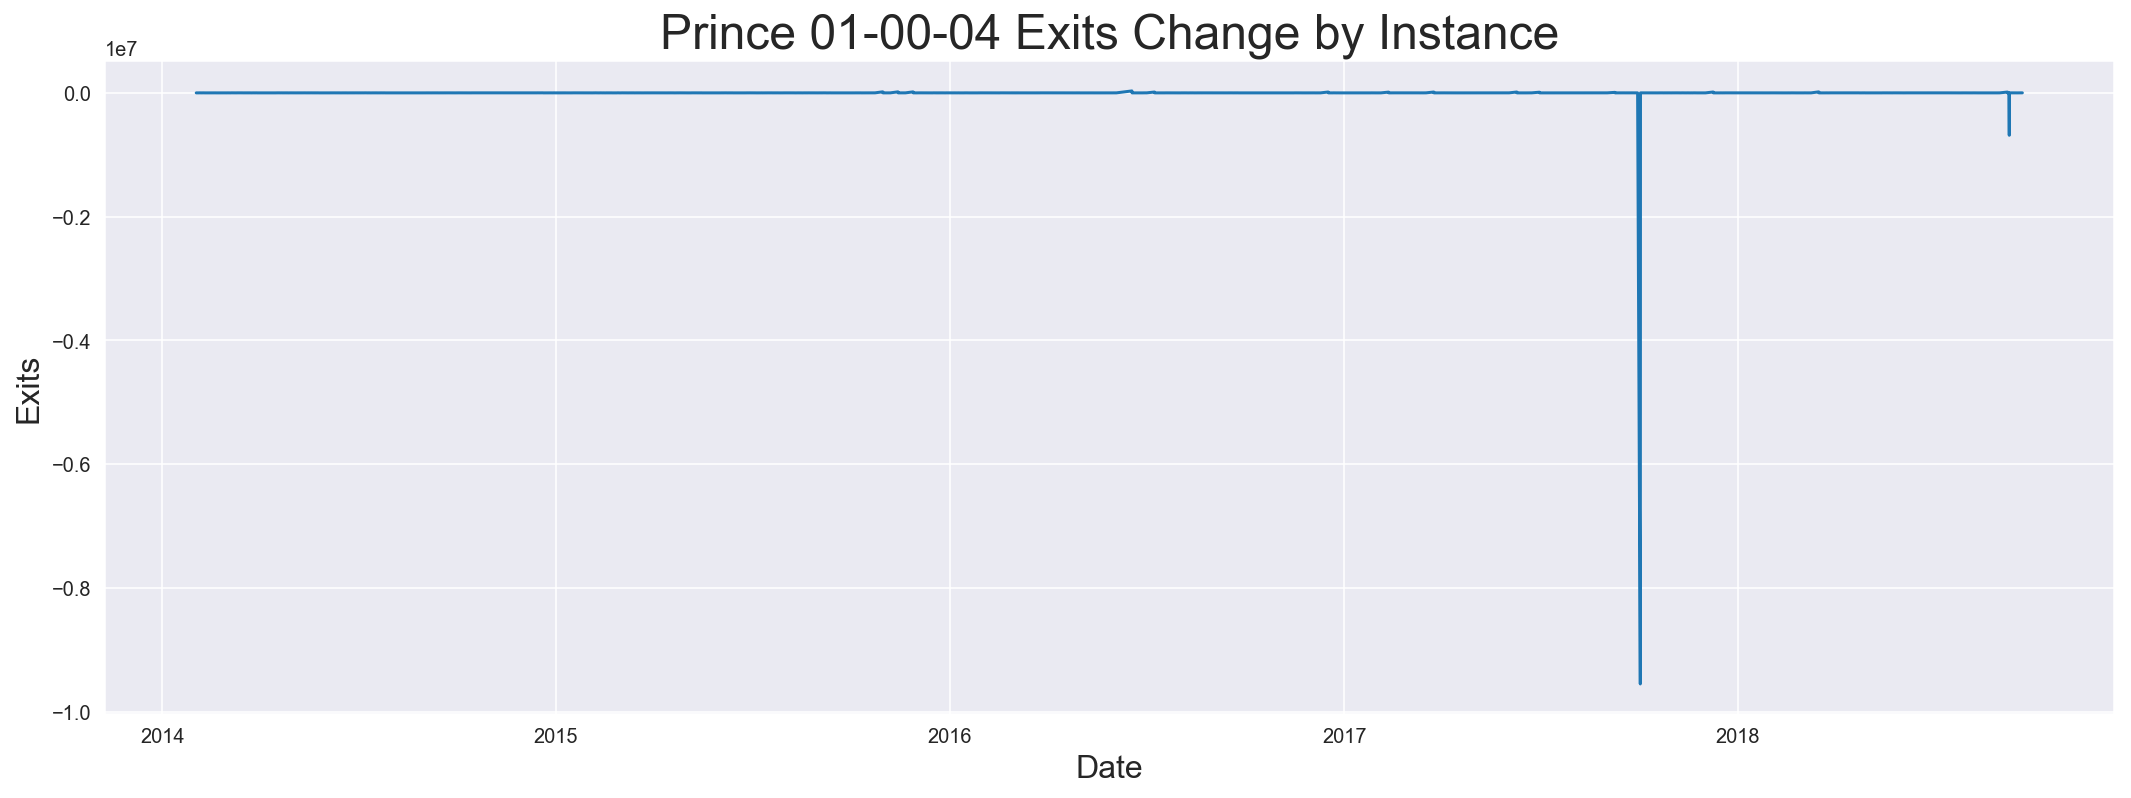

In [92]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010004.datetime,prince_010004.Hourly_Exits);
plt.title('Prince 01-00-04 Exits Change by Instance', fontsize=24);
plt.ylabel('Exits', fontsize=16);
plt.xlabel('Date', fontsize=16);

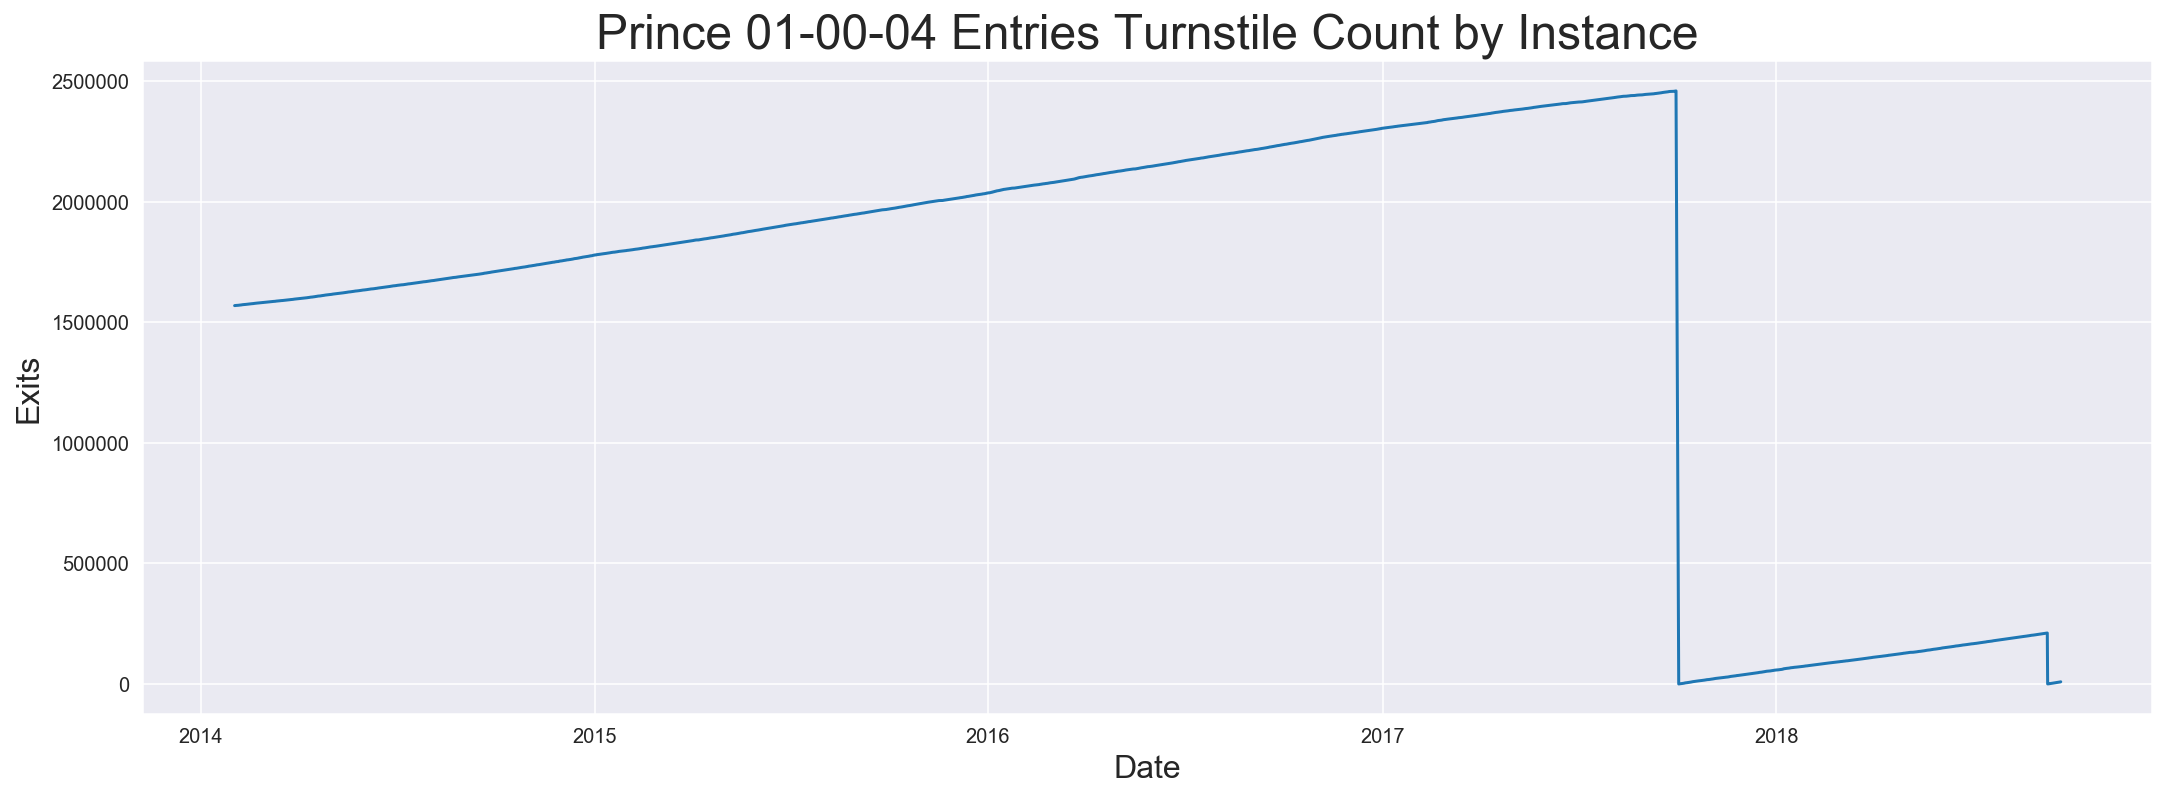

In [93]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010004.datetime,prince_010004.Entries);
plt.title('Prince 01-00-04 Entries Turnstile Count by Instance', fontsize=24);
plt.ylabel('Exits', fontsize=16);
plt.xlabel('Date', fontsize=16);

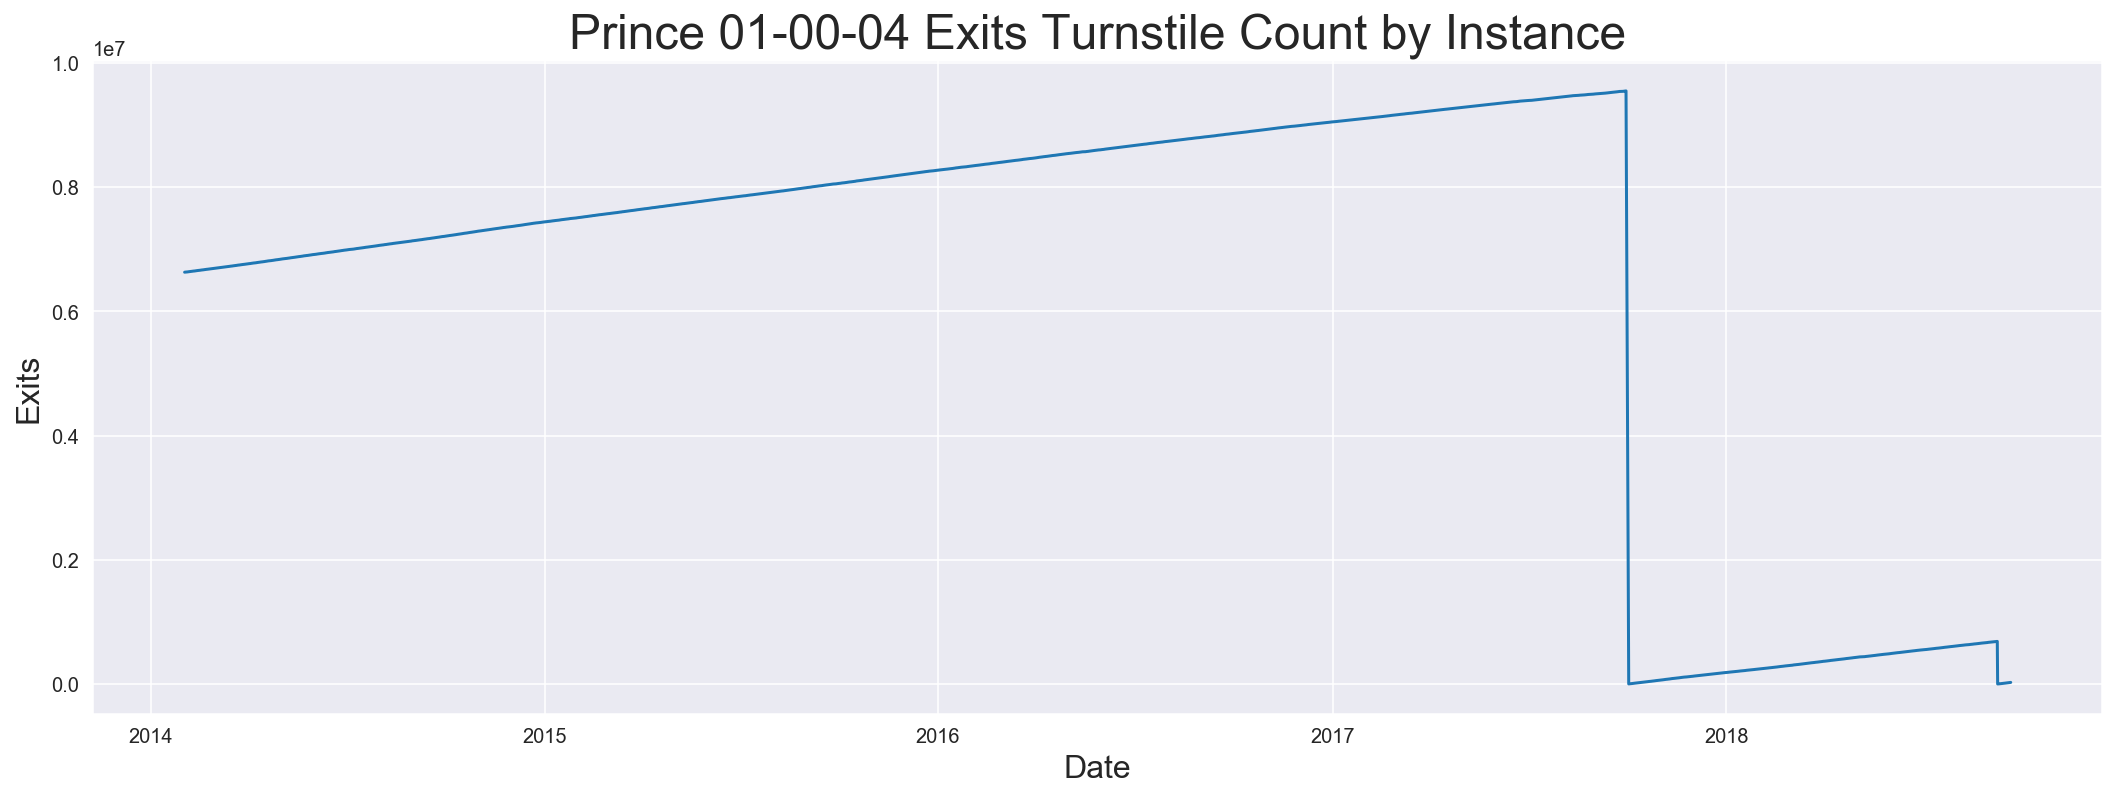

In [94]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010004.datetime,prince_010004.Exits);
plt.title('Prince 01-00-04 Exits Turnstile Count by Instance', fontsize=24);
plt.ylabel('Exits', fontsize=16);
plt.xlabel('Date', fontsize=16);

#### Setting the Negative Hourly block count values to the Turnstile Count

In [95]:
# Reset the index to allow proper indexing for replacement
prince_010004.reset_index(inplace=True)
prince_010004.drop(columns=['index'], inplace=True)

In [96]:
# create a mask to show the negative Hourly count value
prince_010004_neg = prince_010004['Hourly_Entries'] < 0

In [97]:
#show the rows with the negative values 
prince_010004[prince_010004_neg]

level_0   C/A  Unit       SCP    Station LineName Division        Date  \
7696  36945655  A042  R086  01-00-04  PRINCE ST      NRW      BMT  10/02/2017   
9630  46040949  A042  R086  01-00-04  PRINCE ST      NRW      BMT  09/09/2018   

          Time Description  Entries  Exits            datetime  Year  weekday  \
7696  12:00:00     REGULAR       32    980 2017-10-02 12:00:00  2017        0   
9630  16:00:00     REGULAR      219    331 2018-09-09 16:00:00  2018        6   

      Hourly_Entries  Hourly_Exits  traffic  valid  
7696        -2458605      -9550662 12009267  False  
9630         -210976       -685046   896022  False

In [98]:
# Set the values for the Hourly_Entries and Hourly_Exits cells in the affected row to the Turnstile Count
prince_010004.at[7696, 'Hourly_Entries'] = prince_010004.at[7696, 'Entries']
prince_010004.at[7696, 'Hourly_Exits'] = prince_010004.at[7696, 'Exits']
prince_010004.at[9630, 'Hourly_Entries'] = prince_010004.at[9630, 'Entries']
prince_010004.at[9630, 'Hourly_Exits'] = prince_010004.at[9630, 'Exits']

In [99]:
# Show the values of the updated cells
print(prince_010004.at[7696, 'Hourly_Entries'])
print(prince_010004.at[7696, 'Hourly_Exits'])
print(prince_010004.at[9630, 'Hourly_Entries'])
print(prince_010004.at[9630, 'Hourly_Exits'])

32.0
980.0
219.0
331.0


### Combine Entries and Exits Hourly Blocks into a total traffic value for each Turnstile

In [100]:
hourly = ['Hourly_Entries', 'Hourly_Exits']

In [101]:
prince_000000['traffic'] = prince_000000[hourly].sum(axis=1)
prince_000004['traffic'] = prince_000004[hourly].sum(axis=1)
prince_000002['traffic'] = prince_000002[hourly].sum(axis=1)
prince_000003['traffic'] = prince_000003[hourly].sum(axis=1)
prince_000001['traffic'] = prince_000001[hourly].sum(axis=1)
prince_010002['traffic'] = prince_010002[hourly].sum(axis=1)
prince_010000['traffic'] = prince_010000[hourly].sum(axis=1) 
prince_010003['traffic'] = prince_010003[hourly].sum(axis=1)
prince_010001['traffic'] = prince_010001[hourly].sum(axis=1)
prince_010004['traffic'] = prince_010004[hourly].sum(axis=1)
prince_000700['traffic'] = prince_000700[hourly].sum(axis=1) 
prince_010400['traffic'] = prince_010400[hourly].sum(axis=1)
prince_010700['traffic'] = prince_010700[hourly].sum(axis=1)
prince_000400['traffic'] = prince_000400[hourly].sum(axis=1) 
prince_000701['traffic'] = prince_000701[hourly].sum(axis=1)

In [102]:
prince_000000_daily = pd.DataFrame(prince_000000.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_000004_daily = pd.DataFrame(prince_000004.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_000002_daily = pd.DataFrame(prince_000002.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_000003_daily = pd.DataFrame(prince_000003.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_000001_daily = pd.DataFrame(prince_000001.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_010002_daily = pd.DataFrame(prince_010002.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_010000_daily = pd.DataFrame(prince_010000.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_010003_daily = pd.DataFrame(prince_010003.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_010001_daily = pd.DataFrame(prince_010001.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_010004_daily = pd.DataFrame(prince_010004.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_000700_daily = pd.DataFrame(prince_000700.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_010400_daily = pd.DataFrame(prince_010400.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_010700_daily = pd.DataFrame(prince_010700.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_000400_daily = pd.DataFrame(prince_000400.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())
prince_000701_daily = pd.DataFrame(prince_000701.groupby(['Unit','C/A','SCP','Date','weekday','Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum())

In [103]:
prince_000000_daily.head()

traffic  Hourly_Entries  \
Unit C/A  SCP      Date       weekday Year                            
R086 A041 00-00-00 01/01/2015 3       2015     2215            1493   
                   01/01/2016 4       2015     2253            1577   
                   01/01/2017 6       2017     1927            1375   
                   01/01/2018 0       2018     1753            1181   
                   01/02/2015 4       2015     3740            2548   

                                            Hourly_Exits  
Unit C/A  SCP      Date       weekday Year                
R086 A041 00-00-00 01/01/2015 3       2015           722  
                   01/01/2016 4       2015           676  
                   01/01/2017 6       2017           552  
                   01/01/2018 0       2018           572  
                   01/02/2015 4       2015          1192

In [104]:
prince_000000_daily.reset_index(inplace=True)
prince_000004_daily.reset_index(inplace=True)
prince_000002_daily.reset_index(inplace=True)
prince_000003_daily.reset_index(inplace=True)
prince_000001_daily.reset_index(inplace=True)
prince_010002_daily.reset_index(inplace=True)
prince_010000_daily.reset_index(inplace=True)
prince_010003_daily.reset_index(inplace=True)
prince_010001_daily.reset_index(inplace=True)
prince_010004_daily.reset_index(inplace=True)
prince_000700_daily.reset_index(inplace=True)
prince_010400_daily.reset_index(inplace=True)
prince_010700_daily.reset_index(inplace=True)
prince_000400_daily.reset_index(inplace=True)
prince_000701_daily.reset_index(inplace=True)

In [105]:
prince_000000_daily['Date'] = pd.to_datetime(prince_000000_daily['Date'])
prince_000004_daily['Date'] = pd.to_datetime(prince_000004_daily['Date'])
prince_000002_daily['Date'] = pd.to_datetime(prince_000002_daily['Date'])
prince_000003_daily['Date'] = pd.to_datetime(prince_000003_daily['Date'])
prince_000001_daily['Date'] = pd.to_datetime(prince_000001_daily['Date'])
prince_010002_daily['Date'] = pd.to_datetime(prince_010002_daily['Date'])
prince_010000_daily['Date'] = pd.to_datetime(prince_010000_daily['Date'])
prince_010003_daily['Date'] = pd.to_datetime(prince_010003_daily['Date'])
prince_010001_daily['Date'] = pd.to_datetime(prince_010001_daily['Date'])
prince_010004_daily['Date'] = pd.to_datetime(prince_010004_daily['Date'])
prince_000700_daily['Date'] = pd.to_datetime(prince_000700_daily['Date'])
prince_010400_daily['Date'] = pd.to_datetime(prince_010400_daily['Date'])
prince_010700_daily['Date'] = pd.to_datetime(prince_010700_daily['Date'])
prince_000400_daily['Date'] = pd.to_datetime(prince_000400_daily['Date'])
prince_000701_daily['Date'] = pd.to_datetime(prince_000701_daily['Date'])

In [106]:
prince_000000_daily.sort_values(['Date'], inplace=True)
prince_000004_daily.sort_values(['Date'], inplace=True)
prince_000002_daily.sort_values(['Date'], inplace=True)
prince_000003_daily.sort_values(['Date'], inplace=True)
prince_000001_daily.sort_values(['Date'], inplace=True)
prince_010002_daily.sort_values(['Date'], inplace=True)
prince_010000_daily.sort_values(['Date'], inplace=True)
prince_010003_daily.sort_values(['Date'], inplace=True)
prince_010001_daily.sort_values(['Date'], inplace=True)
prince_010004_daily.sort_values(['Date'], inplace=True)
prince_000700_daily.sort_values(['Date'], inplace=True)
prince_010400_daily.sort_values(['Date'], inplace=True)
prince_010700_daily.sort_values(['Date'], inplace=True)
prince_000400_daily.sort_values(['Date'], inplace=True)
prince_000701_daily.sort_values(['Date'], inplace=True)

In [107]:
prince_000000_daily.reset_index(inplace=True)
prince_000004_daily.reset_index(inplace=True)
prince_000002_daily.reset_index(inplace=True)
prince_000003_daily.reset_index(inplace=True)
prince_000001_daily.reset_index(inplace=True)
prince_010002_daily.reset_index(inplace=True)
prince_010000_daily.reset_index(inplace=True)
prince_010003_daily.reset_index(inplace=True)
prince_010001_daily.reset_index(inplace=True)
prince_010004_daily.reset_index(inplace=True)
prince_000700_daily.reset_index(inplace=True)
prince_010400_daily.reset_index(inplace=True)
prince_010700_daily.reset_index(inplace=True)
prince_000400_daily.reset_index(inplace=True)
prince_000701_daily.reset_index(inplace=True)

In [108]:
prince_000000_daily.drop(columns=['index'], inplace=True)
prince_000004_daily.drop(columns=['index'], inplace=True)
prince_000002_daily.drop(columns=['index'], inplace=True)
prince_000003_daily.drop(columns=['index'], inplace=True)
prince_000001_daily.drop(columns=['index'], inplace=True)
prince_010002_daily.drop(columns=['index'], inplace=True)
prince_010000_daily.drop(columns=['index'], inplace=True)
prince_010003_daily.drop(columns=['index'], inplace=True)
prince_010001_daily.drop(columns=['index'], inplace=True)
prince_010004_daily.drop(columns=['index'], inplace=True)
prince_000700_daily.drop(columns=['index'], inplace=True)
prince_010400_daily.drop(columns=['index'], inplace=True)
prince_010700_daily.drop(columns=['index'], inplace=True)
prince_000400_daily.drop(columns=['index'], inplace=True)
prince_000701_daily.drop(columns=['index'], inplace=True)

# Individual Turnstile Investigation

There were 15 different Turnstiles in use between Feb 2014 - Sep 2018.  The missing weeks are a system wide issue not tied to an individual turnstile.  Below is a combined graph shpwing all turnstile overlaid with eachother to show that the missing weeks are the same for all turnstile.  Following are charts showing Entrances for each Individual Turnstile over the oberservation period.

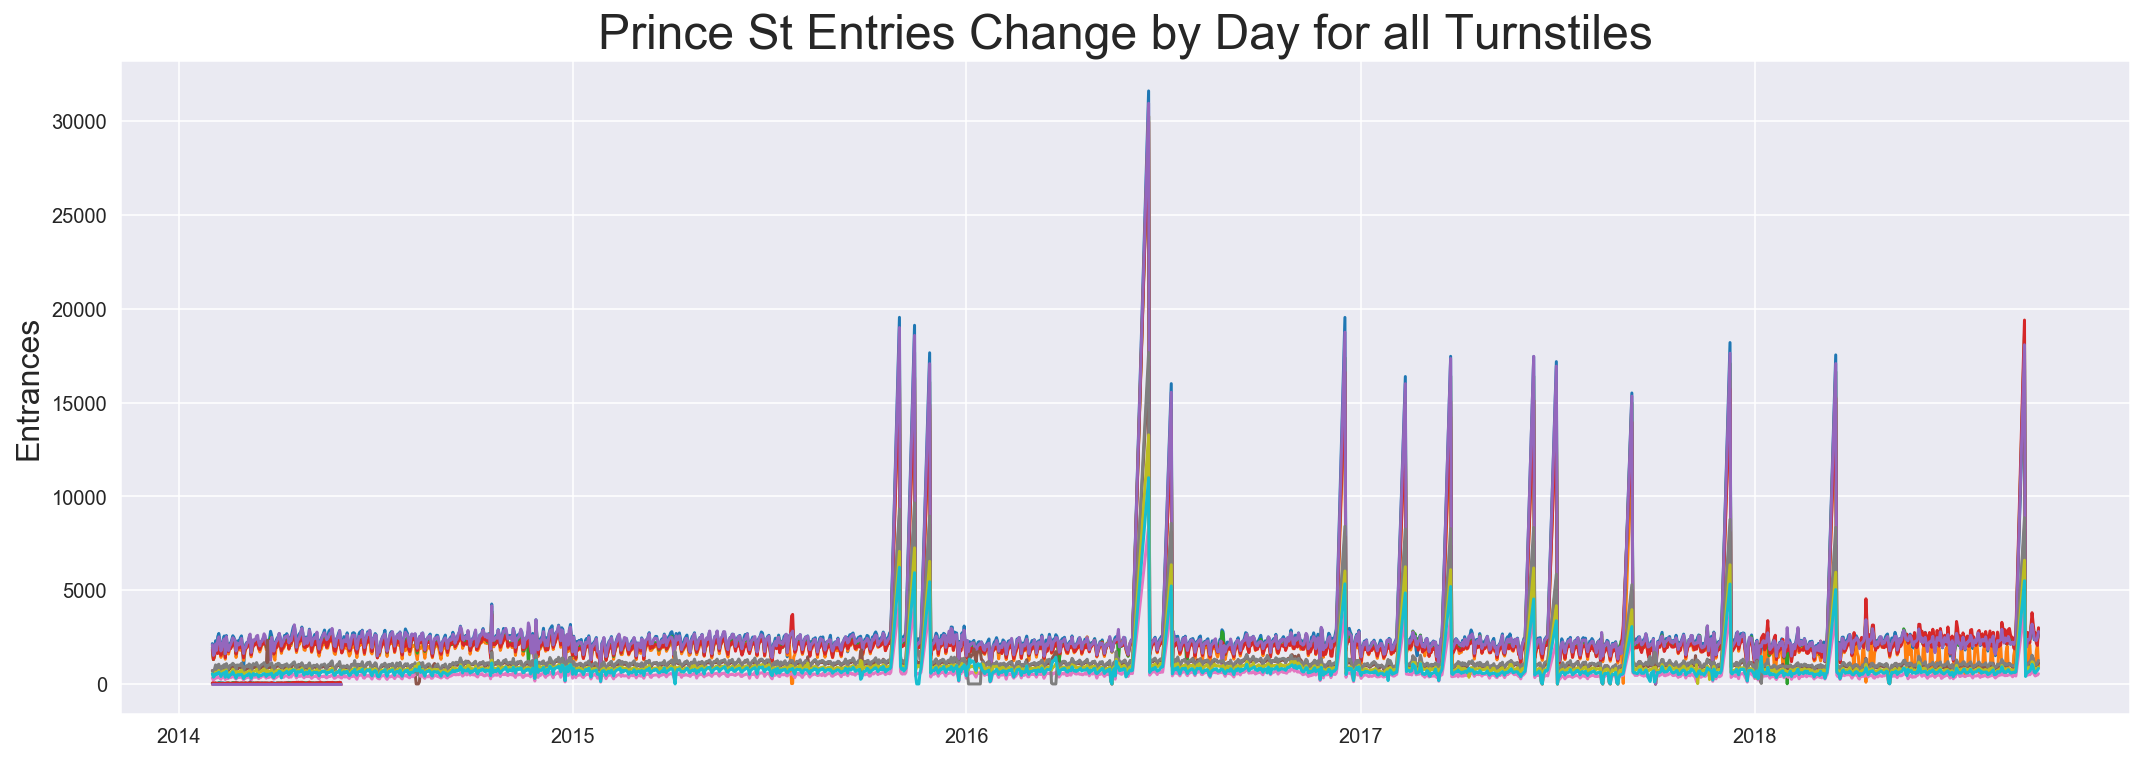

In [110]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000000_daily.Date,prince_000000_daily.Hourly_Entries);
sns.lineplot(prince_000004_daily.Date,prince_000004_daily.Hourly_Entries);
sns.lineplot(prince_000002_daily.Date,prince_000002_daily.Hourly_Entries);
sns.lineplot(prince_000003_daily.Date,prince_000003_daily.Hourly_Entries);
sns.lineplot(prince_000001_daily.Date,prince_000001_daily.Hourly_Entries);
sns.lineplot(prince_010002_daily.Date,prince_010002_daily.Hourly_Entries);
sns.lineplot(prince_010000_daily.Date,prince_010000_daily.Hourly_Entries);
sns.lineplot(prince_010003_daily.Date,prince_010003_daily.Hourly_Entries);
sns.lineplot(prince_010001_daily.Date,prince_010001_daily.Hourly_Entries);
sns.lineplot(prince_010004_daily.Date,prince_010004_daily.Hourly_Entries);
sns.lineplot(prince_000700_daily.Date,prince_000700_daily.Hourly_Entries);
sns.lineplot(prince_010400_daily.Date,prince_010400_daily.Hourly_Entries);
sns.lineplot(prince_010700_daily.Date,prince_010700_daily.Hourly_Entries);
sns.lineplot(prince_000400_daily.Date,prince_000400_daily.Hourly_Entries);
sns.lineplot(prince_000701_daily.Date,prince_000701_daily.Hourly_Entries);
plt.title('Prince St Entries Change by Day for all Turnstiles', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('', fontsize=16);

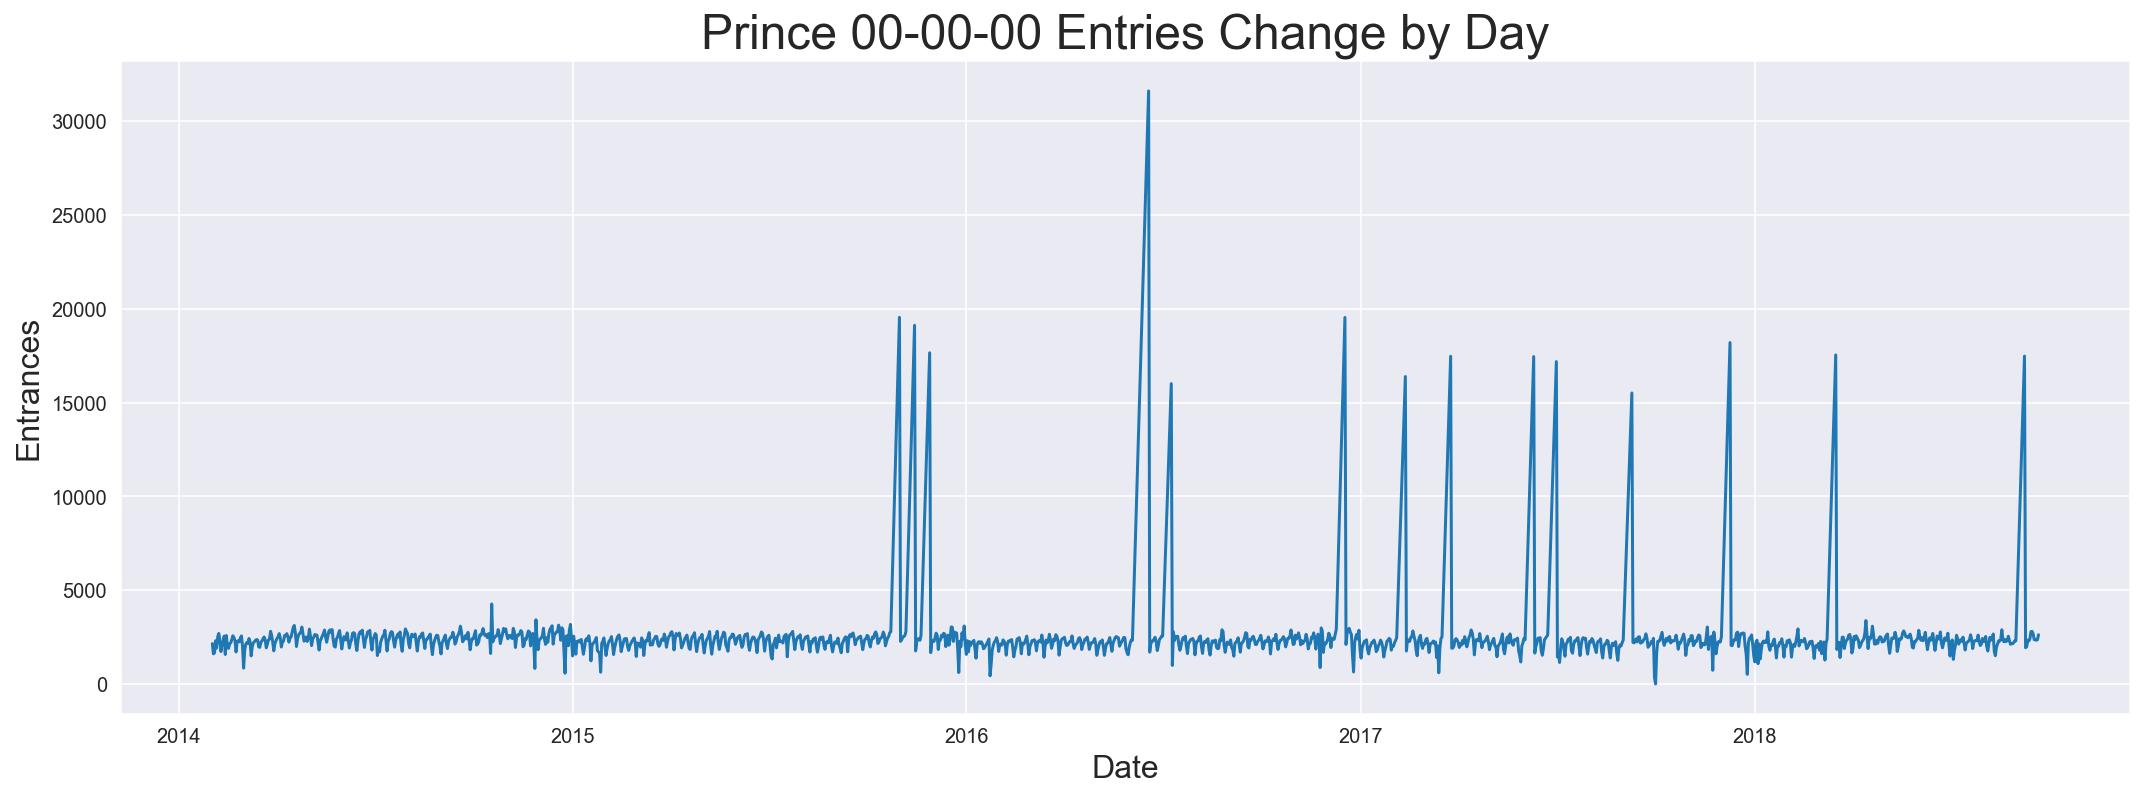

In [111]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000000_daily.Date,prince_000000_daily.Hourly_Entries);
plt.title('Prince 00-00-00 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

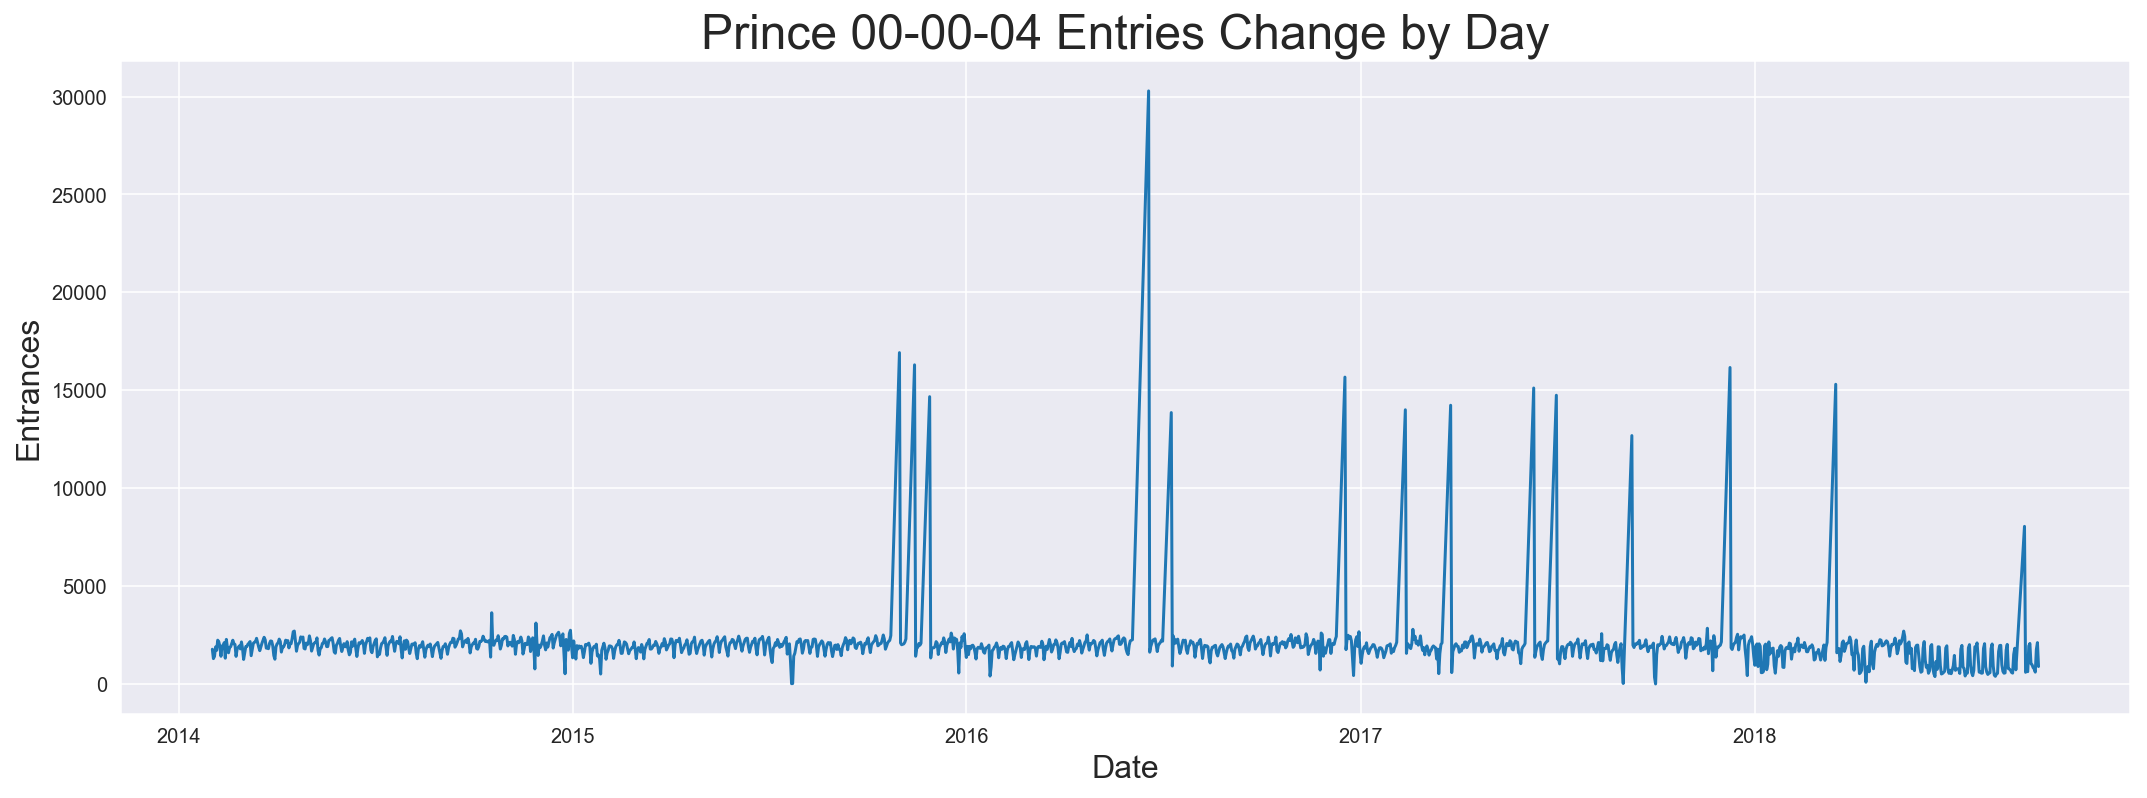

In [112]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000004_daily.Date,prince_000004_daily.Hourly_Entries);
plt.title('Prince 00-00-04 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

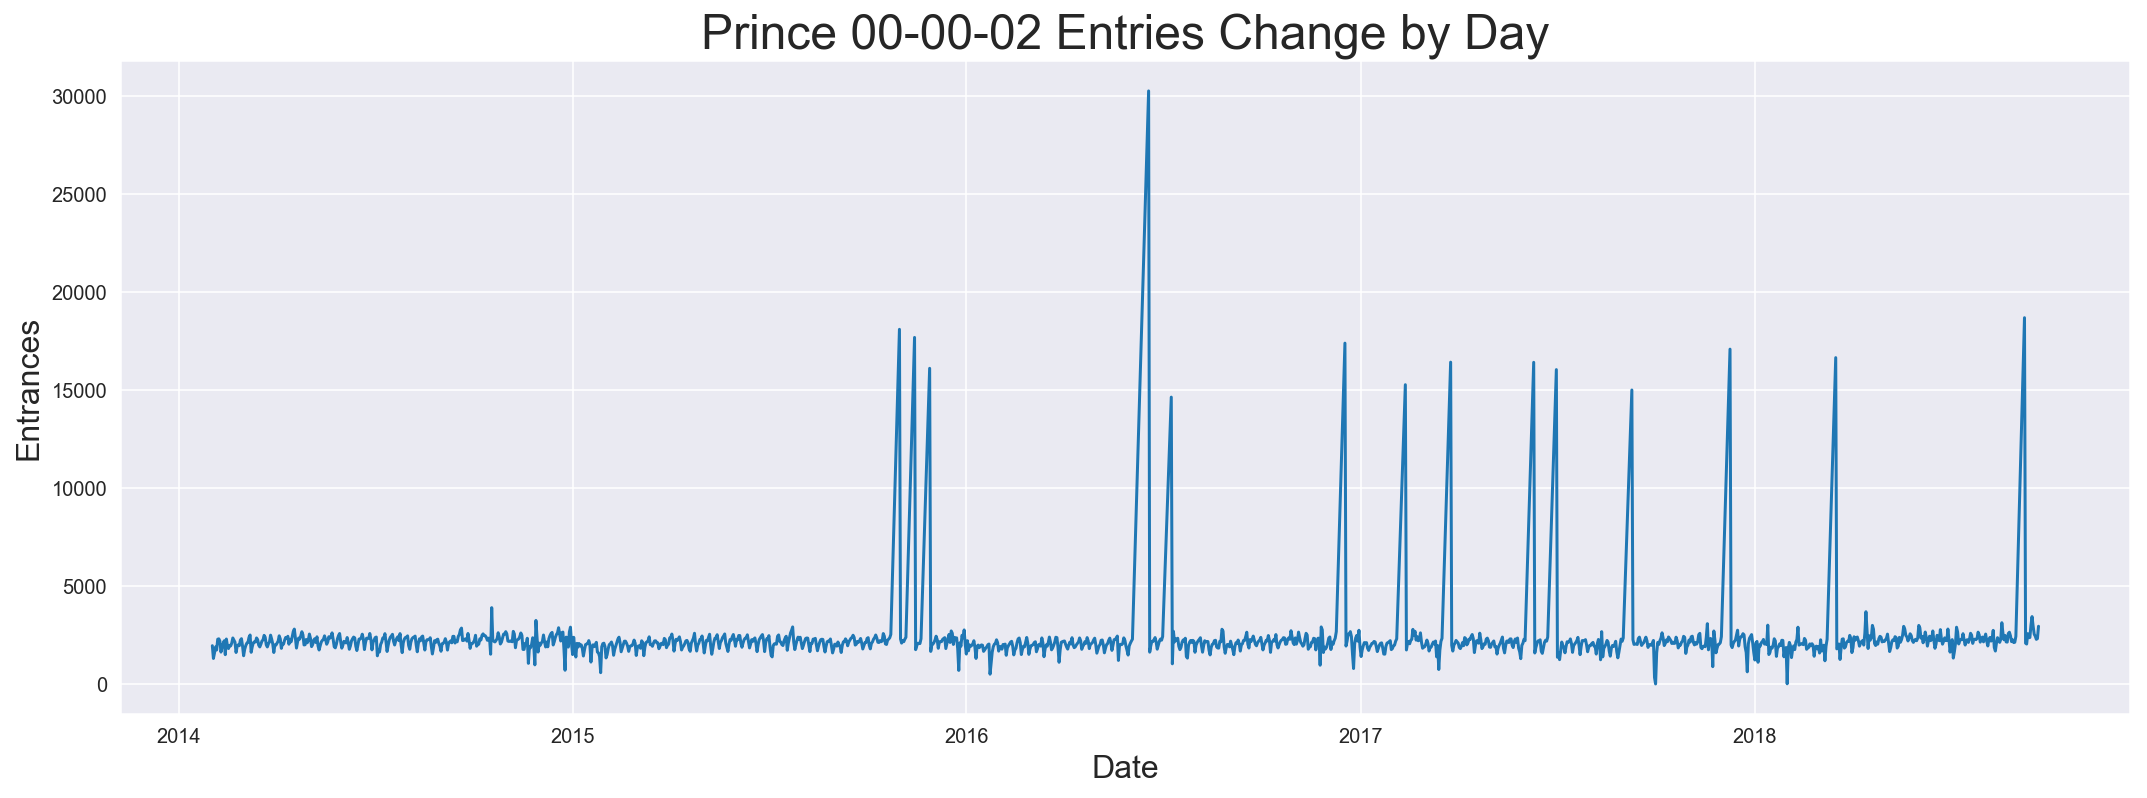

In [113]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000002_daily.Date,prince_000002_daily.Hourly_Entries);
plt.title('Prince 00-00-02 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

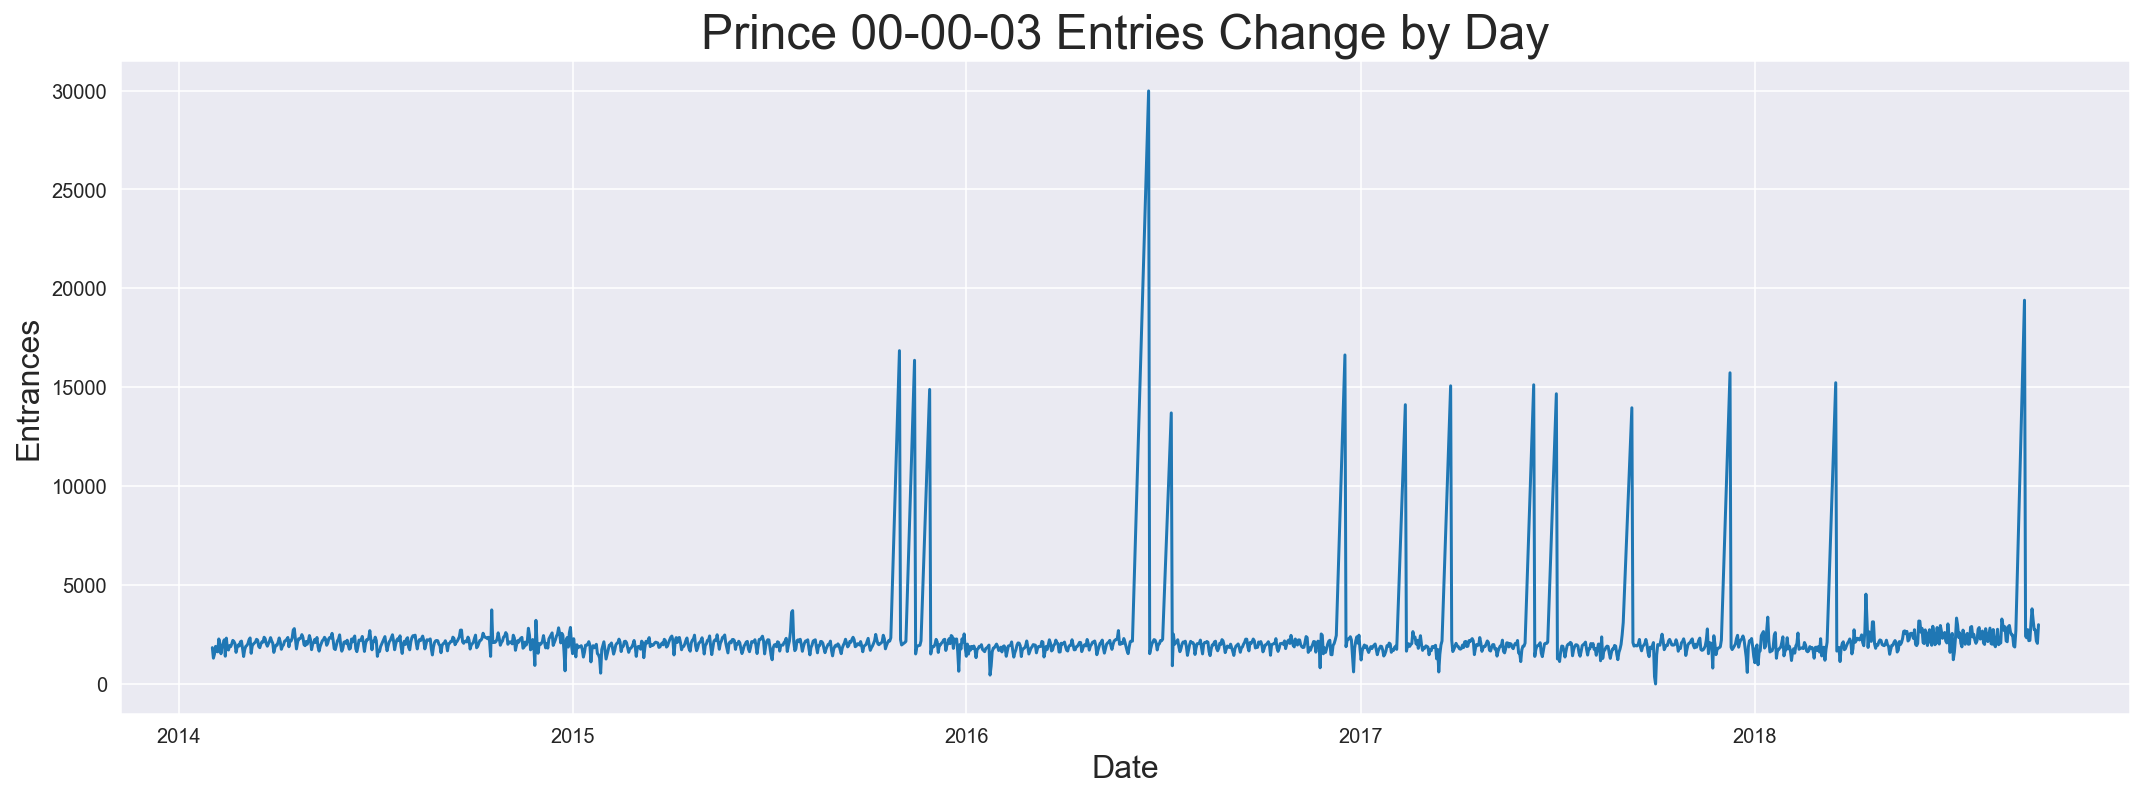

In [114]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000003_daily.Date,prince_000003_daily.Hourly_Entries);
plt.title('Prince 00-00-03 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

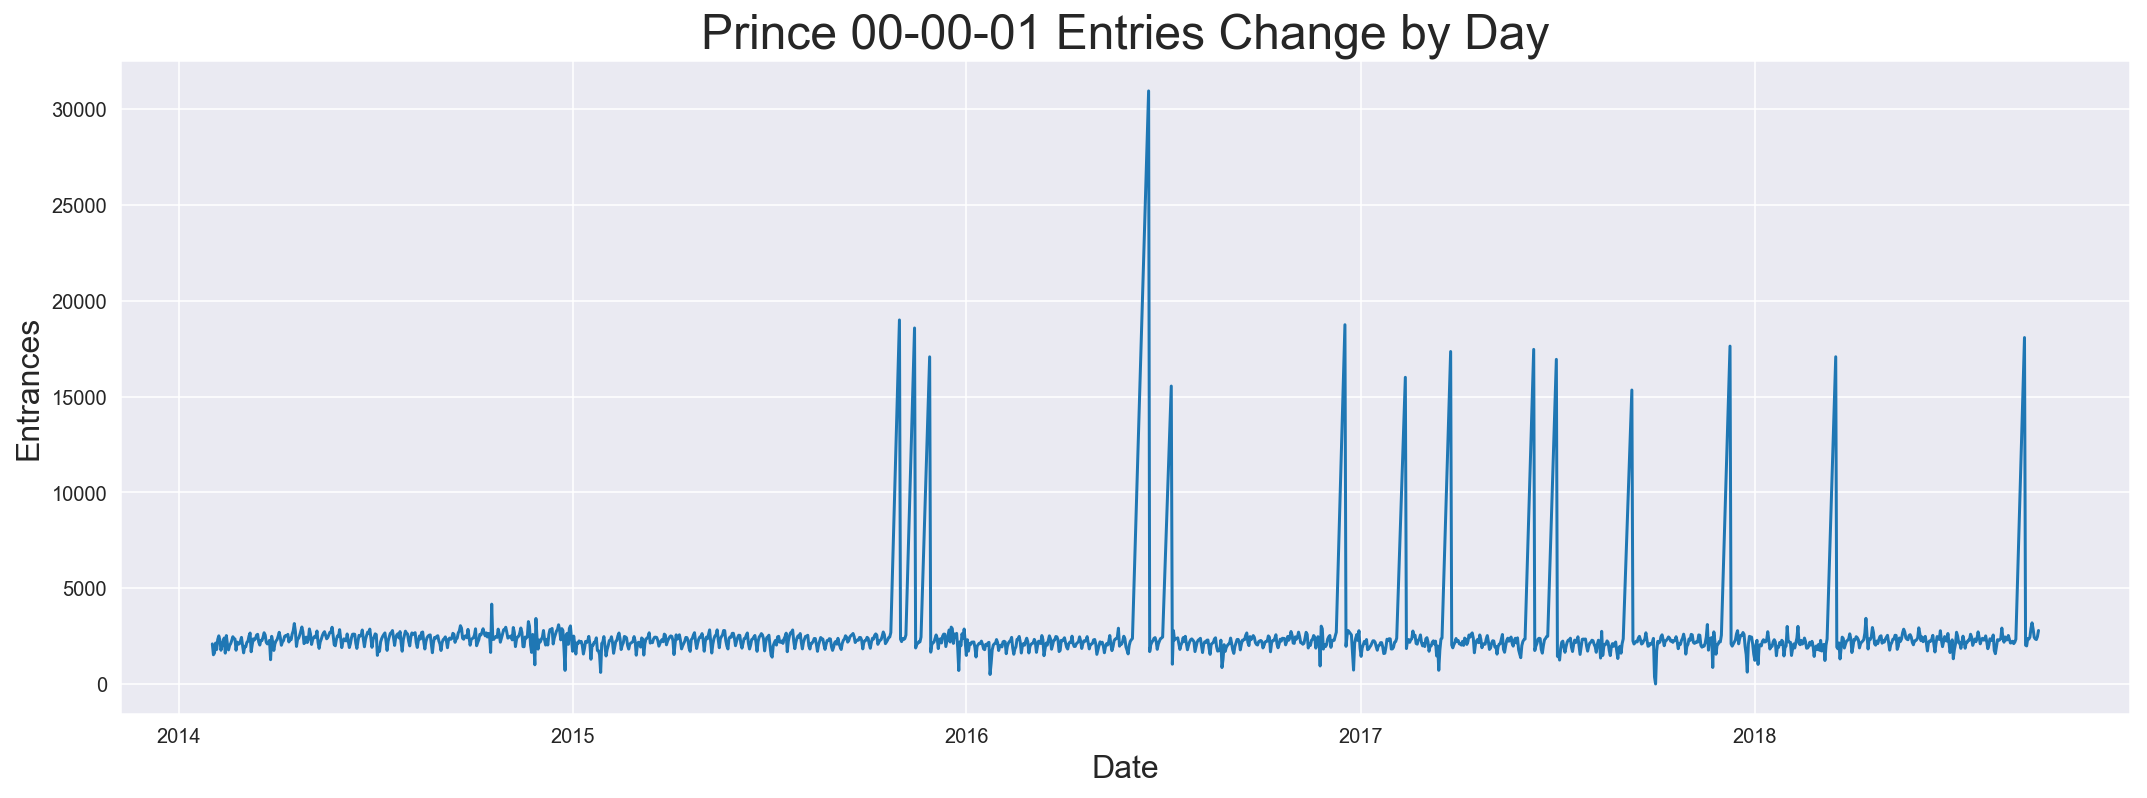

In [115]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000001_daily.Date,prince_000001_daily.Hourly_Entries);
plt.title('Prince 00-00-01 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

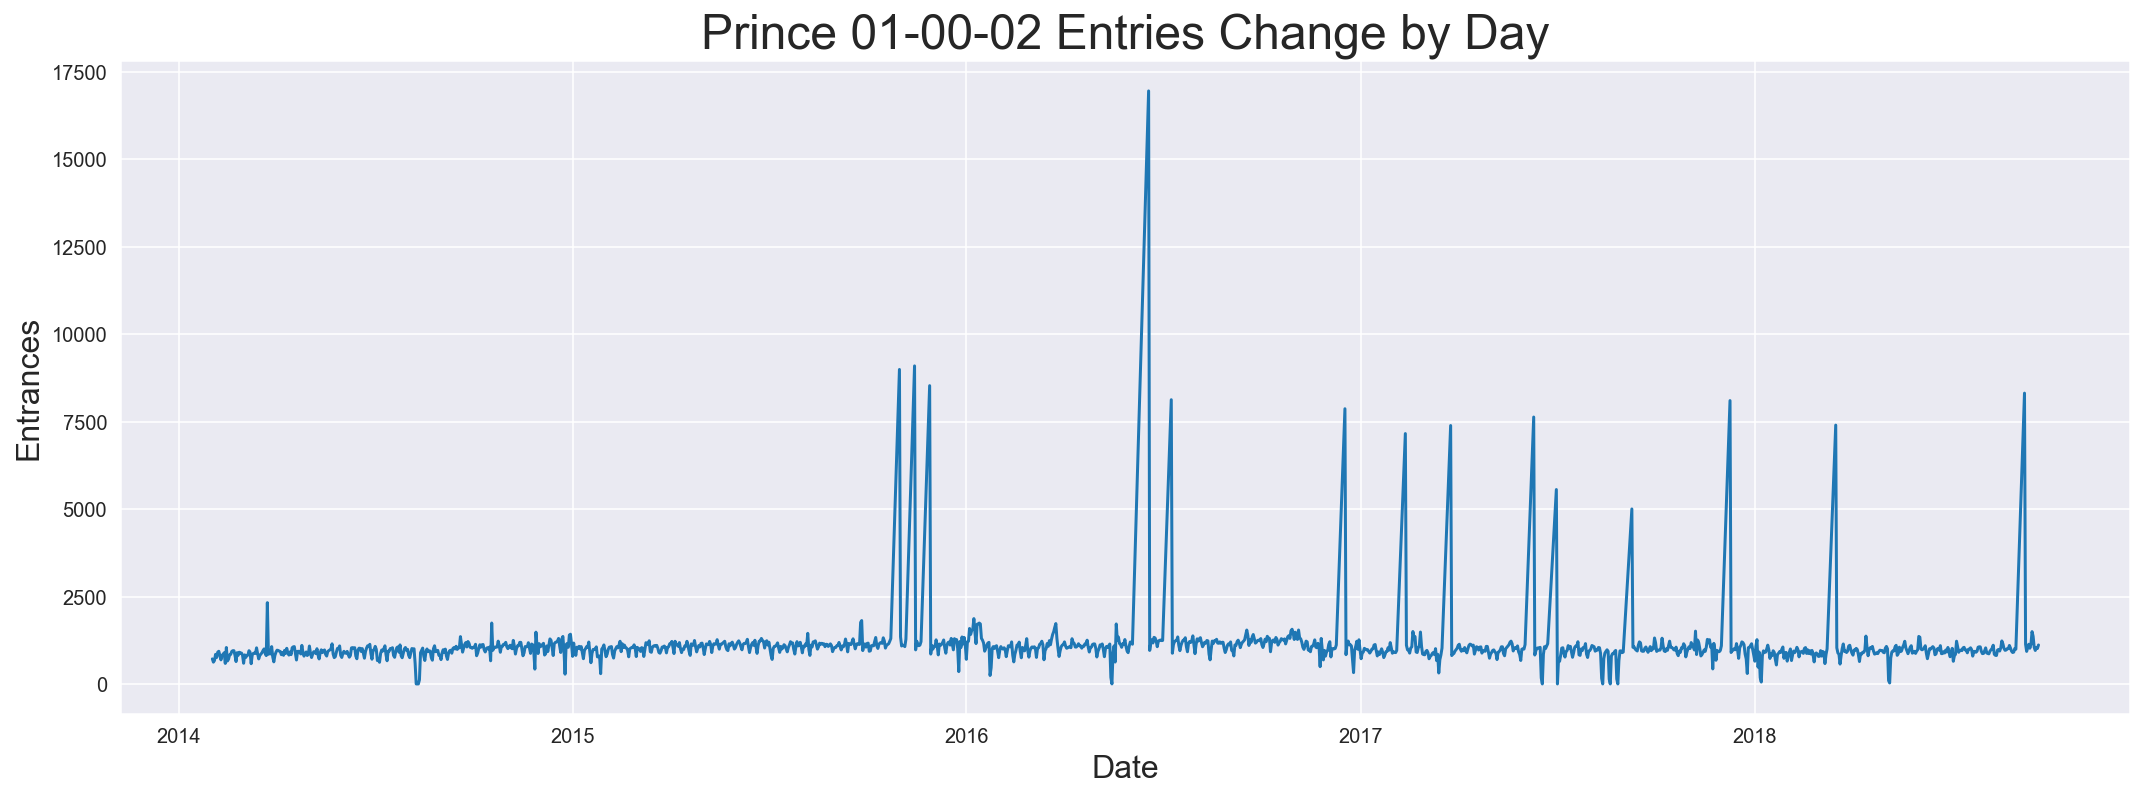

In [116]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010002_daily.Date,prince_010002_daily.Hourly_Entries);
plt.title('Prince 01-00-02 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

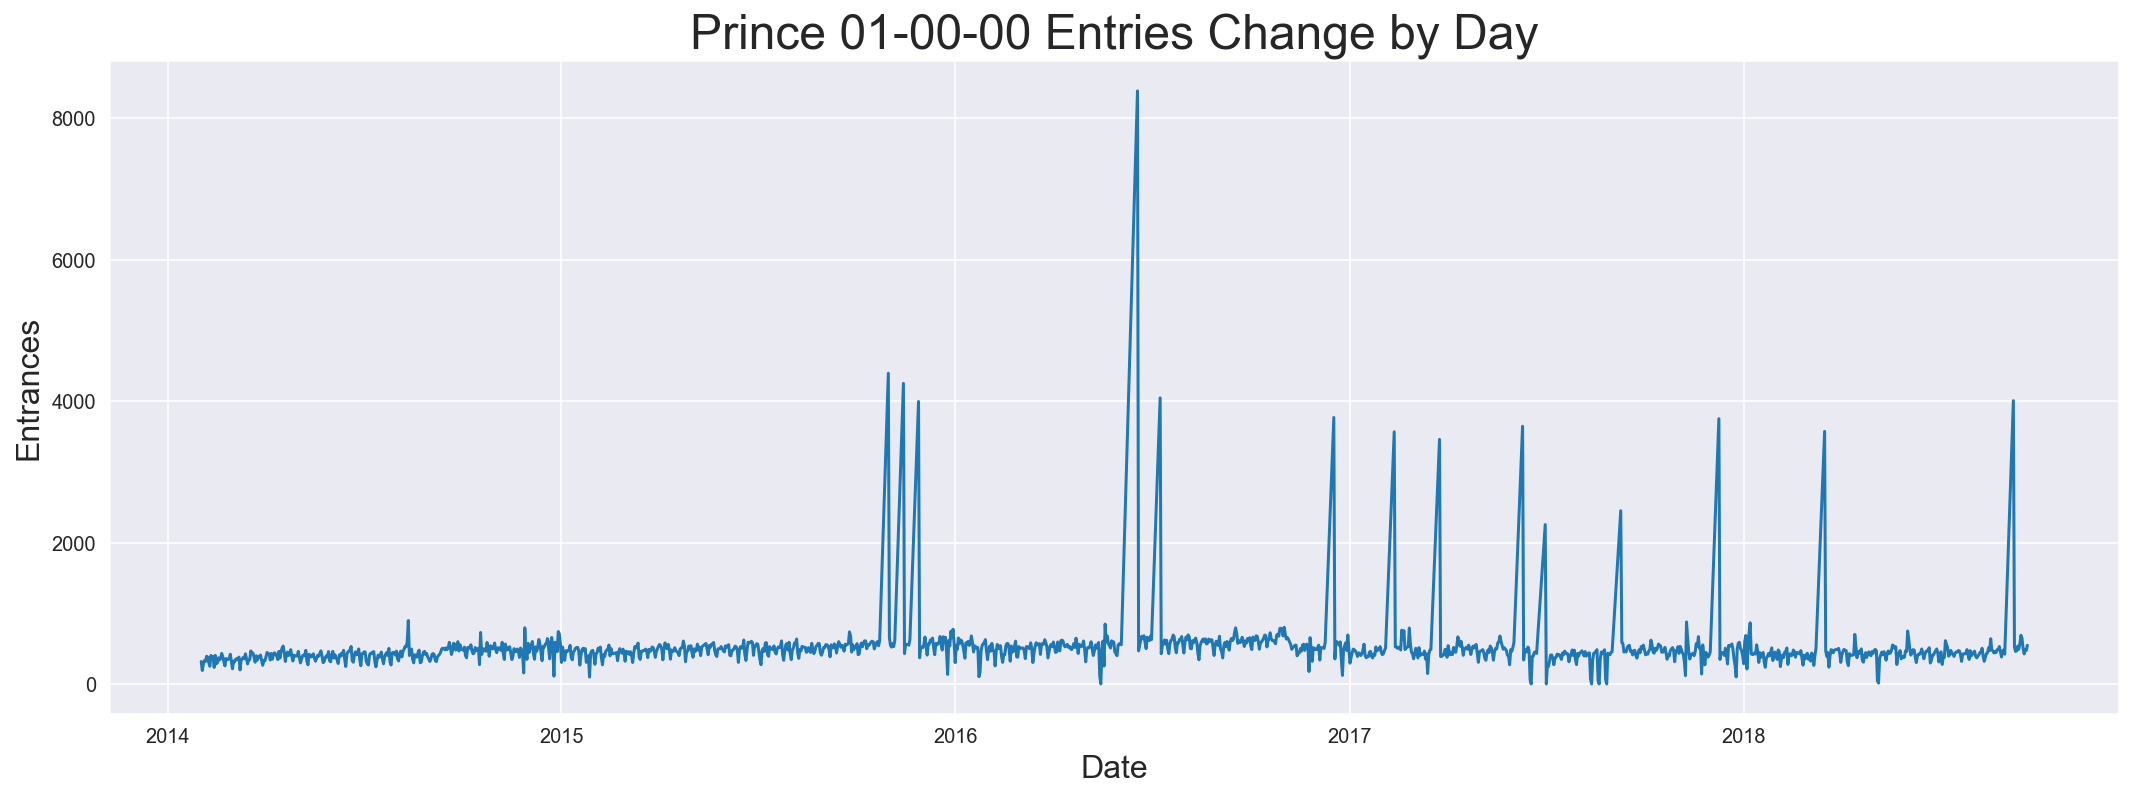

In [117]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010000_daily.Date,prince_010000_daily.Hourly_Entries);
plt.title('Prince 01-00-00 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

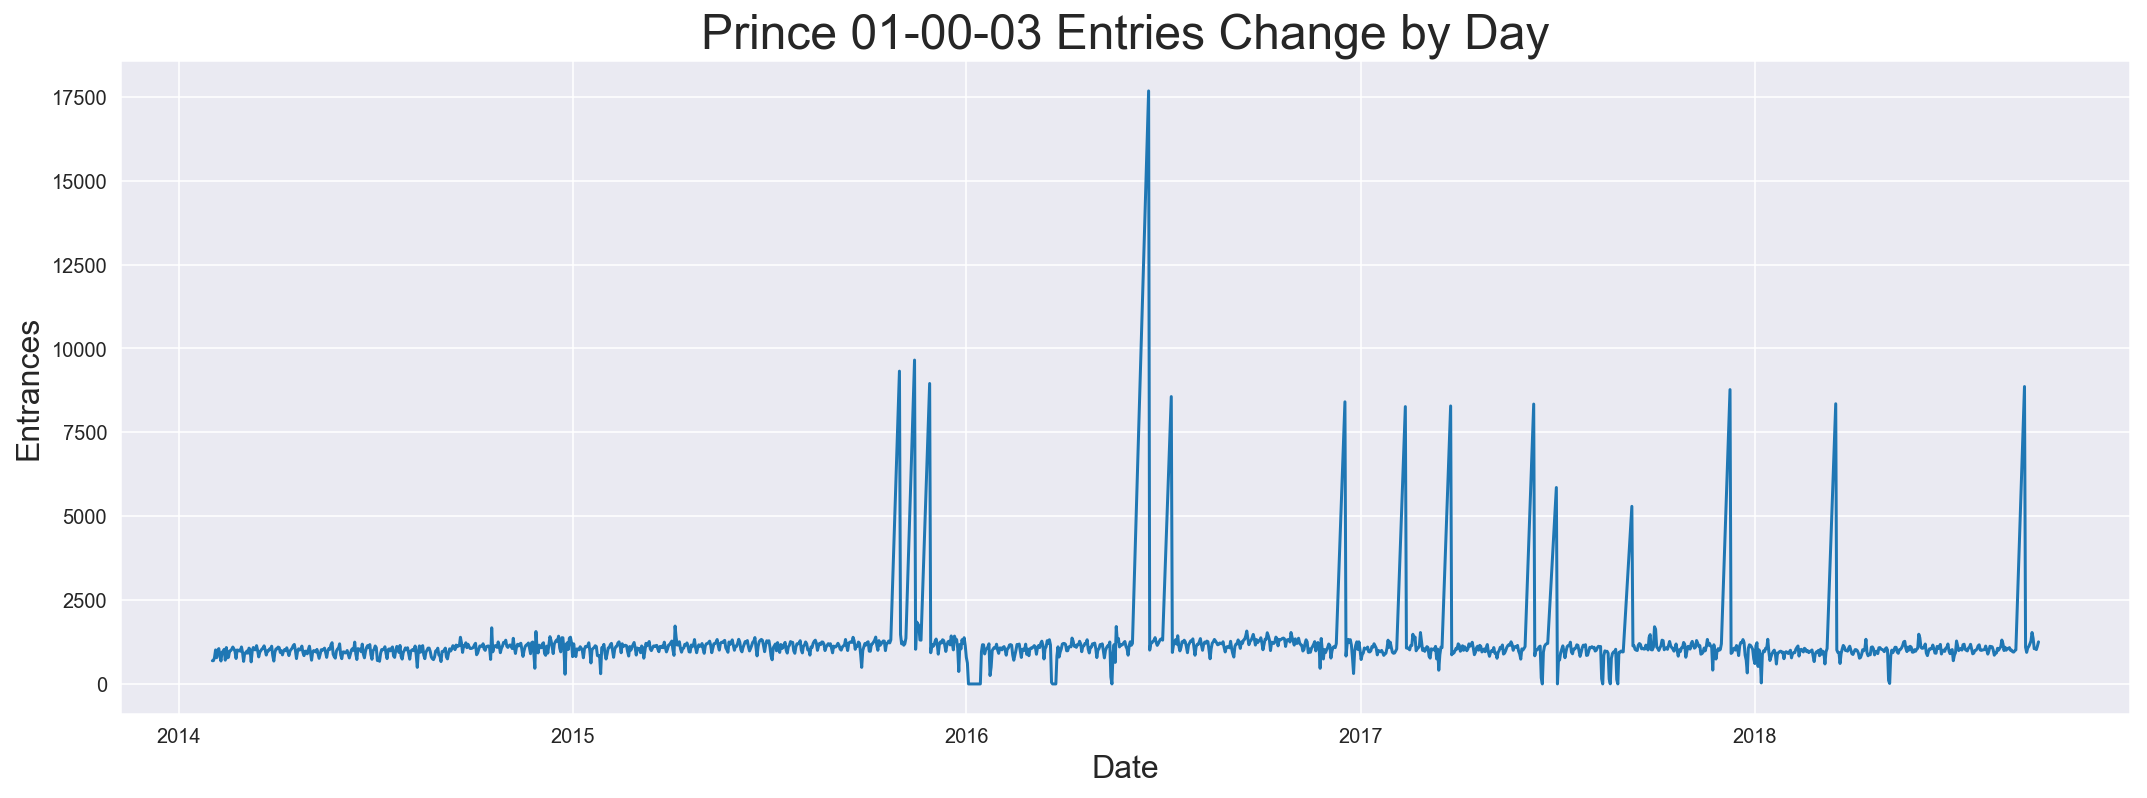

In [118]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010003_daily.Date,prince_010003_daily.Hourly_Entries);
plt.title('Prince 01-00-03 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

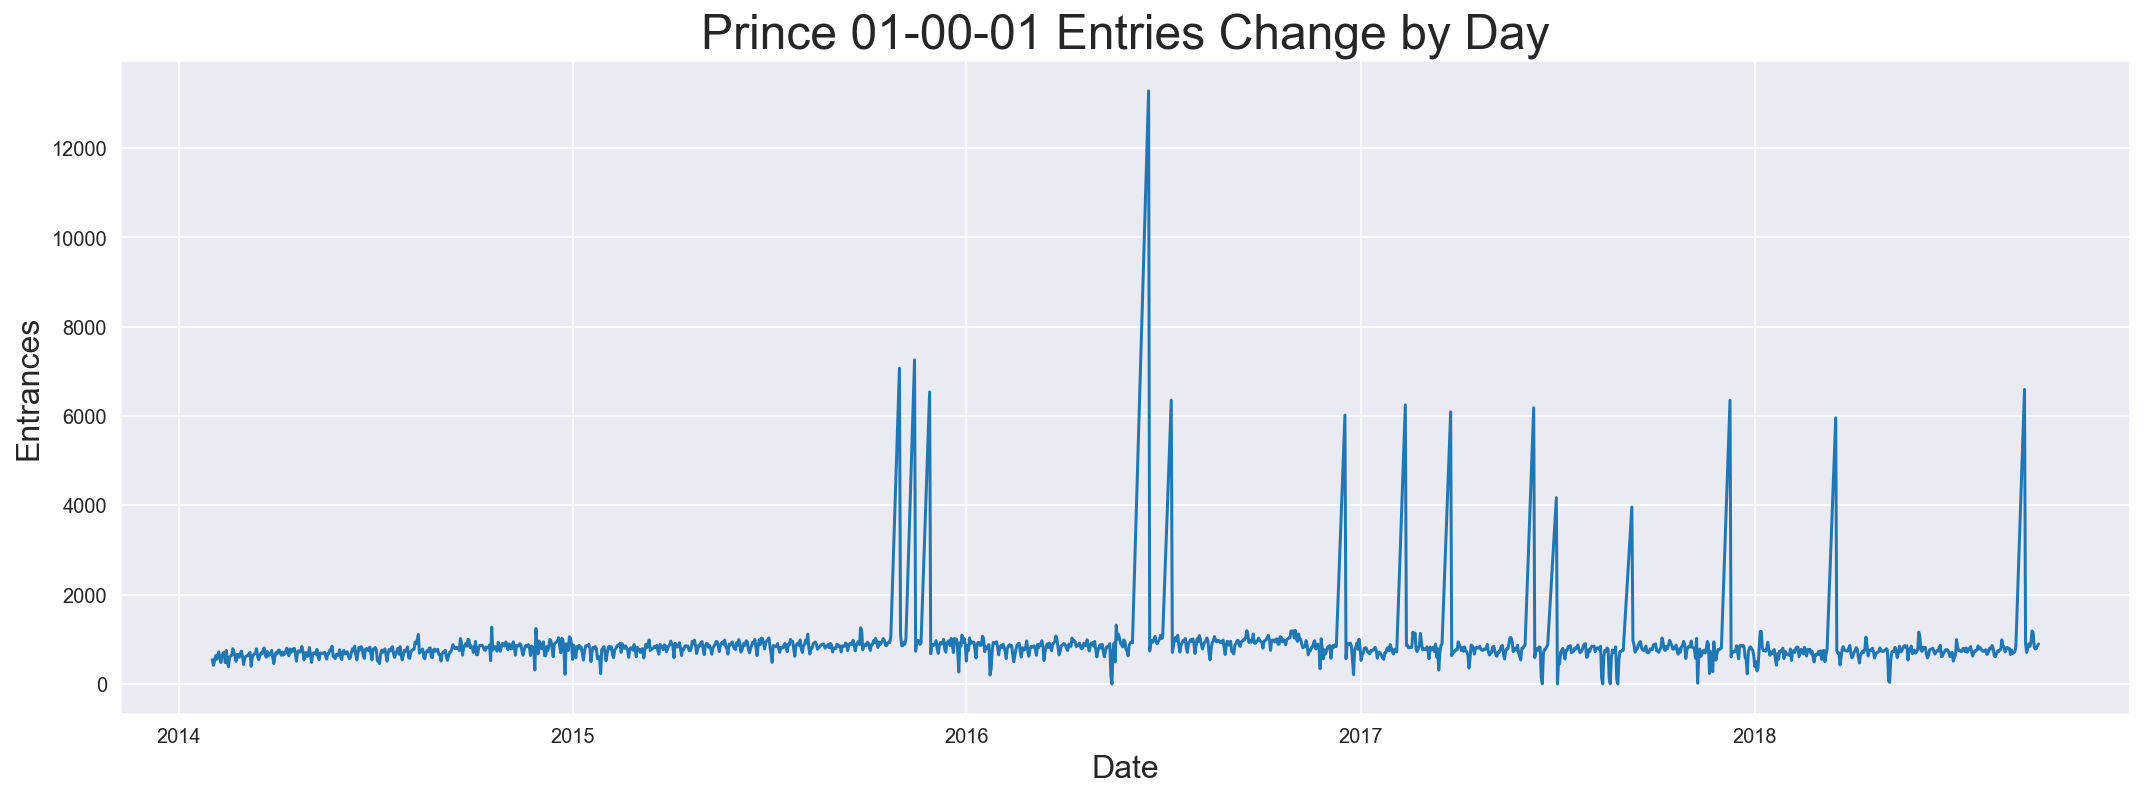

In [119]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010001_daily.Date,prince_010001_daily.Hourly_Entries);
plt.title('Prince 01-00-01 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

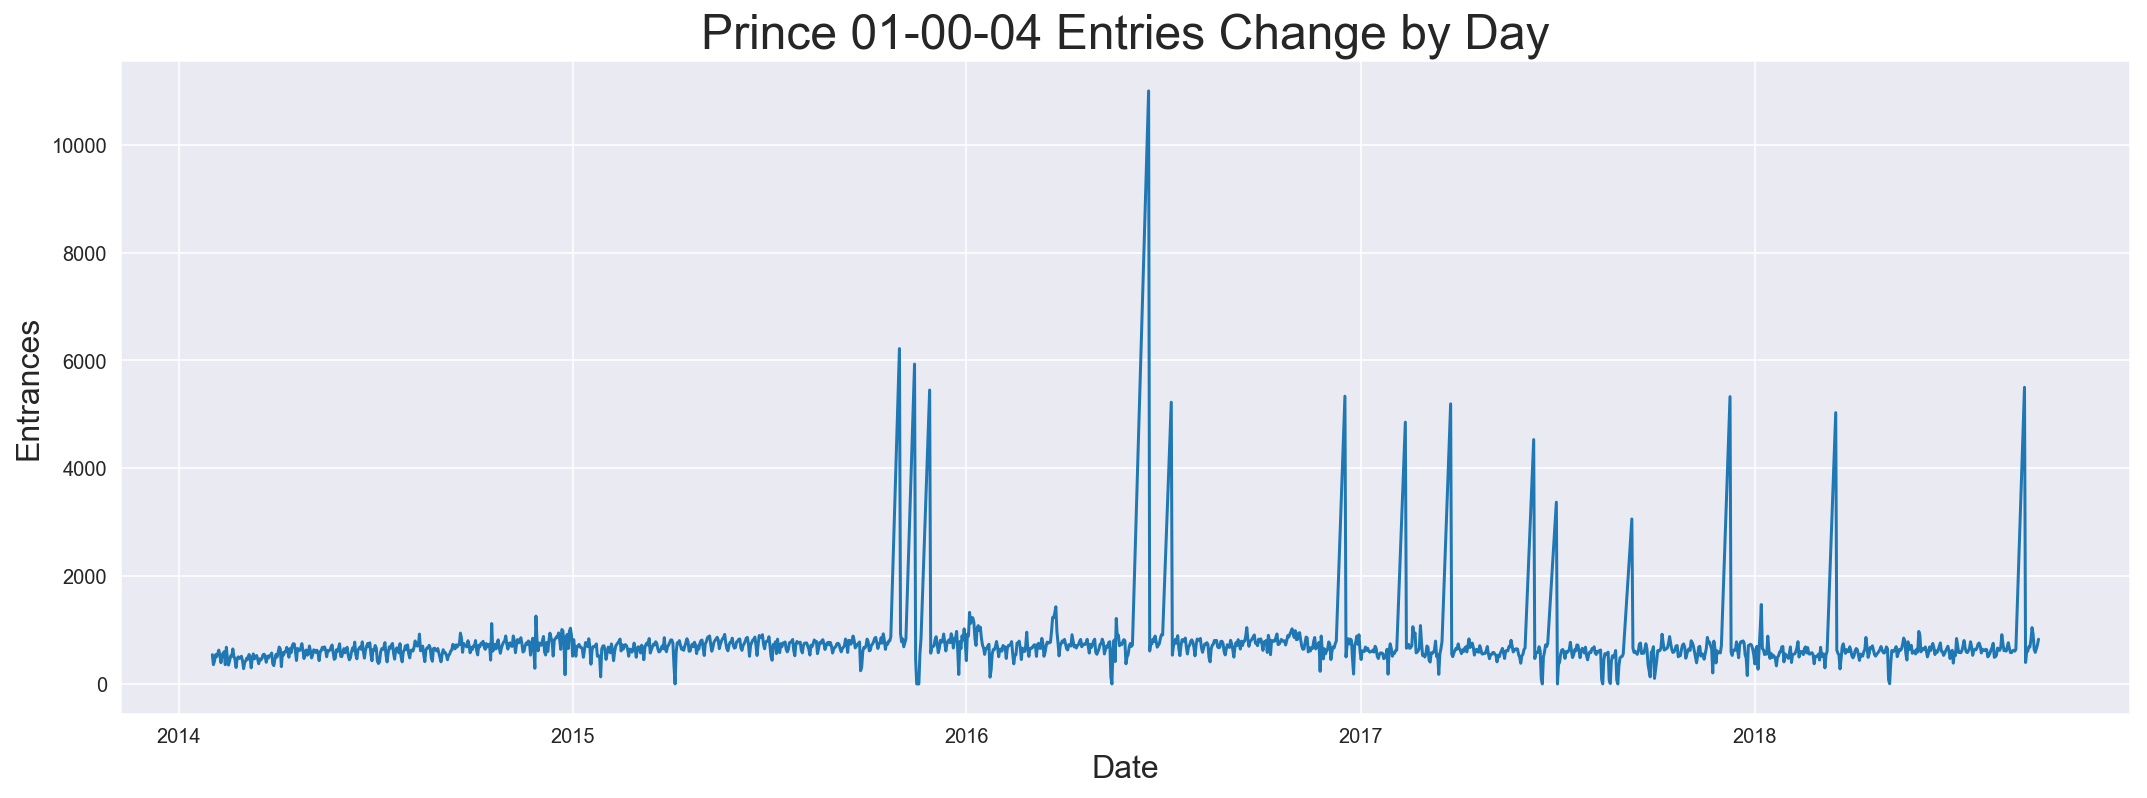

In [120]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010004_daily.Date,prince_010004_daily.Hourly_Entries);
plt.title('Prince 01-00-04 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

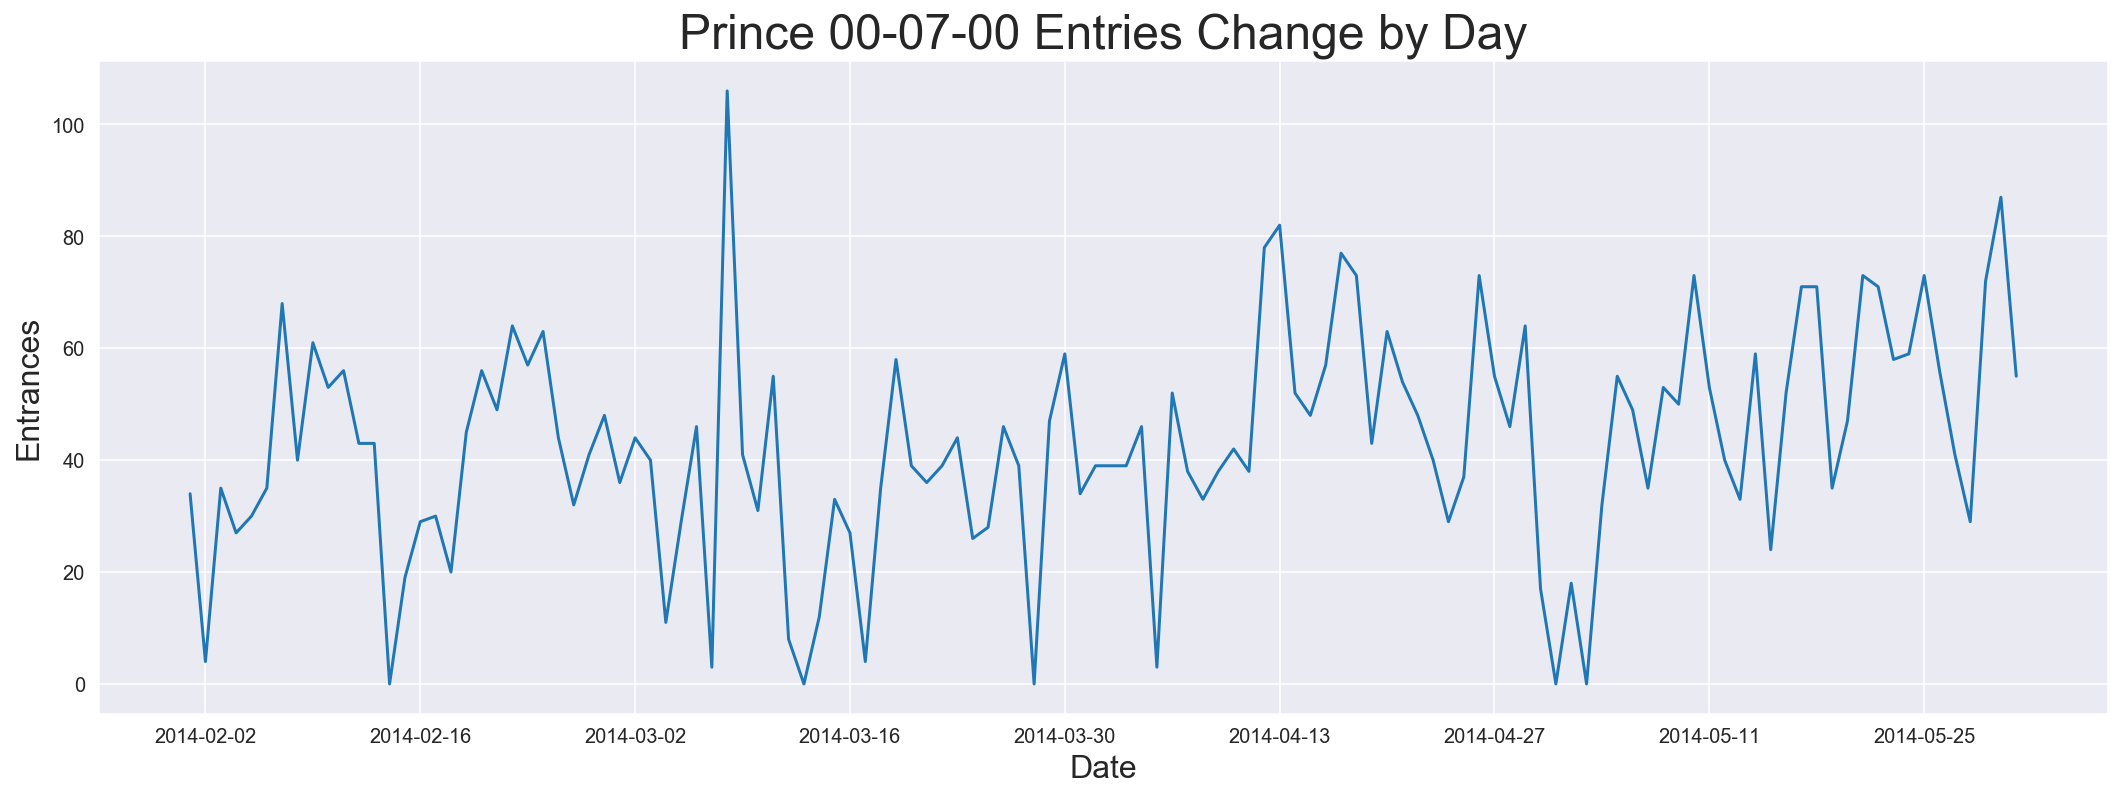

In [121]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000700_daily.Date,prince_000700_daily.Hourly_Entries);
plt.title('Prince 00-07-00 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

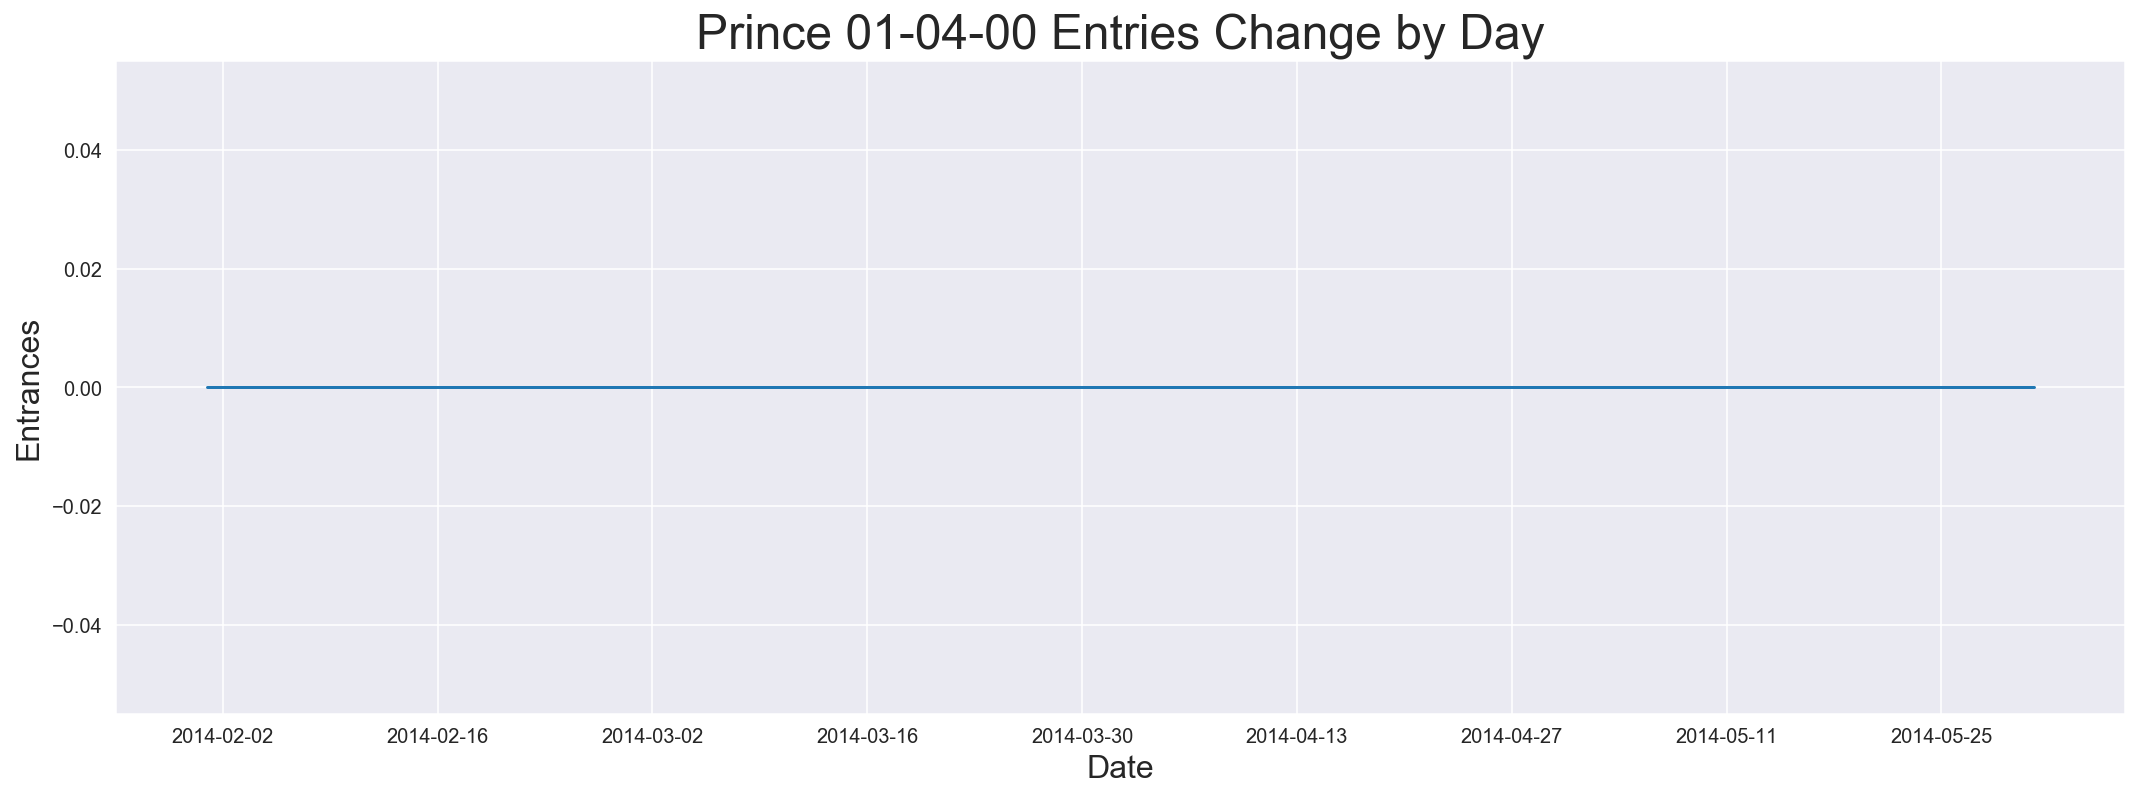

In [122]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010400_daily.Date,prince_010400_daily.Hourly_Entries);
plt.title('Prince 01-04-00 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

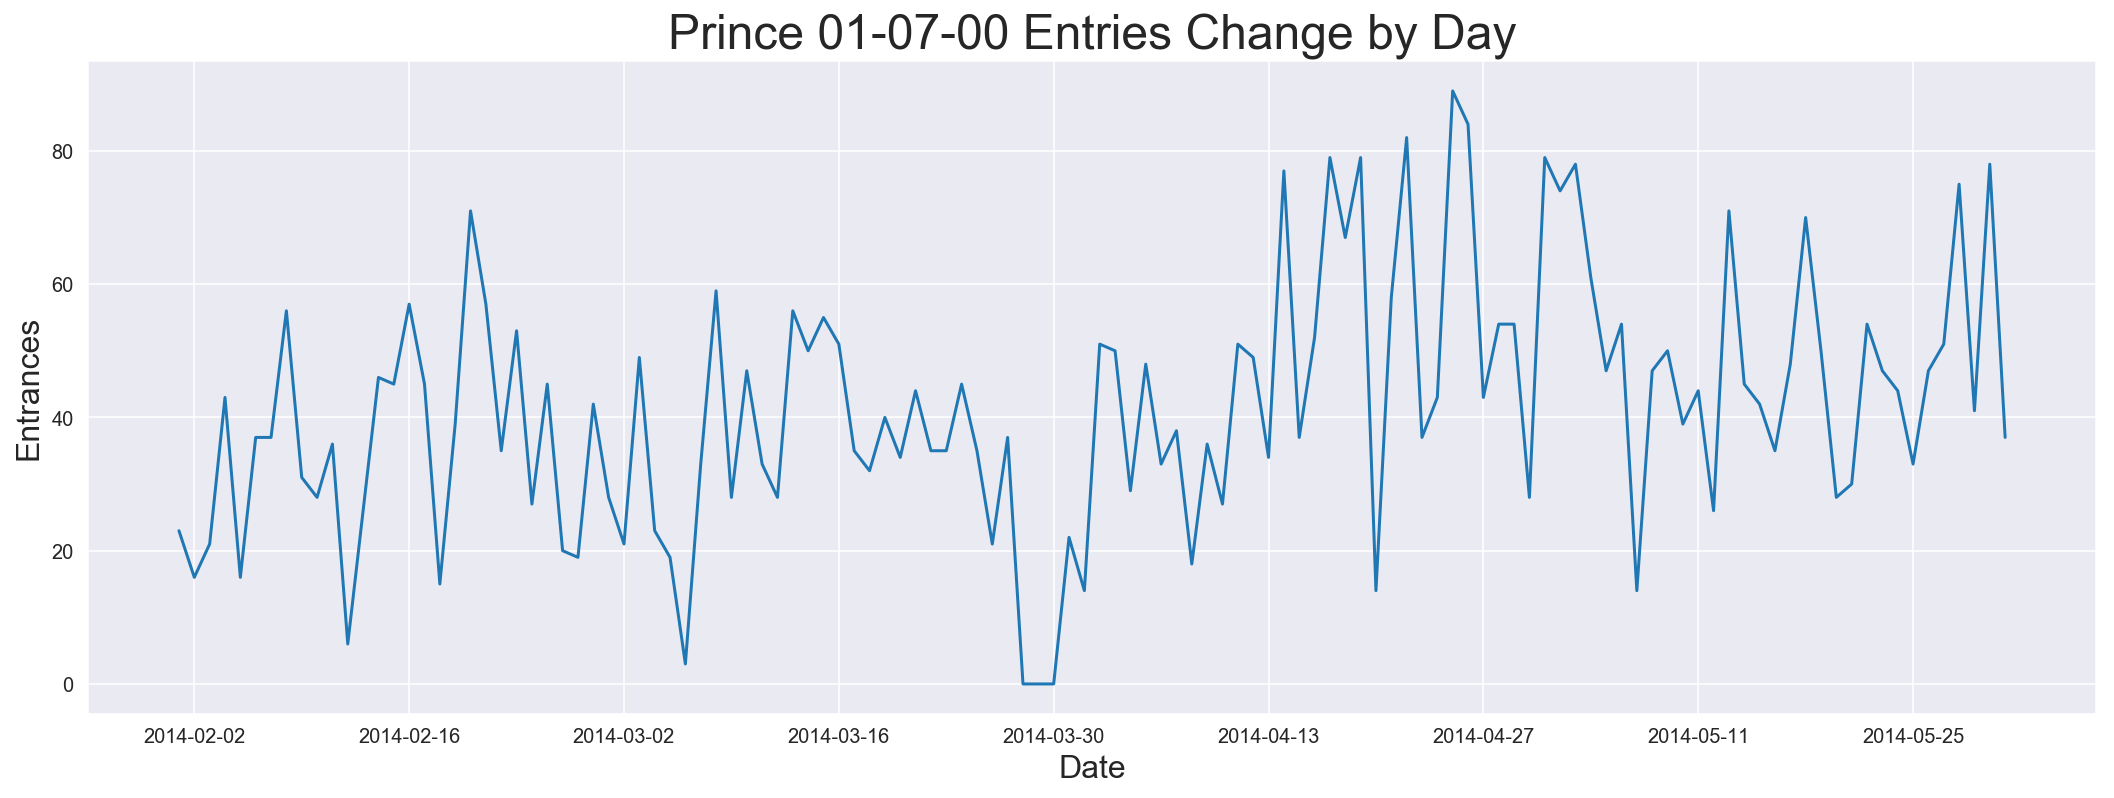

In [123]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_010700_daily.Date,prince_010700_daily.Hourly_Entries);
plt.title('Prince 01-07-00 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

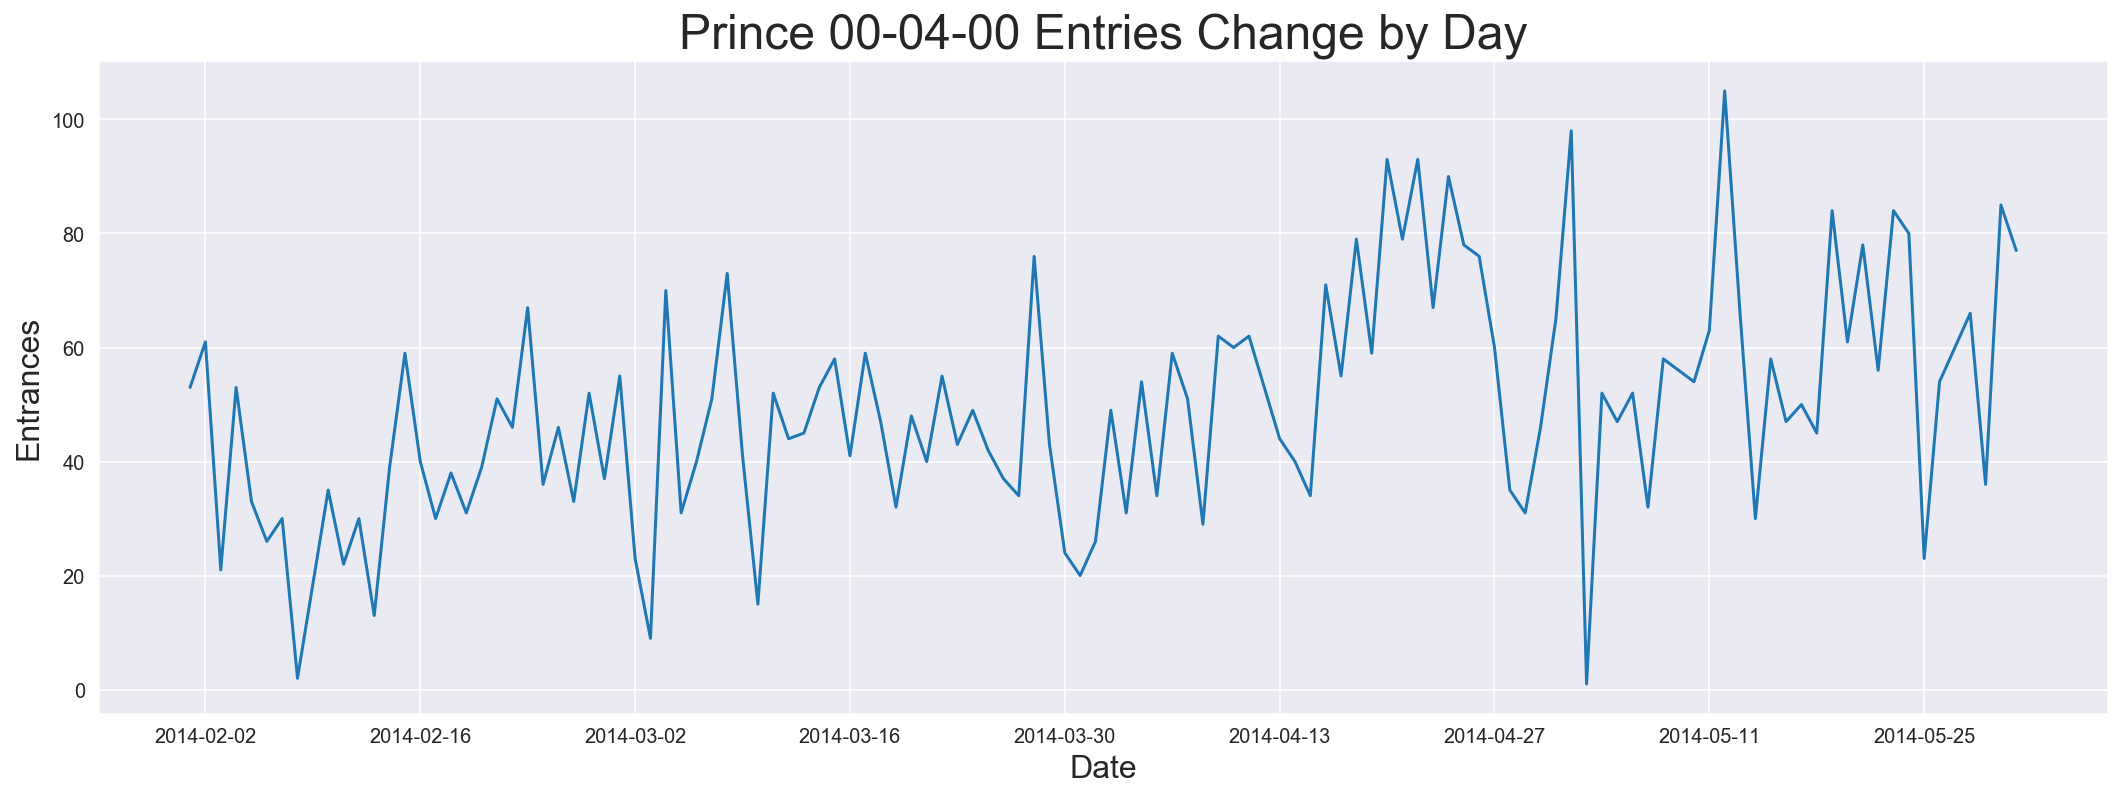

In [124]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000400_daily.Date,prince_000400_daily.Hourly_Entries);
plt.title('Prince 00-04-00 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

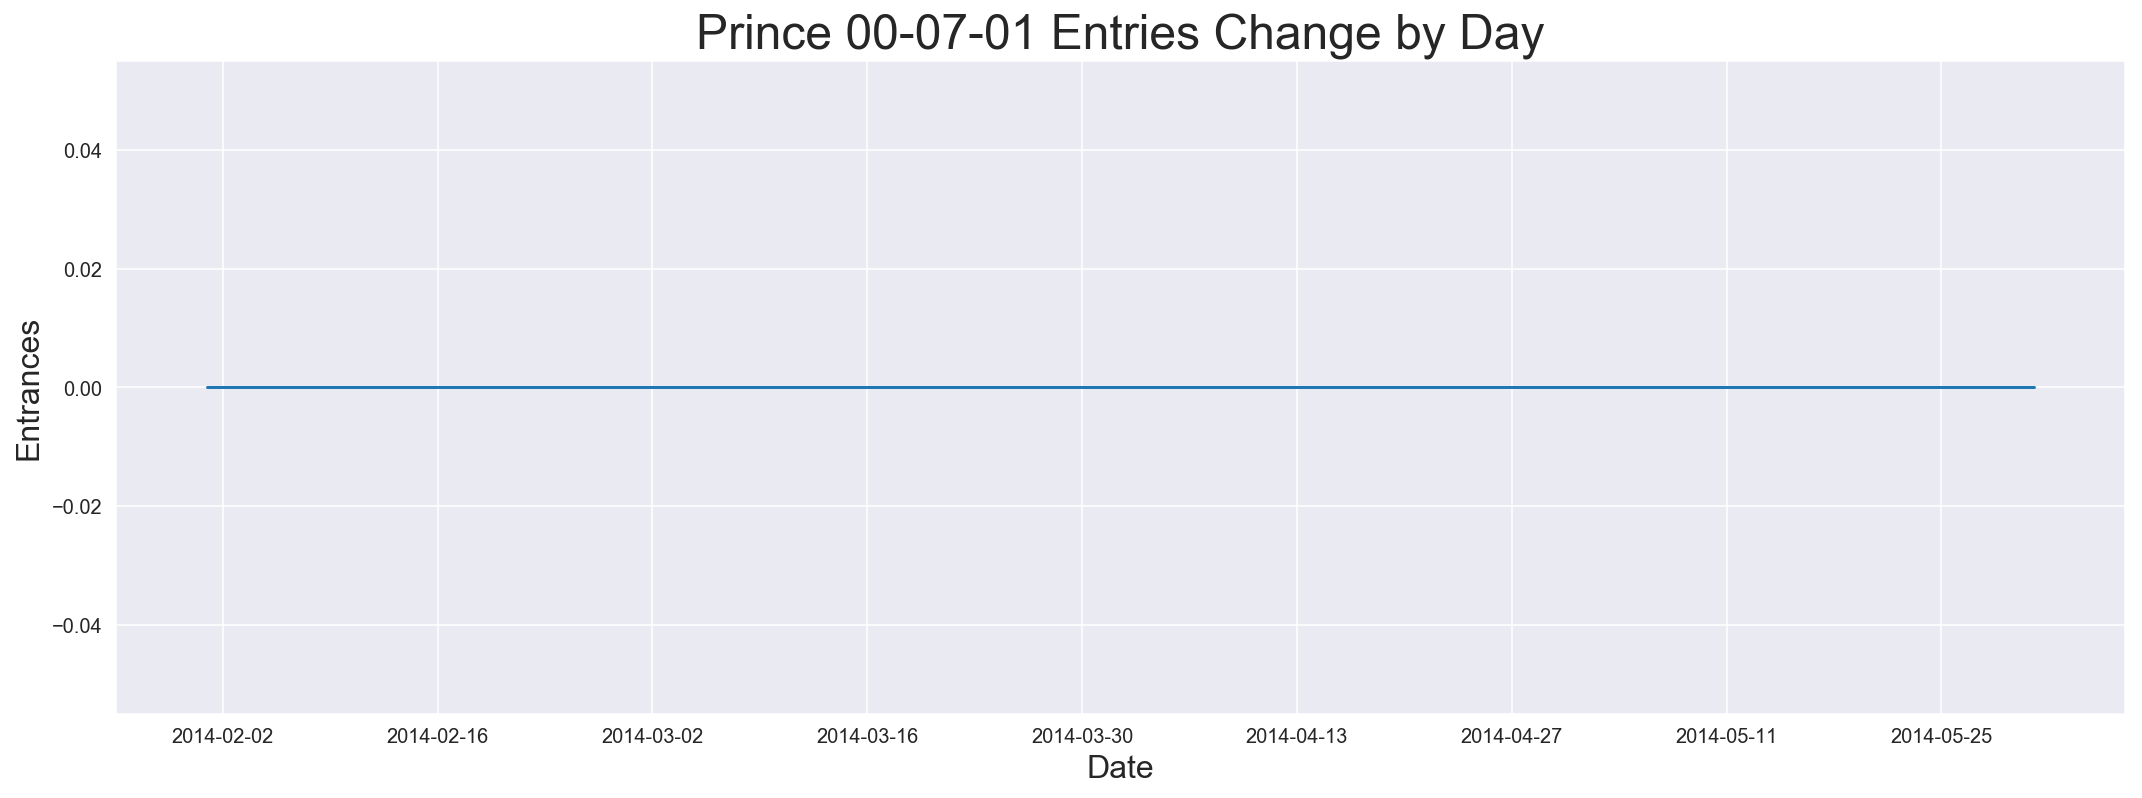

In [125]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_000701_daily.Date,prince_000701_daily.Hourly_Entries);
plt.title('Prince 00-07-01 Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

### Combine each turnstile dataframe into one dataframe

In [126]:
prince_frames = [prince_000000_daily, prince_000004_daily, prince_000002_daily, prince_000003_daily, prince_000001_daily,
                 prince_010002_daily, prince_010000_daily, prince_010003_daily, prince_010001_daily, prince_010004_daily,
                 prince_000700_daily, prince_010400_daily, prince_010700_daily, prince_000400_daily, prince_000701_daily]
prince_daily = pd.concat(prince_frames)

### Group the turnstile counts by Date

In [127]:
prince_daily = prince_daily.groupby(['Date','weekday', 'Year'])['traffic' ,'Hourly_Entries', 'Hourly_Exits'].sum()
prince_daily.reset_index(inplace=True)

### Prince Combined Turnstile examination
Similar to the individual tunrstile charts above below are the combined Entrances by Day for all turnstiles at the Prince St dtation.  

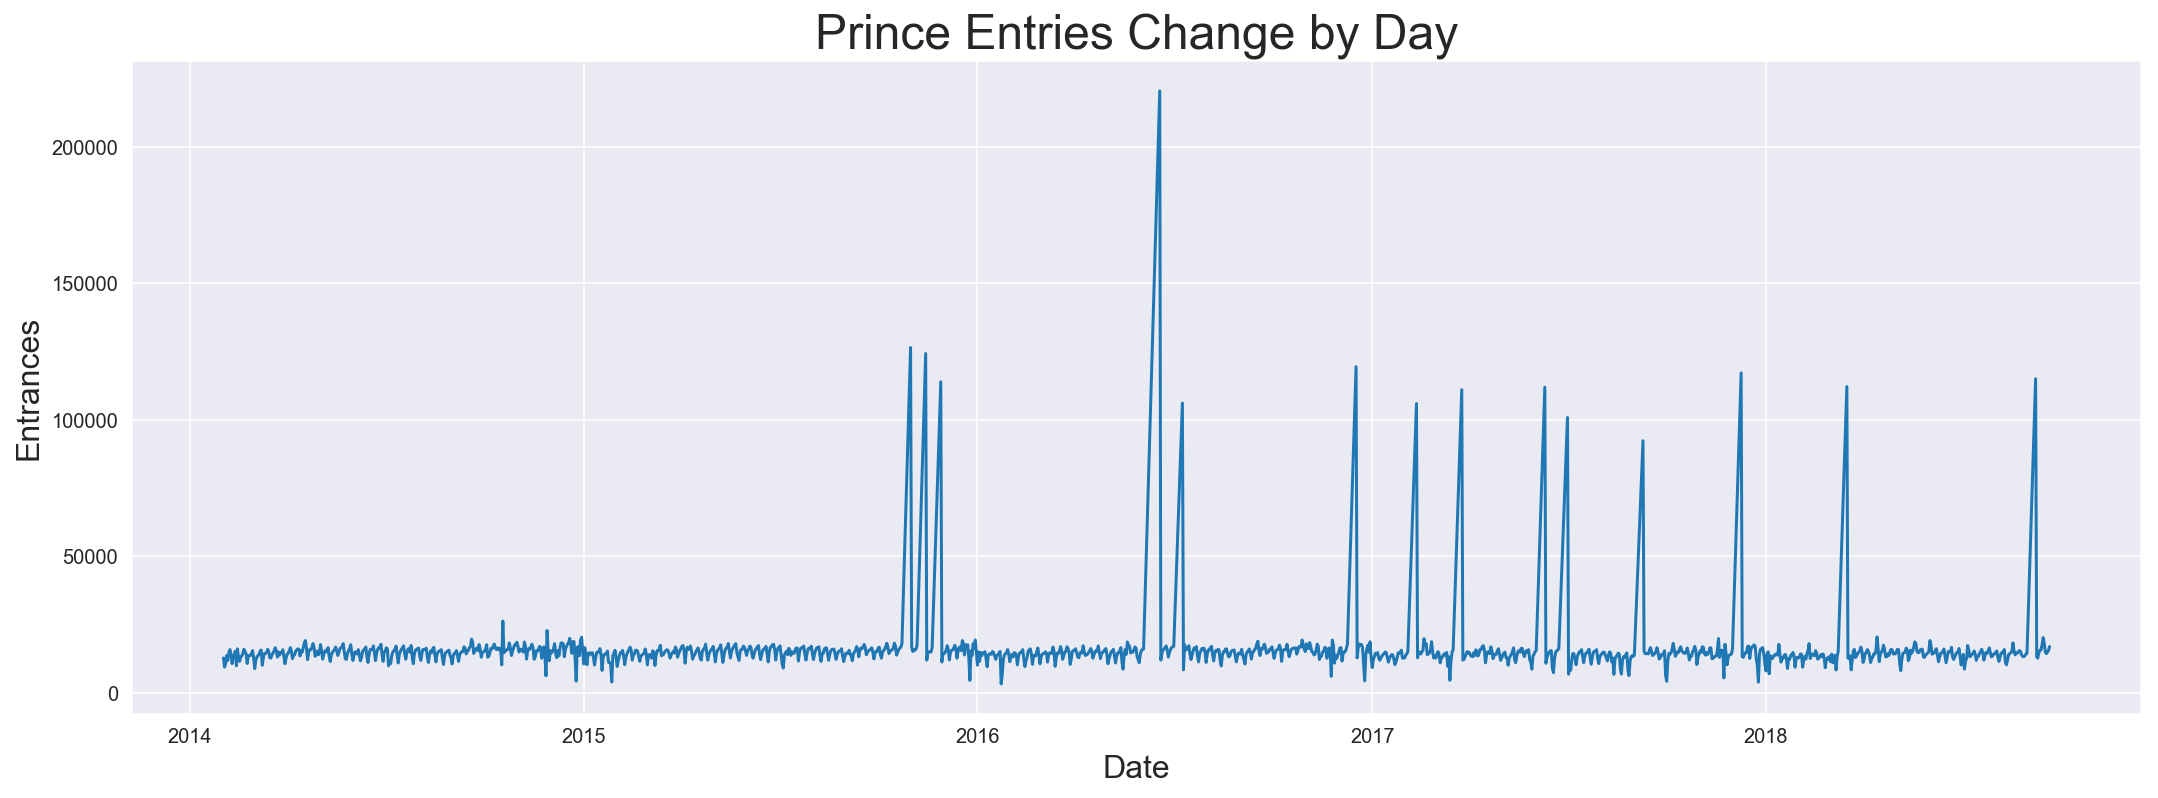

In [403]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_daily.Date,prince_daily.Hourly_Entries);
plt.title('Prince Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

### Identify the dates of the 14 data gaps
There are 14 different gaps of missing data.  They show up wit the running turnstile count summing a weeks data into one day with one of the gaps being two weeks in duration and thu twice as large. 

In [128]:
prince_daily_high = prince_daily['Hourly_Entries'] > 50000

In [129]:
prince_daily[prince_daily_high]

Date  weekday  Year  traffic  Hourly_Entries  Hourly_Exits
630  2015-10-31        5  2015   254338          126417        127921
637  2015-11-14        5  2015   249410          124239        125171
644  2015-11-28        5  2015   230415          113871        116544
833  2016-06-18        5  2016   440594          220404        220190
847  2016-07-09        5  2016   212981          106081        106900
1001 2016-12-17        5  2016   227641          119398        108243
1050 2017-02-11        5  2017   208525          105884        102641
1085 2017-03-25        5  2017   218895          110973        107922
1155 2017-06-10        5  2017   220095          111907        108188
1169 2017-07-01        5  2017   189738          100799         88939
1232 2017-09-09        5  2017   171702           92277         79425
1316 2017-12-09        5  2017   228476          117128        111348
1407 2018-03-17        5  2018   226864          112125        114739
1575 2018-09-08        5  2018   223700          114989        108711

### Remove the 14 days showing the full week(s) of turnstile counts

In [130]:
prince_daily_regular = prince_daily['Hourly_Entries'] < 50000

In [131]:
prince_daily_unclean = pd.DataFrame(prince_daily[prince_daily_regular])

In [139]:
# Create month and year columns
prince_daily_unclean['month'] = prince_daily_unclean['Date'].dt.month
prince_daily_unclean['year'] = prince_daily_unclean['Date'].dt.year

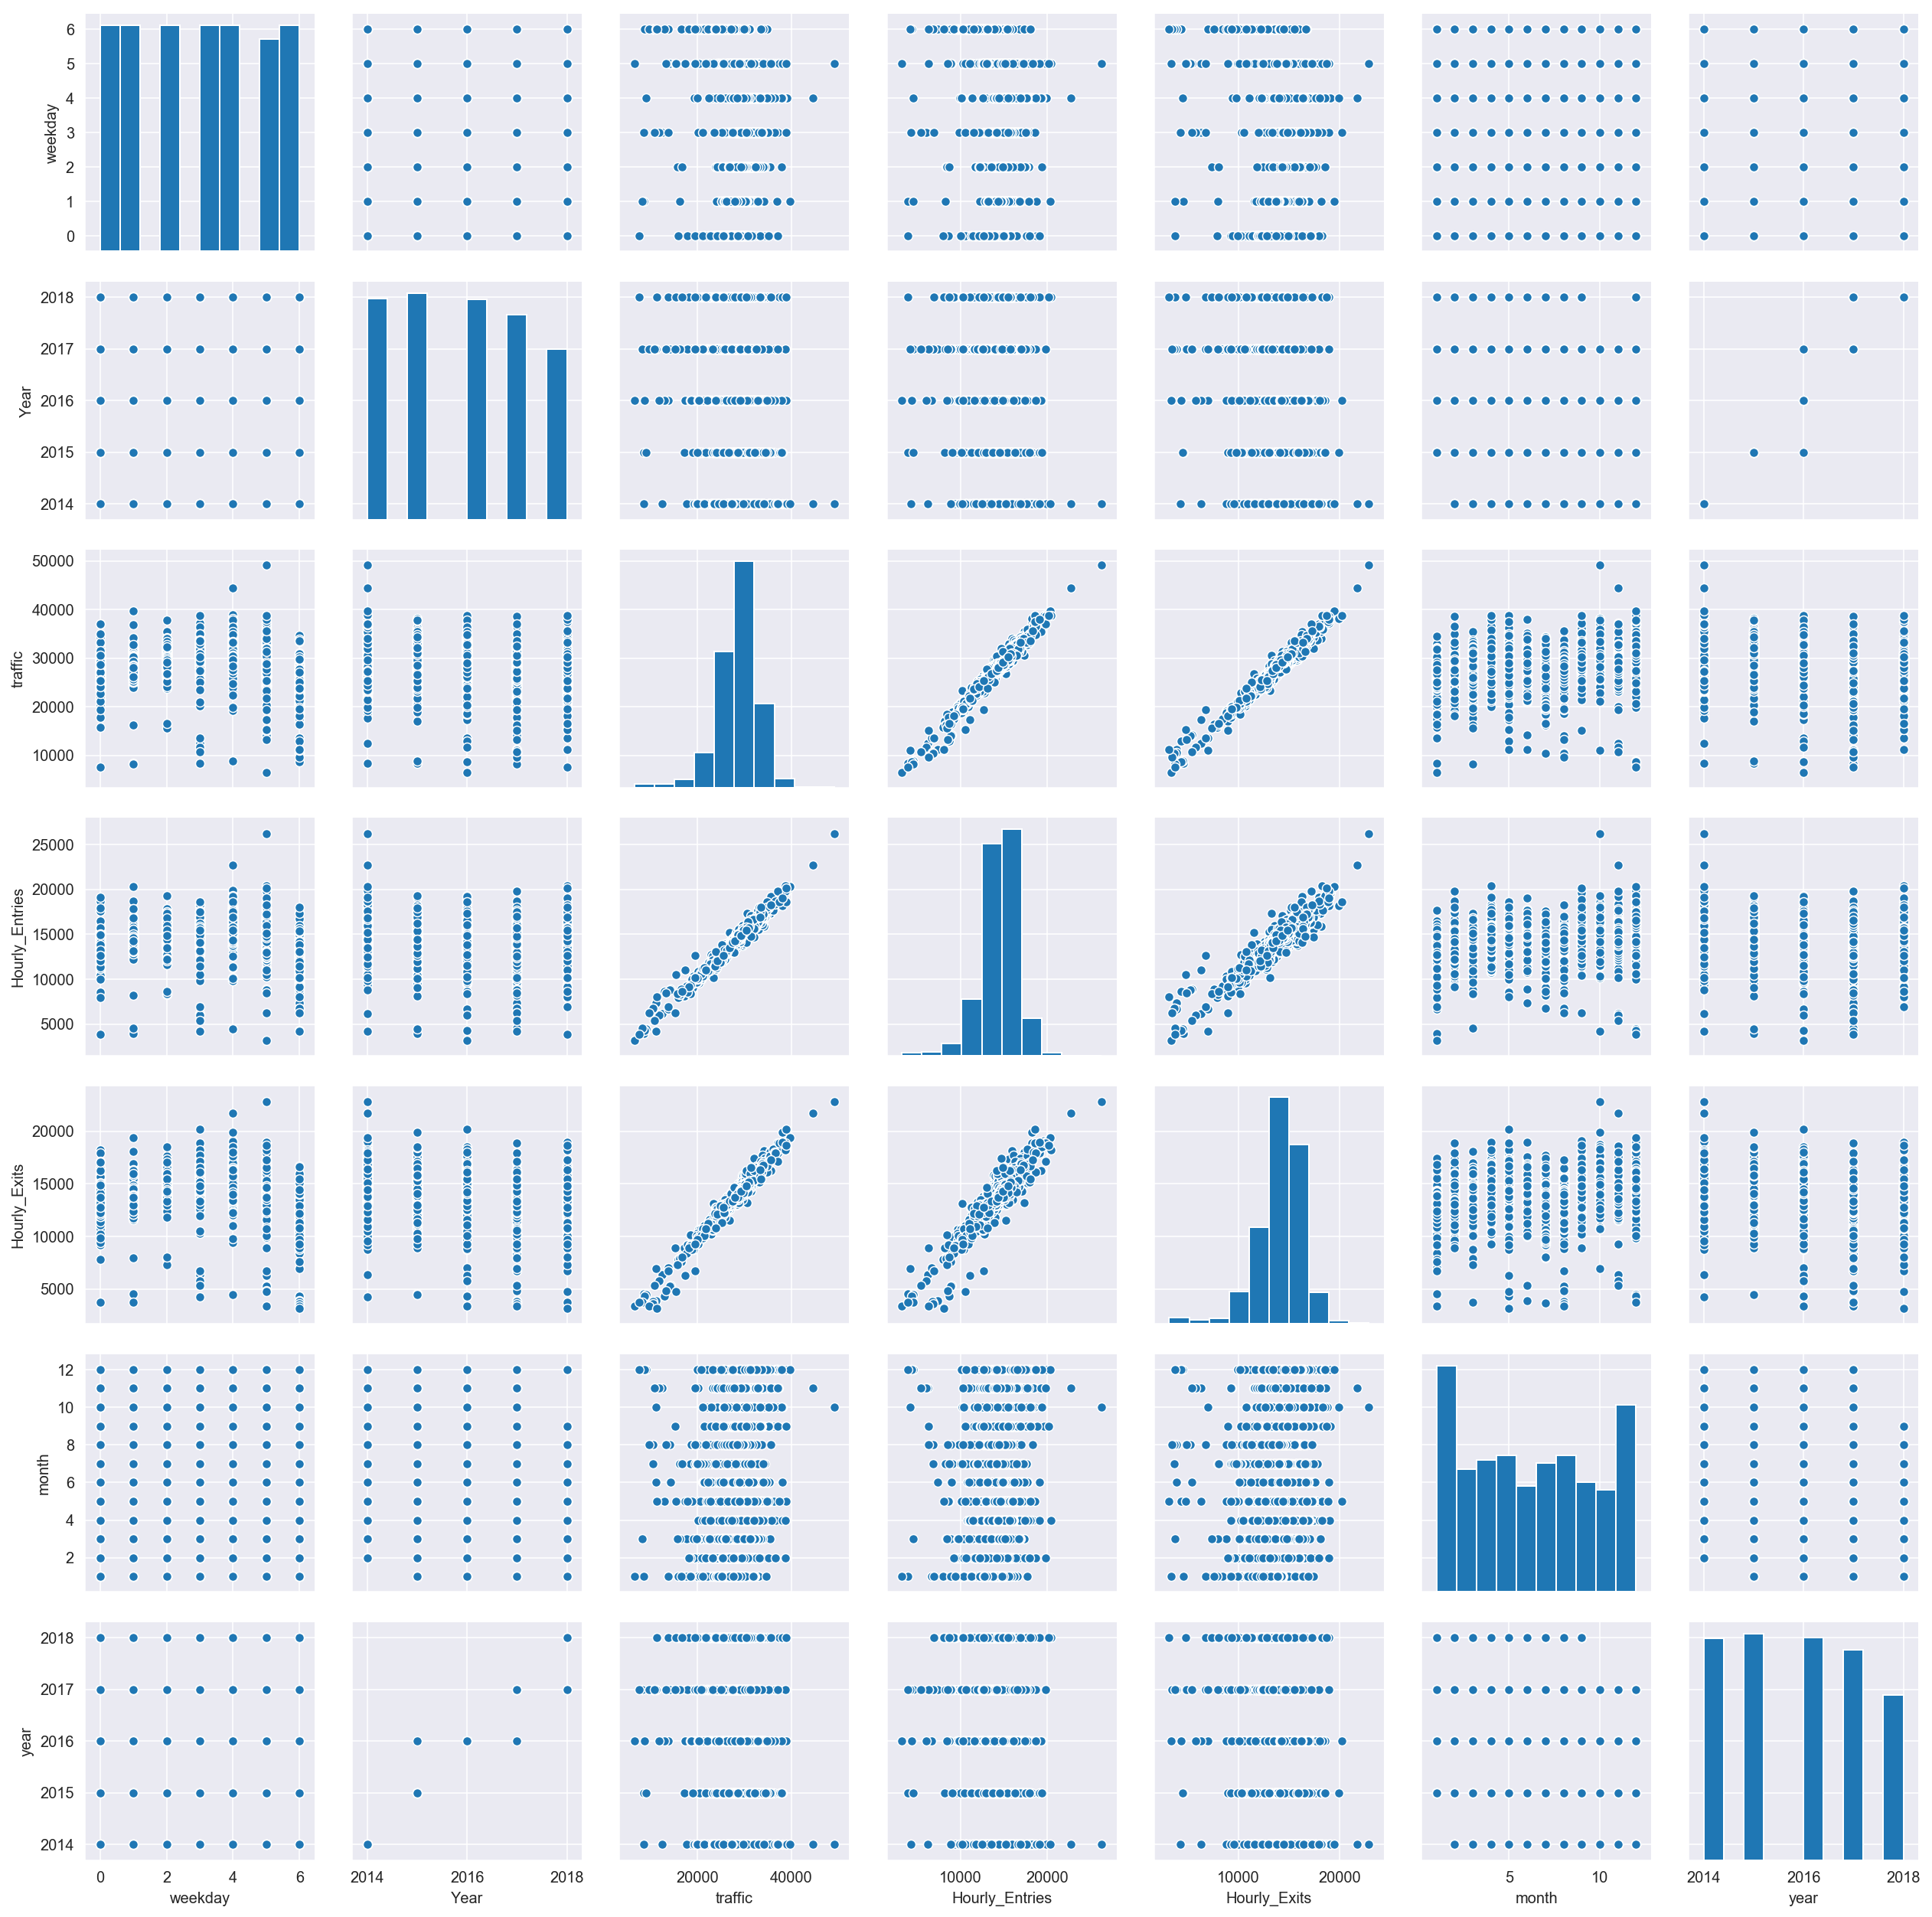

In [175]:
# Pairplot
sns.pairplot(prince_daily_unclean);

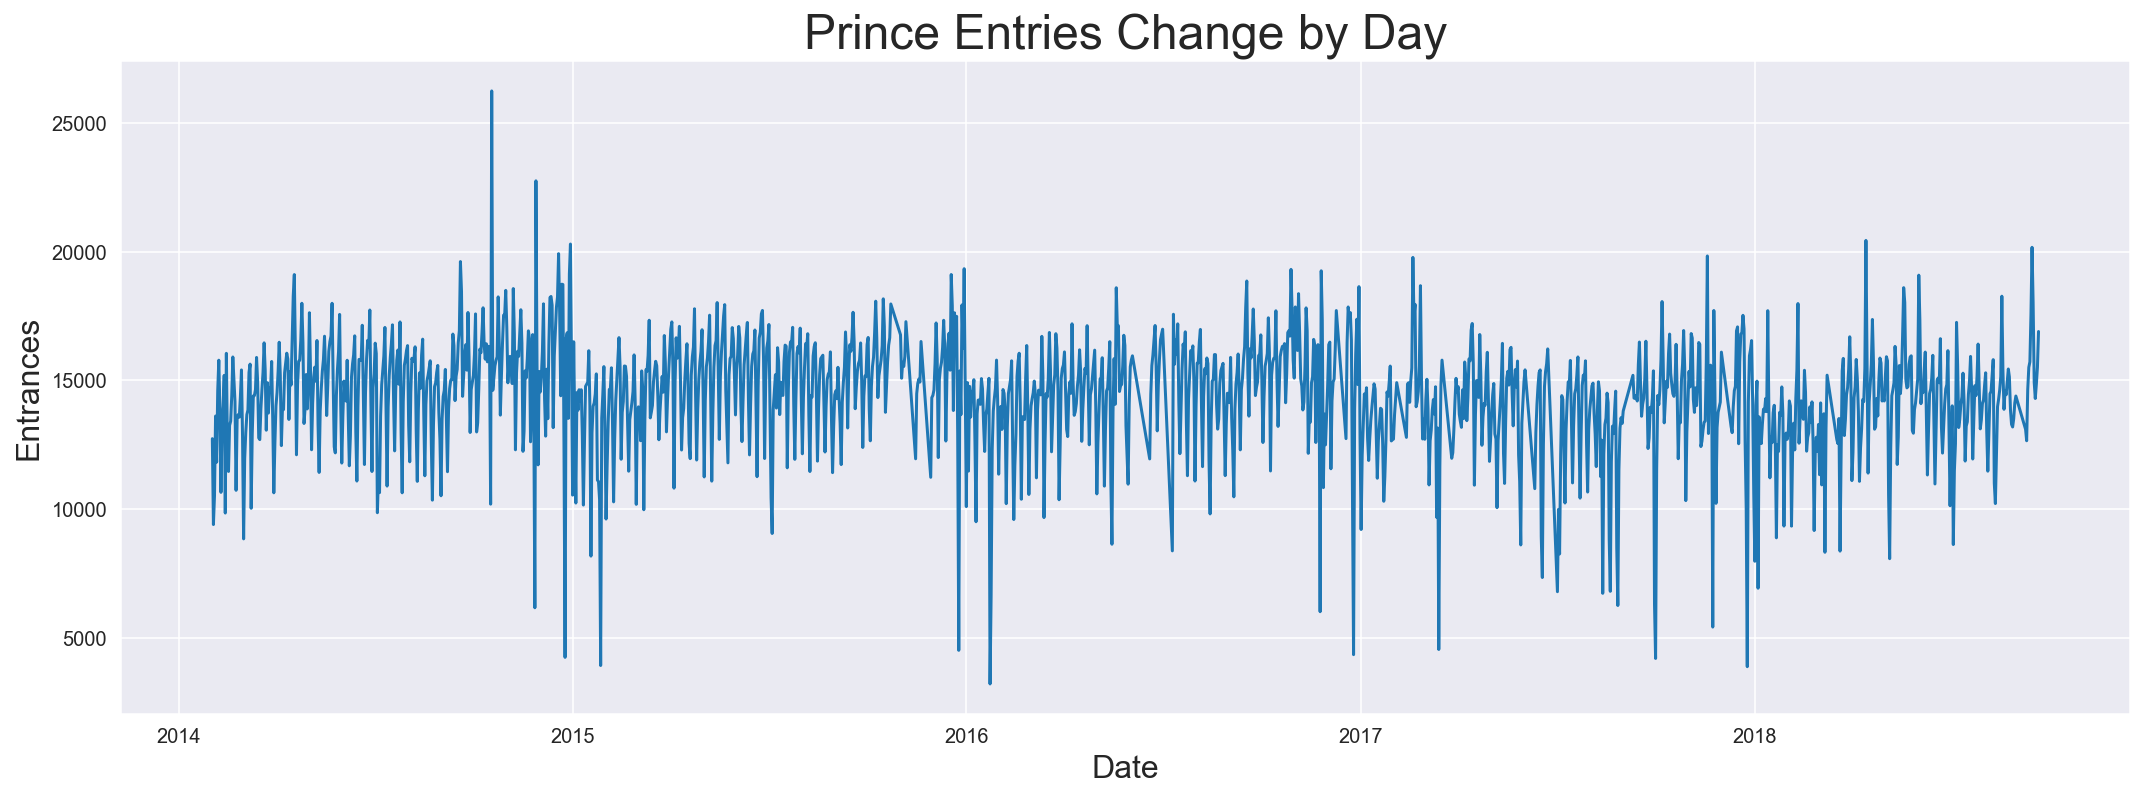

In [151]:
plt.figure(figsize=(18,6))
sns.lineplot(prince_daily_unclean.Date,prince_daily.Hourly_Entries);
plt.title('Prince Entries Change by Day', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('Date', fontsize=16);

#### Prince Street by day of the week boxplots and violin plots.
 Prince St ridership does not follow the same pattern as the rest of the system in that it does not experiance a large drop off for Saturday Which is actually busier than Monday, and while SUnday is still the day with the lowest ridership it is only around a third instead of the half of the whole system. The disribution Entrances for Saturady and Sunday are less compact than for the workweek.  

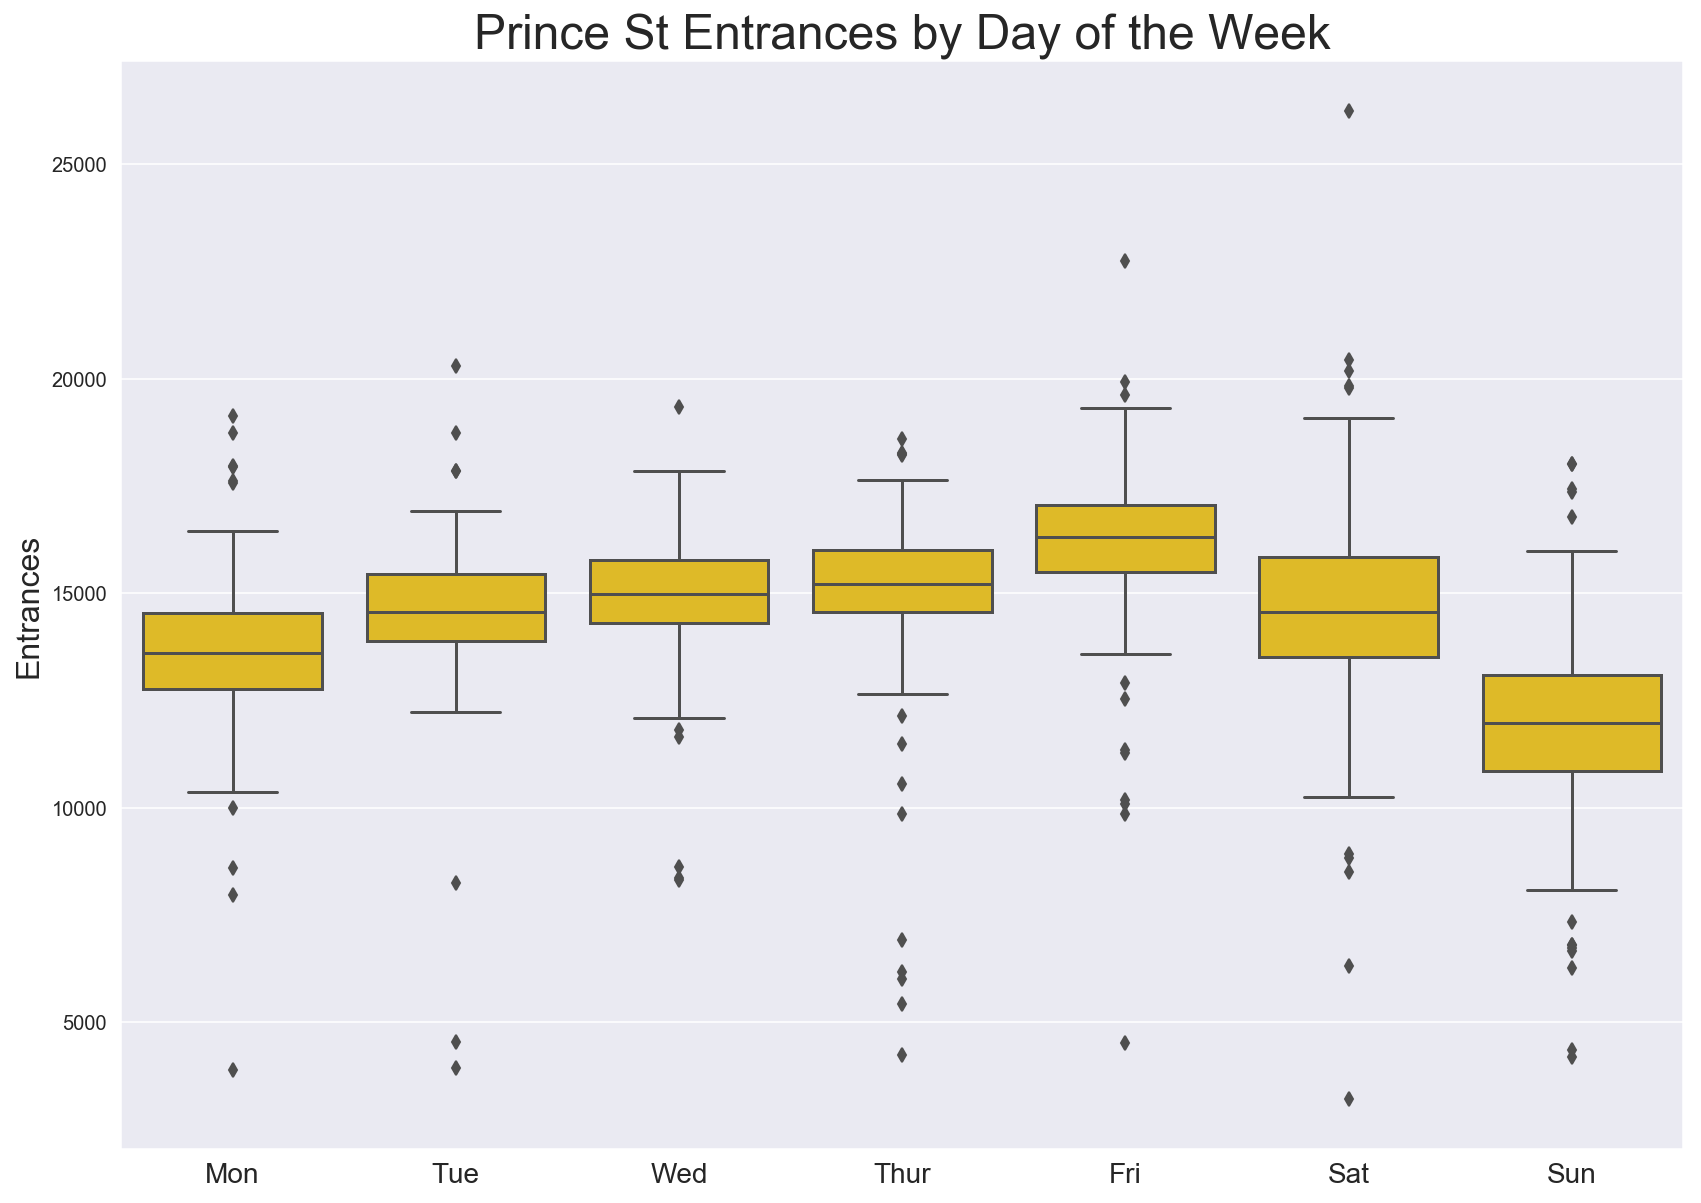

In [213]:
plt.figure(figsize=(14,10))
sns.boxplot(x=prince_daily_unclean.weekday, y=prince_daily_unclean.Hourly_Entries, color='#FCCC0A');
plt.title('Prince St Entrances by Day of the Week', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], fontsize=14);

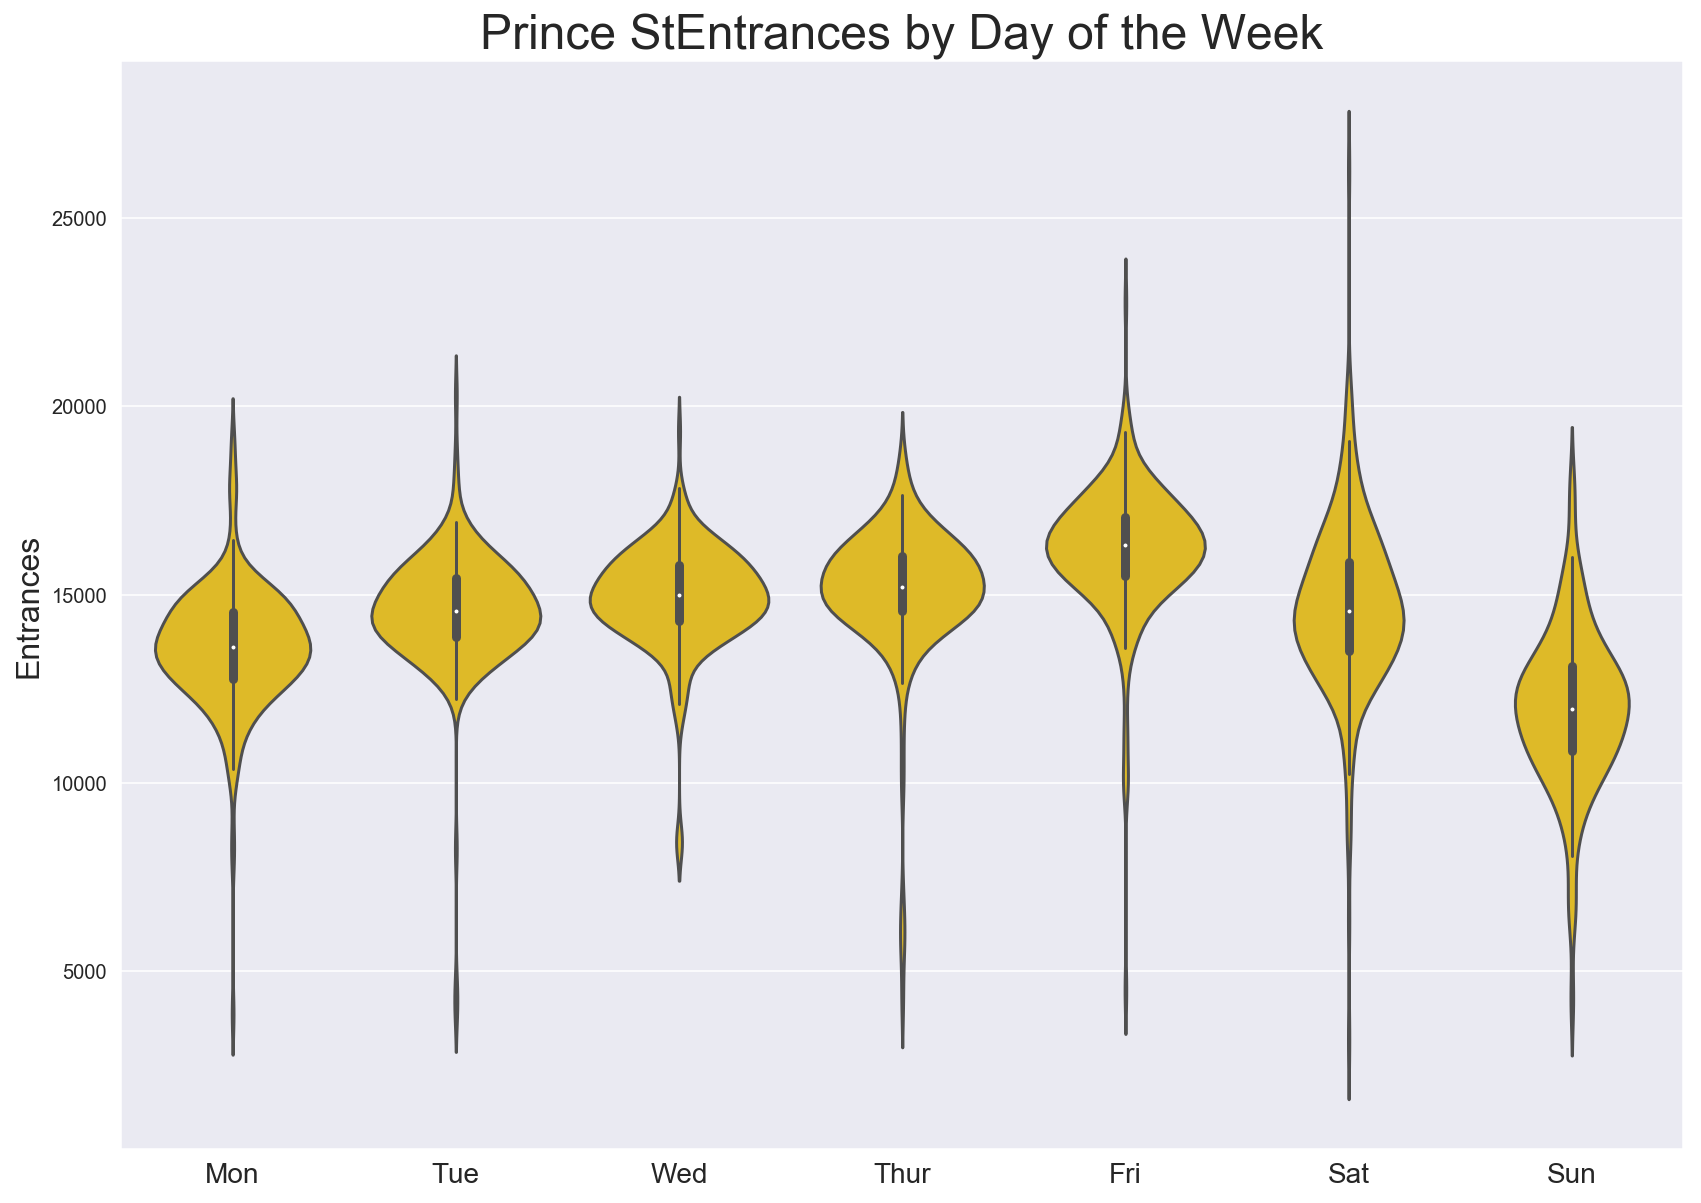

In [214]:
plt.figure(figsize=(14,10))
sns.violinplot(x=prince_daily_unclean.weekday, y=prince_daily_unclean.Hourly_Entries, color='#FCCC0A');
plt.title('Prince StEntrances by Day of the Week', fontsize=24);
plt.ylabel('Entrances', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], fontsize=14);

#### Autocorrelation and Partial Autocorrelation Plots for Prince Stret

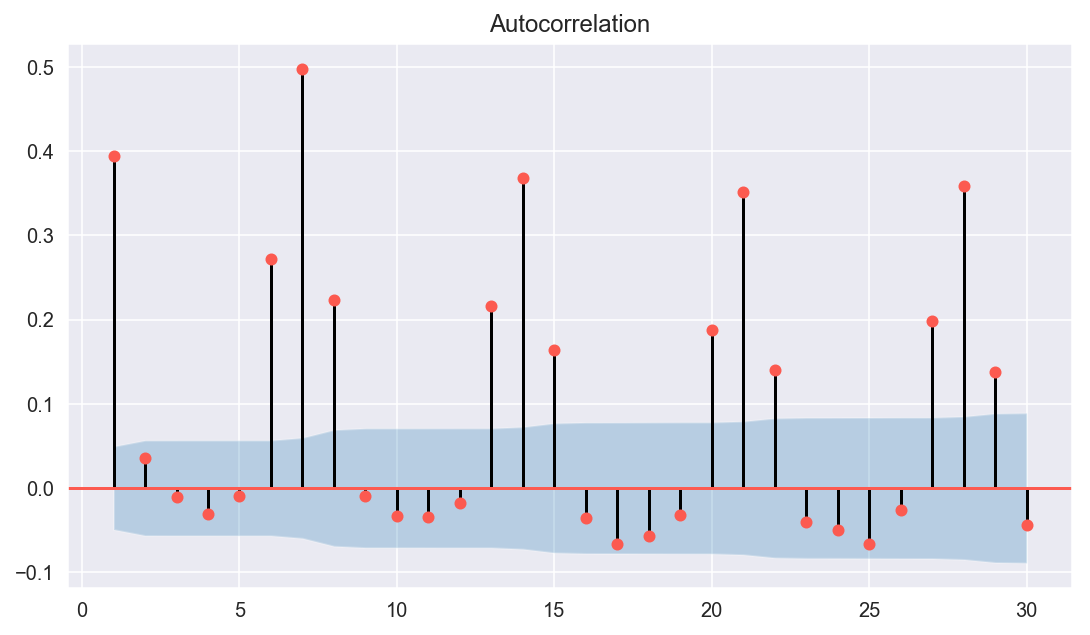

In [133]:
fig, ax = plt.subplots(figsize = (9, 5))
plot_acf(prince_daily_unclean['Hourly_Entries'], lags = 30, ax = ax, color=sns.xkcd_rgb["coral"], zero=False)
plt.show();

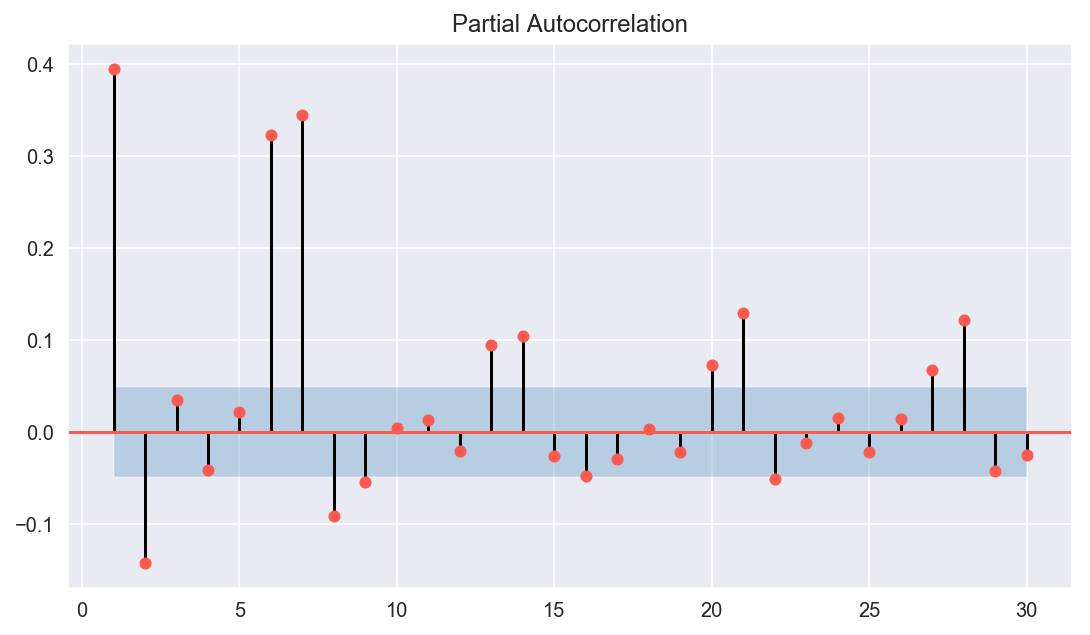

In [135]:
fig, ax = plt.subplots(figsize = (9, 5))
plot_pacf(prince_daily_unclean['Hourly_Entries'], lags = 30, ax = ax, color=sns.xkcd_rgb["coral"], zero=False)
plt.show();

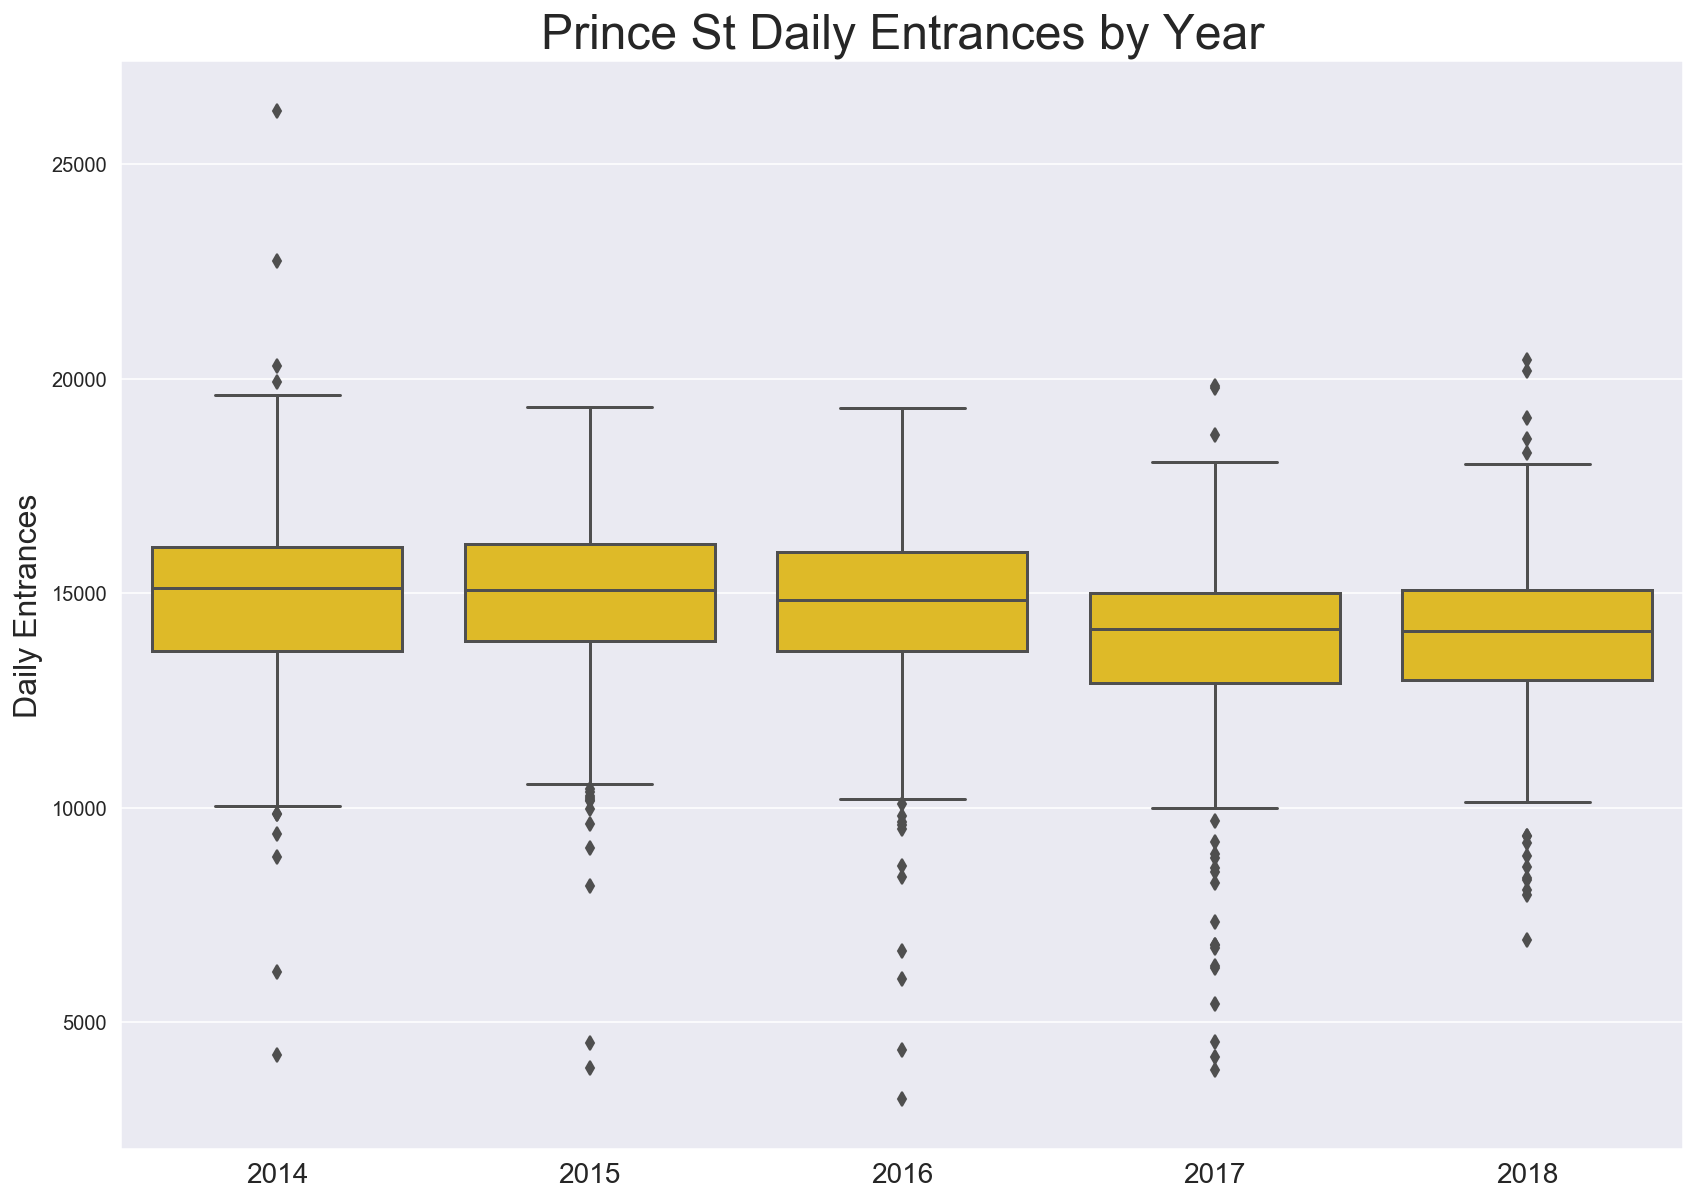

In [165]:
plt.figure(figsize=(14,10))
sns.boxplot(x=prince_daily_unclean.year, y=prince_daily_unclean.Hourly_Entries, color='#FCCC0A');
plt.title('Prince St Daily Entrances by Year', fontsize=24);
plt.ylabel('Daily Entrances', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4,], ['2014', '2015', '2016', '2017', '2018'], fontsize=14);

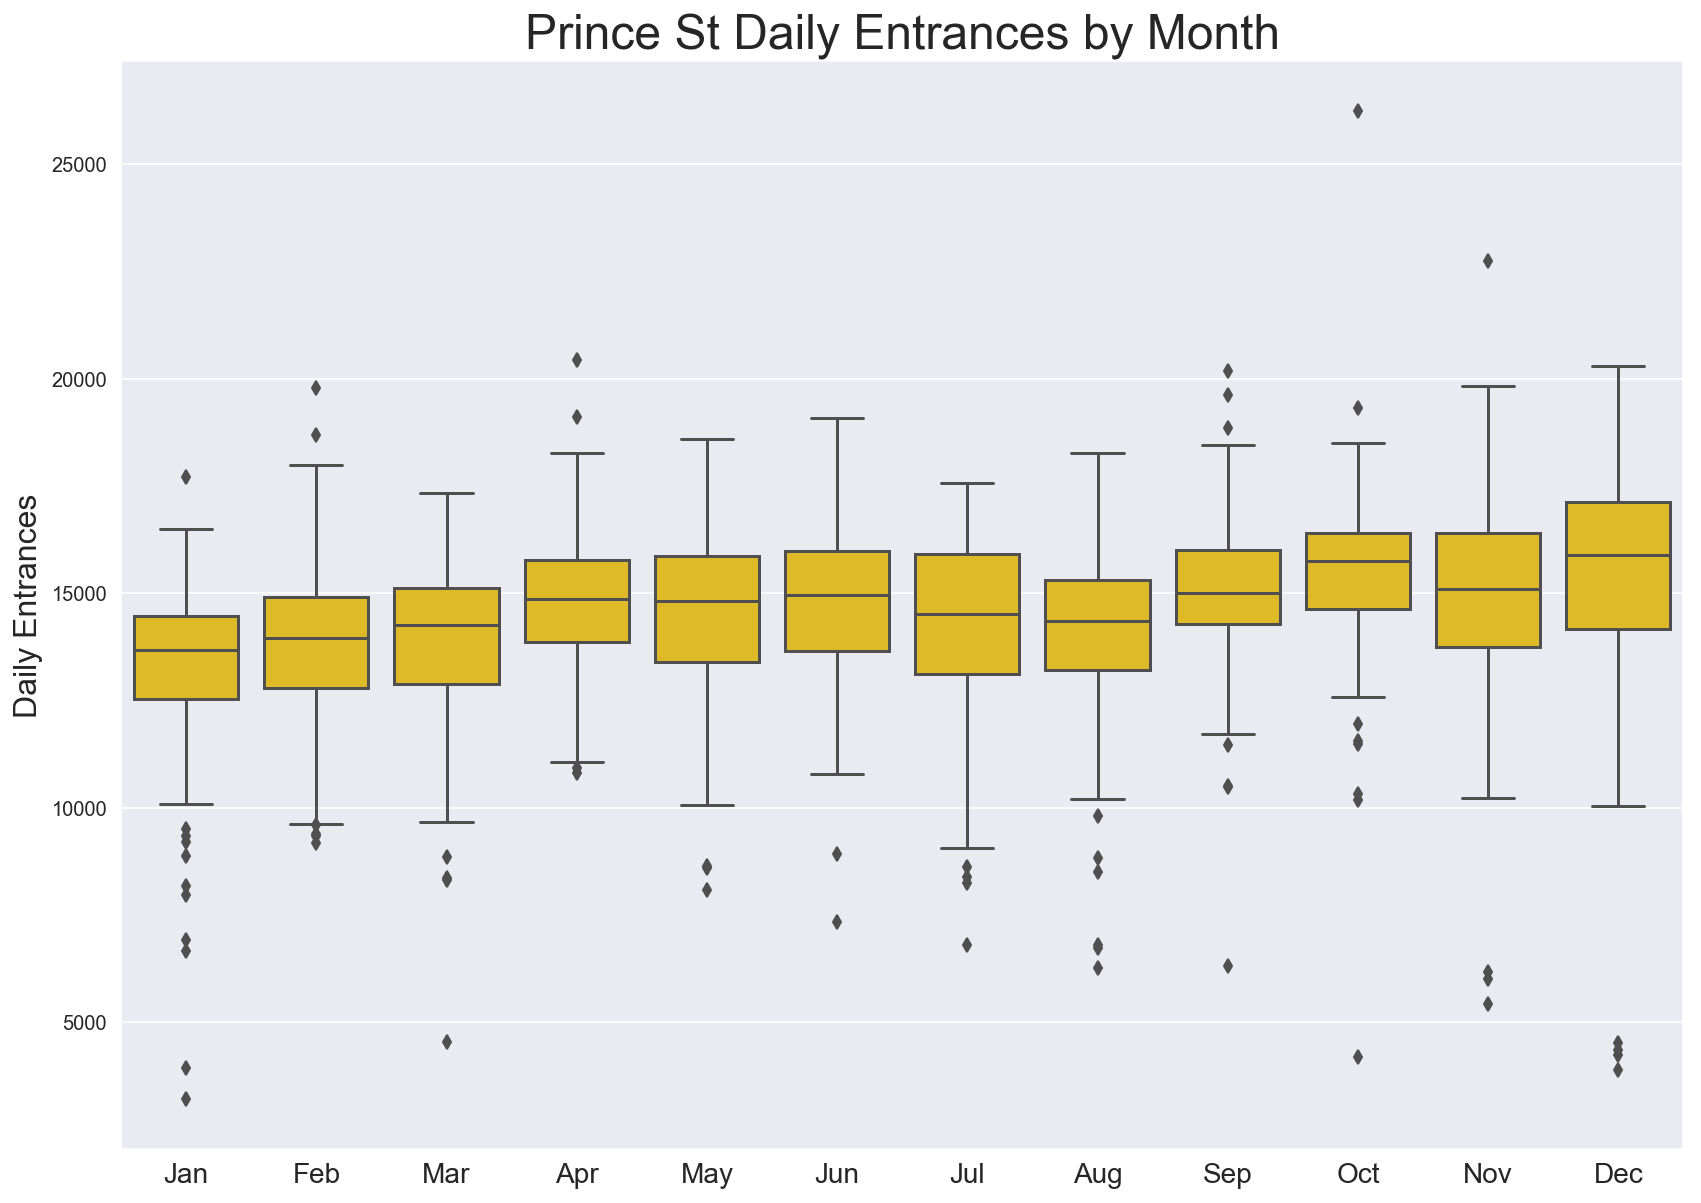

In [166]:
plt.figure(figsize=(14,10))
sns.boxplot(x=prince_daily_unclean.month, y=prince_daily_unclean.Hourly_Entries, color='#FCCC0A');
plt.title('Prince St Daily Entrances by Month', fontsize=24);
plt.ylabel('Daily Entrances', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14);

In [167]:
prince_daily_unclean.columns

Index(['Date', 'weekday', 'Year', 'traffic', 'Hourly_Entries', 'Hourly_Exits',
       'month', 'year'],
      dtype='object')

In [197]:
# One Hot for day of the week and workweek
prince_daily_unclean['is_Monday'] = np.where(prince_daily_unclean.weekday == 0, 1, 0)
prince_daily_unclean['is_Tuesday'] = np.where(prince_daily_unclean.weekday == 1, 1, 0)
prince_daily_unclean['is_Wednesday'] = np.where(prince_daily_unclean.weekday == 2, 1, 0)
prince_daily_unclean['is_Thursday'] = np.where(prince_daily_unclean.weekday == 3, 1, 0)
prince_daily_unclean['is_Friday'] = np.where(prince_daily_unclean.weekday == 4, 1, 0)
prince_daily_unclean['is_Saturday'] = np.where(prince_daily_unclean.weekday == 5, 1, 0)
prince_daily_unclean['is_Sunday'] = np.where(prince_daily_unclean.weekday == 6, 1, 0)

prince_daily_unclean['is_weekend'] = np.where(prince_daily_unclean.weekday == 5, 1,
                                     np.where(prince_daily_unclean.weekday == 6, 1, 0))

In [187]:
# One hot for the month
prince_daily_unclean['is_Jan'] = np.where(prince_daily_unclean.month == 1, 1, 0)
prince_daily_unclean['is_Feb'] = np.where(prince_daily_unclean.month == 2, 1, 0)
prince_daily_unclean['is_Mar'] = np.where(prince_daily_unclean.month == 3, 1, 0)
prince_daily_unclean['is_Apr'] = np.where(prince_daily_unclean.month == 4, 1, 0)
prince_daily_unclean['is_May'] = np.where(prince_daily_unclean.month == 5, 1, 0)
prince_daily_unclean['is_Jun'] = np.where(prince_daily_unclean.month == 6, 1, 0)
prince_daily_unclean['is_Jul'] = np.where(prince_daily_unclean.month == 7, 1, 0)
prince_daily_unclean['is_Aug'] = np.where(prince_daily_unclean.month == 8, 1, 0)
prince_daily_unclean['is_Sep'] = np.where(prince_daily_unclean.month == 9, 1, 0)
prince_daily_unclean['is_Oct'] = np.where(prince_daily_unclean.month == 10, 1, 0)
prince_daily_unclean['is_Nov'] = np.where(prince_daily_unclean.month == 11, 1, 0)
prince_daily_unclean['is_Dec'] = np.where(prince_daily_unclean.month == 12, 1, 0)

In [188]:
# create traffic lags of one day, one week, two weeks, three weeks and 4 weeeks. 
prince_daily_unclean['traffic_lag_1'] = prince_daily_unclean['traffic'].shift(1)
prince_daily_unclean['traffic_lag_7'] = prince_daily_unclean['traffic'].shift(7)
prince_daily_unclean['traffic_lag_14'] = prince_daily_unclean['traffic'].shift(14)
prince_daily_unclean['traffic_lag_21'] = prince_daily_unclean['traffic'].shift(21)
prince_daily_unclean['traffic_lag_28'] = prince_daily_unclean['traffic'].shift(28)

prince_daily_unclean['Entries_lag_1'] = prince_daily_unclean['Hourly_Entries'].shift(1)
prince_daily_unclean['Entires_lag_7'] = prince_daily_unclean['Hourly_Entries'].shift(7)
prince_daily_unclean['Entires_lag_14'] = prince_daily_unclean['Hourly_Entries'].shift(14)
prince_daily_unclean['Entires_lag_21'] = prince_daily_unclean['Hourly_Entries'].shift(21)
prince_daily_unclean['Entires_lag_28'] = prince_daily_unclean['Hourly_Entries'].shift(28)

prince_daily_unclean['Exits_lag_1'] = prince_daily_unclean['Hourly_Exits'].shift(1)
prince_daily_unclean['Exits_lag_7'] = prince_daily_unclean['Hourly_Exits'].shift(7)
prince_daily_unclean['Exits_lag_14'] = prince_daily_unclean['Hourly_Exits'].shift(14)
prince_daily_unclean['Exits_lag_21'] = prince_daily_unclean['Hourly_Exits'].shift(21)
prince_daily_unclean['Exits_lag_28'] = prince_daily_unclean['Hourly_Exits'].shift(28)

In [189]:
# One hot for specific holidays
prince_daily_unclean['is_New_Years'] = np.where(prince_daily_unclean.Date == '2014-01-01', 1,
                                       np.where(prince_daily_unclean.Date == '2015-01-01', 1,
                                       np.where(prince_daily_unclean.Date == '2016-01-01', 1,
                                       np.where(prince_daily_unclean.Date == '2017-01-01', 1,
                                       np.where(prince_daily_unclean.Date == '2018-01-01', 1, 0)))))

prince_daily_unclean['is_MLK'] = np.where(prince_daily_unclean.Date == '2014-01-20', 1,
                                       np.where(prince_daily_unclean.Date == '2015-01-19', 1,
                                       np.where(prince_daily_unclean.Date == '2016-01-18', 1,
                                       np.where(prince_daily_unclean.Date == '2017-01-16', 1,
                                       np.where(prince_daily_unclean.Date == '2018-01-15', 1, 0)))))

prince_daily_unclean['is_Presidents_Day'] = np.where(prince_daily_unclean.Date == '2014-02-17', 1,
                                       np.where(prince_daily_unclean.Date == '2015-02-16', 1,
                                       np.where(prince_daily_unclean.Date == '2016-02-15', 1,
                                       np.where(prince_daily_unclean.Date == '2017-02-20', 1,
                                       np.where(prince_daily_unclean.Date == '2018-02-19', 1, 0)))))

prince_daily_unclean['is_Good_Friday'] = np.where(prince_daily_unclean.Date == '2014-04-18', 1,
                                       np.where(prince_daily_unclean.Date == '2015-04-03', 1,
                                       np.where(prince_daily_unclean.Date == '2016-03-25', 1,
                                       np.where(prince_daily_unclean.Date == '2017-04-14', 1,
                                       np.where(prince_daily_unclean.Date == '2018-03-30', 1, 0)))))

prince_daily_unclean['is_Easter'] = np.where(prince_daily_unclean.Date == '2014-04-20', 1,
                                       np.where(prince_daily_unclean.Date == '2015-04-05', 1,
                                       np.where(prince_daily_unclean.Date == '2016-03-27', 1,
                                       np.where(prince_daily_unclean.Date == '2017-04-16', 1,
                                       np.where(prince_daily_unclean.Date == '2018-04-01', 1, 0)))))

prince_daily_unclean['is_Memorial_Day'] = np.where(prince_daily_unclean.Date == '2014-05-26', 1,
                                       np.where(prince_daily_unclean.Date == '2015-05-25', 1,
                                       np.where(prince_daily_unclean.Date == '2016-05-30', 1,
                                       np.where(prince_daily_unclean.Date == '2017-05-29', 1,
                                       np.where(prince_daily_unclean.Date == '2018-05-28', 1, 0)))))

prince_daily_unclean['is_Independence_Day'] = np.where(prince_daily_unclean.Date == '2014-07-04', 1,
                                       np.where(prince_daily_unclean.Date == '2015-07-04', 1,
                                       np.where(prince_daily_unclean.Date == '2016-07-04', 1,
                                       np.where(prince_daily_unclean.Date == '2017-07-04', 1,
                                       np.where(prince_daily_unclean.Date == '2018-07-04', 1, 0)))))

prince_daily_unclean['is_Labor_Day'] = np.where(prince_daily_unclean.Date == '2014-09-01', 1,
                                       np.where(prince_daily_unclean.Date == '2015-09-07', 1,
                                       np.where(prince_daily_unclean.Date == '2016-09-05', 1,
                                       np.where(prince_daily_unclean.Date == '2017-09-04', 1,
                                       np.where(prince_daily_unclean.Date == '2018-09-03', 1, 0)))))

prince_daily_unclean['is_Thanksgiving'] = np.where(prince_daily_unclean.Date == '2014-11-28', 1,
                                       np.where(prince_daily_unclean.Date == '2015-11-26', 1,
                                       np.where(prince_daily_unclean.Date == '2016-11-24', 1,
                                       np.where(prince_daily_unclean.Date == '2017-11-23', 1,
                                       np.where(prince_daily_unclean.Date == '2018-11-22', 1, 0)))))

prince_daily_unclean['is_Black_Friday'] = np.where(prince_daily_unclean.Date == '2014-11-29', 1,
                                       np.where(prince_daily_unclean.Date == '2015-11-27', 1,
                                       np.where(prince_daily_unclean.Date == '2016-11-25', 1,
                                       np.where(prince_daily_unclean.Date == '2017-11-24', 1,
                                       np.where(prince_daily_unclean.Date == '2018-11-23', 1, 0)))))

prince_daily_unclean['is_Christmas_Eve'] = np.where(prince_daily_unclean.Date == '2014-12-24', 1,
                                       np.where(prince_daily_unclean.Date == '2015-12-24', 1,
                                       np.where(prince_daily_unclean.Date == '2016-12-24', 1,
                                       np.where(prince_daily_unclean.Date == '2017-12-24', 1,
                                       np.where(prince_daily_unclean.Date == '2018-12-24', 1, 0)))))

prince_daily_unclean['is_Christmas'] = np.where(prince_daily_unclean.Date == '2014-12-25', 1,
                                       np.where(prince_daily_unclean.Date == '2015-12-25', 1,
                                       np.where(prince_daily_unclean.Date == '2016-12-25', 1,
                                       np.where(prince_daily_unclean.Date == '2017-12-25', 1,
                                       np.where(prince_daily_unclean.Date == '2018-12-25', 1, 0)))))

prince_daily_unclean['is_NYE'] = np.where(prince_daily_unclean.Date == '2014-12-31', 1,
                                 np.where(prince_daily_unclean.Date == '2015-12-31', 1,
                                 np.where(prince_daily_unclean.Date == '2016-12-31', 1,
                                 np.where(prince_daily_unclean.Date == '2017-12-31', 1,
                                 np.where(prince_daily_unclean.Date == '2018-12-31', 1, 0)))))

### Identify the dates which have the lowest and highest ridership

In [181]:
#Look at the 15 days with the lowest number of Entries
slow_days = prince_daily_unclean.Hourly_Entries.sort_values().head(15).index

for i in slow_days:
    print('Date :', prince_daily_unclean.at[i,'Date'], 'Entries: ', prince_daily_unclean.at[i, 'Hourly_Entries'])

Date : 2016-01-23 00:00:00 Entries:  3202.0
Date : 2017-12-25 00:00:00 Entries:  3873.0
Date : 2015-01-27 00:00:00 Entries:  3918.0
Date : 2017-10-01 00:00:00 Entries:  4193.0
Date : 2014-12-25 00:00:00 Entries:  4235.0
Date : 2016-12-25 00:00:00 Entries:  4340.0
Date : 2015-12-25 00:00:00 Entries:  4508.0
Date : 2017-03-14 00:00:00 Entries:  4542.0
Date : 2017-11-23 00:00:00 Entries:  5412.0
Date : 2016-11-24 00:00:00 Entries:  6009.0
Date : 2014-11-27 00:00:00 Entries:  6162.0
Date : 2017-08-27 00:00:00 Entries:  6250.0
Date : 2017-09-30 00:00:00 Entries:  6298.0
Date : 2016-01-24 00:00:00 Entries:  6664.0
Date : 2017-08-13 00:00:00 Entries:  6723.0


In [182]:
#Look at the 15 days with the highest number of Entries
slow_days = prince_daily_unclean.Hourly_Entries.sort_values(ascending=False).head(15).index

for i in slow_days:
    print('Date :', prince_daily_unclean.at[i,'Date'], 'Entries: ', prince_daily_unclean.at[i, 'Hourly_Entries'])

Date : 2014-10-18 00:00:00 Entries:  26243.0
Date : 2014-11-28 00:00:00 Entries:  22750.0
Date : 2018-04-14 00:00:00 Entries:  20435.0
Date : 2014-12-30 00:00:00 Entries:  20294.0
Date : 2018-09-15 00:00:00 Entries:  20167.0
Date : 2014-12-19 00:00:00 Entries:  19919.0
Date : 2017-11-18 00:00:00 Entries:  19831.0
Date : 2017-02-18 00:00:00 Entries:  19775.0
Date : 2014-09-19 00:00:00 Entries:  19613.0
Date : 2015-12-30 00:00:00 Entries:  19336.0
Date : 2016-10-28 00:00:00 Entries:  19310.0
Date : 2016-11-25 00:00:00 Entries:  19255.0
Date : 2014-12-29 00:00:00 Entries:  19126.0
Date : 2015-12-18 00:00:00 Entries:  19110.0
Date : 2014-04-18 00:00:00 Entries:  19108.0


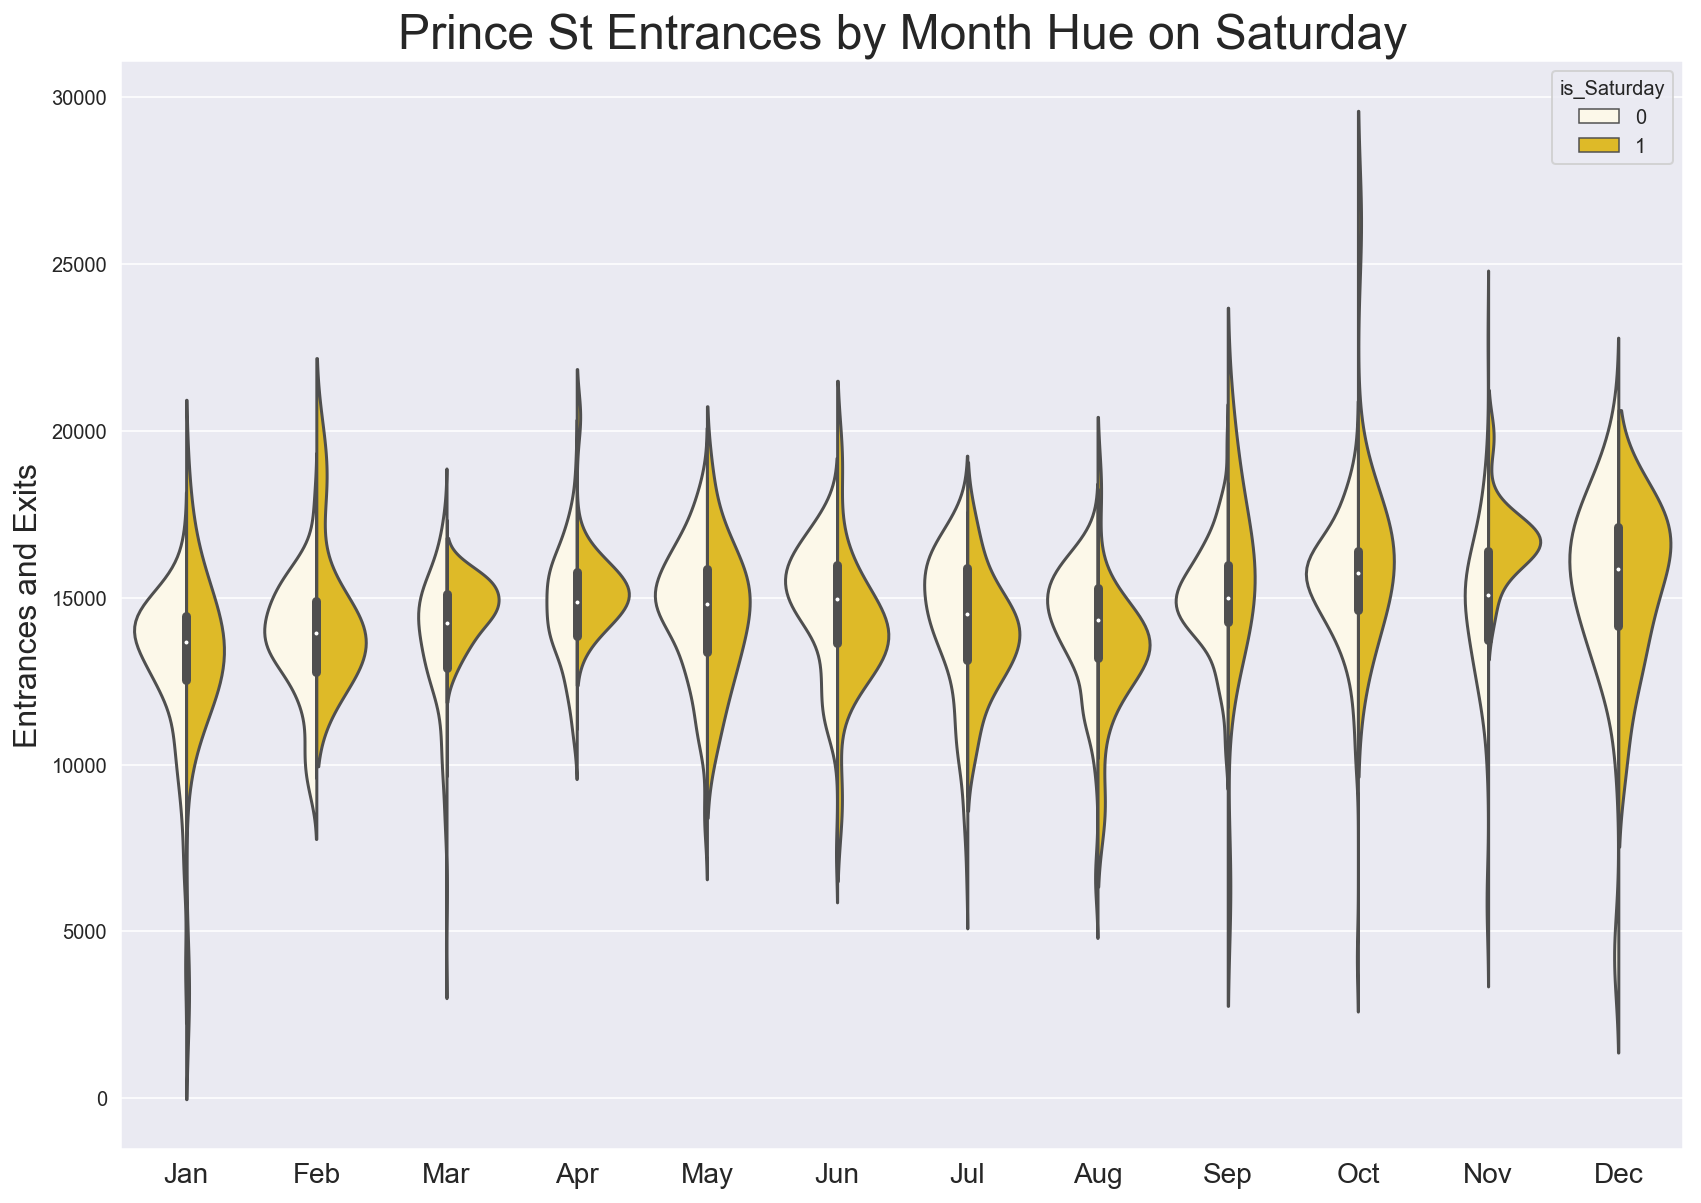

In [200]:
plt.figure(figsize=(14,10))
sns.violinplot(x=prince_daily_unclean.month, y=prince_daily_unclean.Hourly_Entries,
               hue=prince_daily_unclean.is_Saturday, split=True,
               color='#FCCC0A');
plt.title('Prince St Entrances by Month Hue on Saturday', fontsize=24);
plt.ylabel('Entrances and Exits', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14);

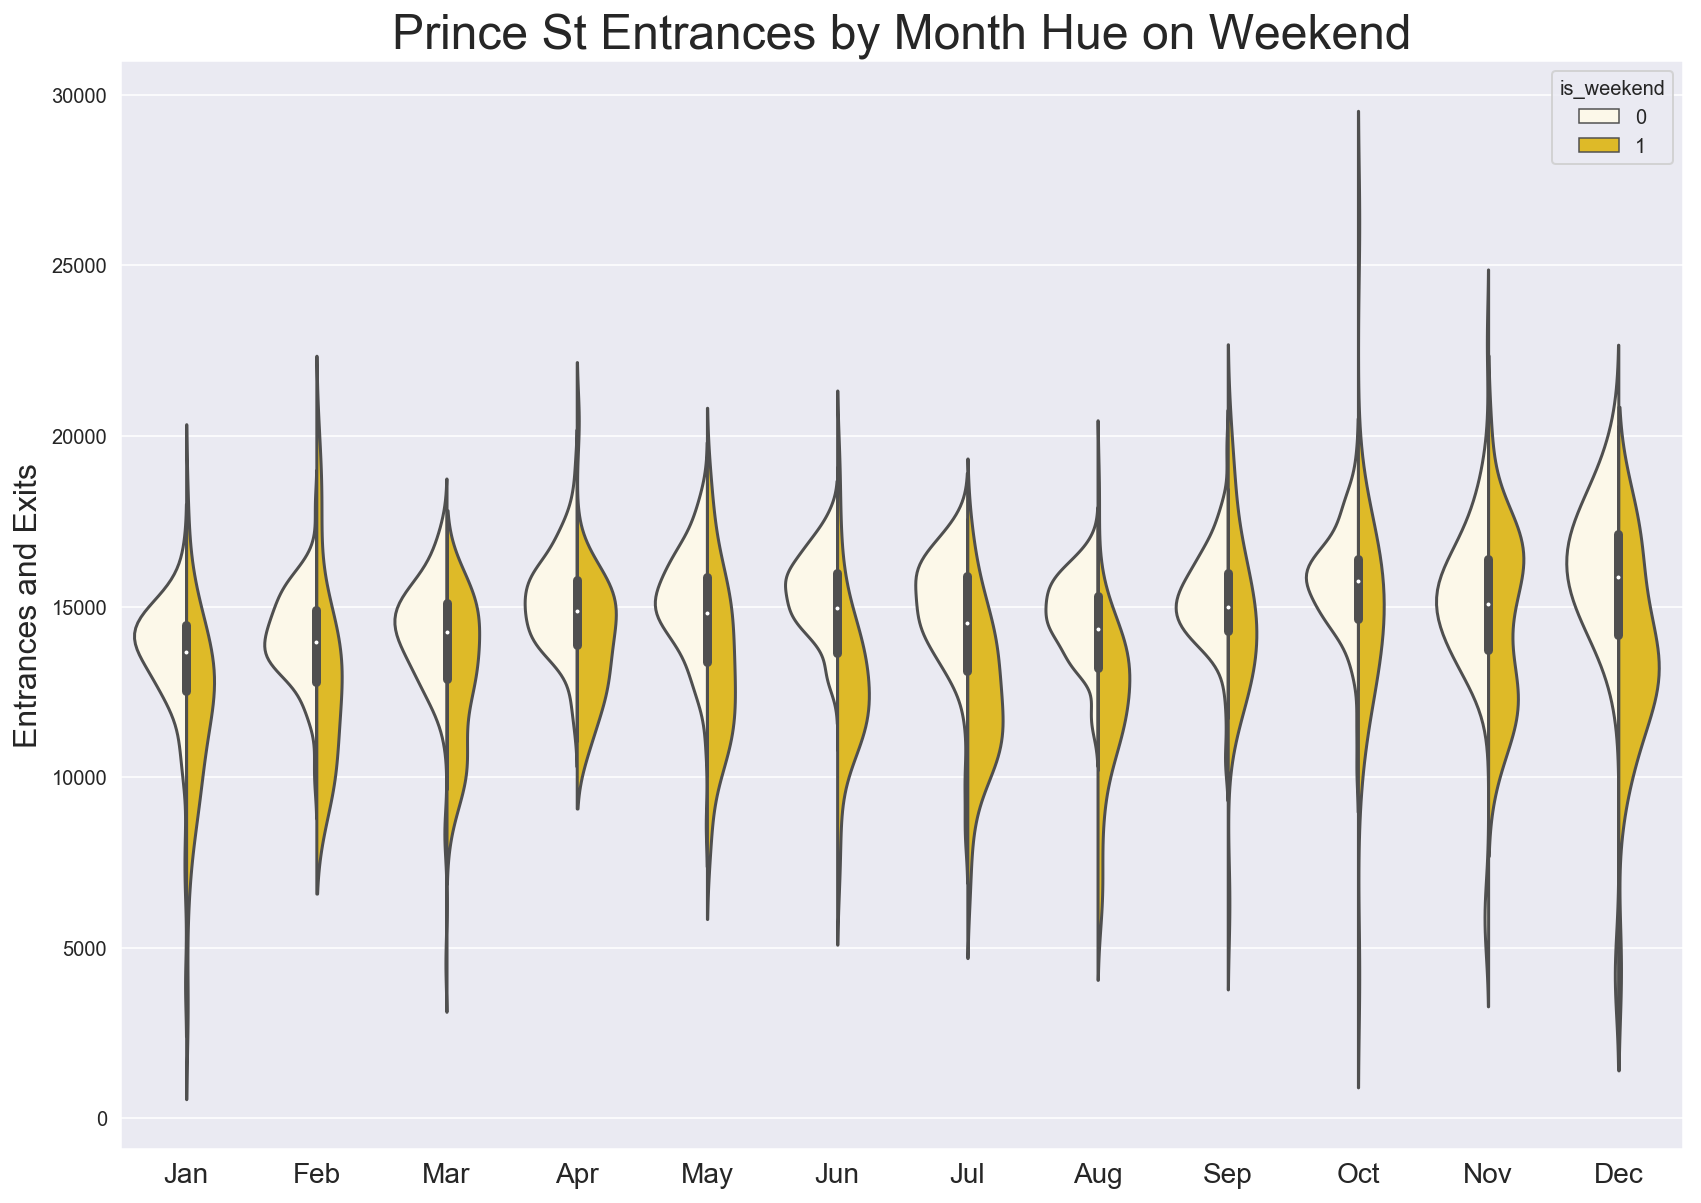

In [201]:
plt.figure(figsize=(14,10))
sns.violinplot(x=prince_daily_unclean.month, y=prince_daily_unclean.Hourly_Entries,
               hue=prince_daily_unclean.is_weekend, split=True,
               color='#FCCC0A');
plt.title('Prince St Entrances by Month Hue on Weekend', fontsize=24);
plt.ylabel('Entrances and Exits', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14);

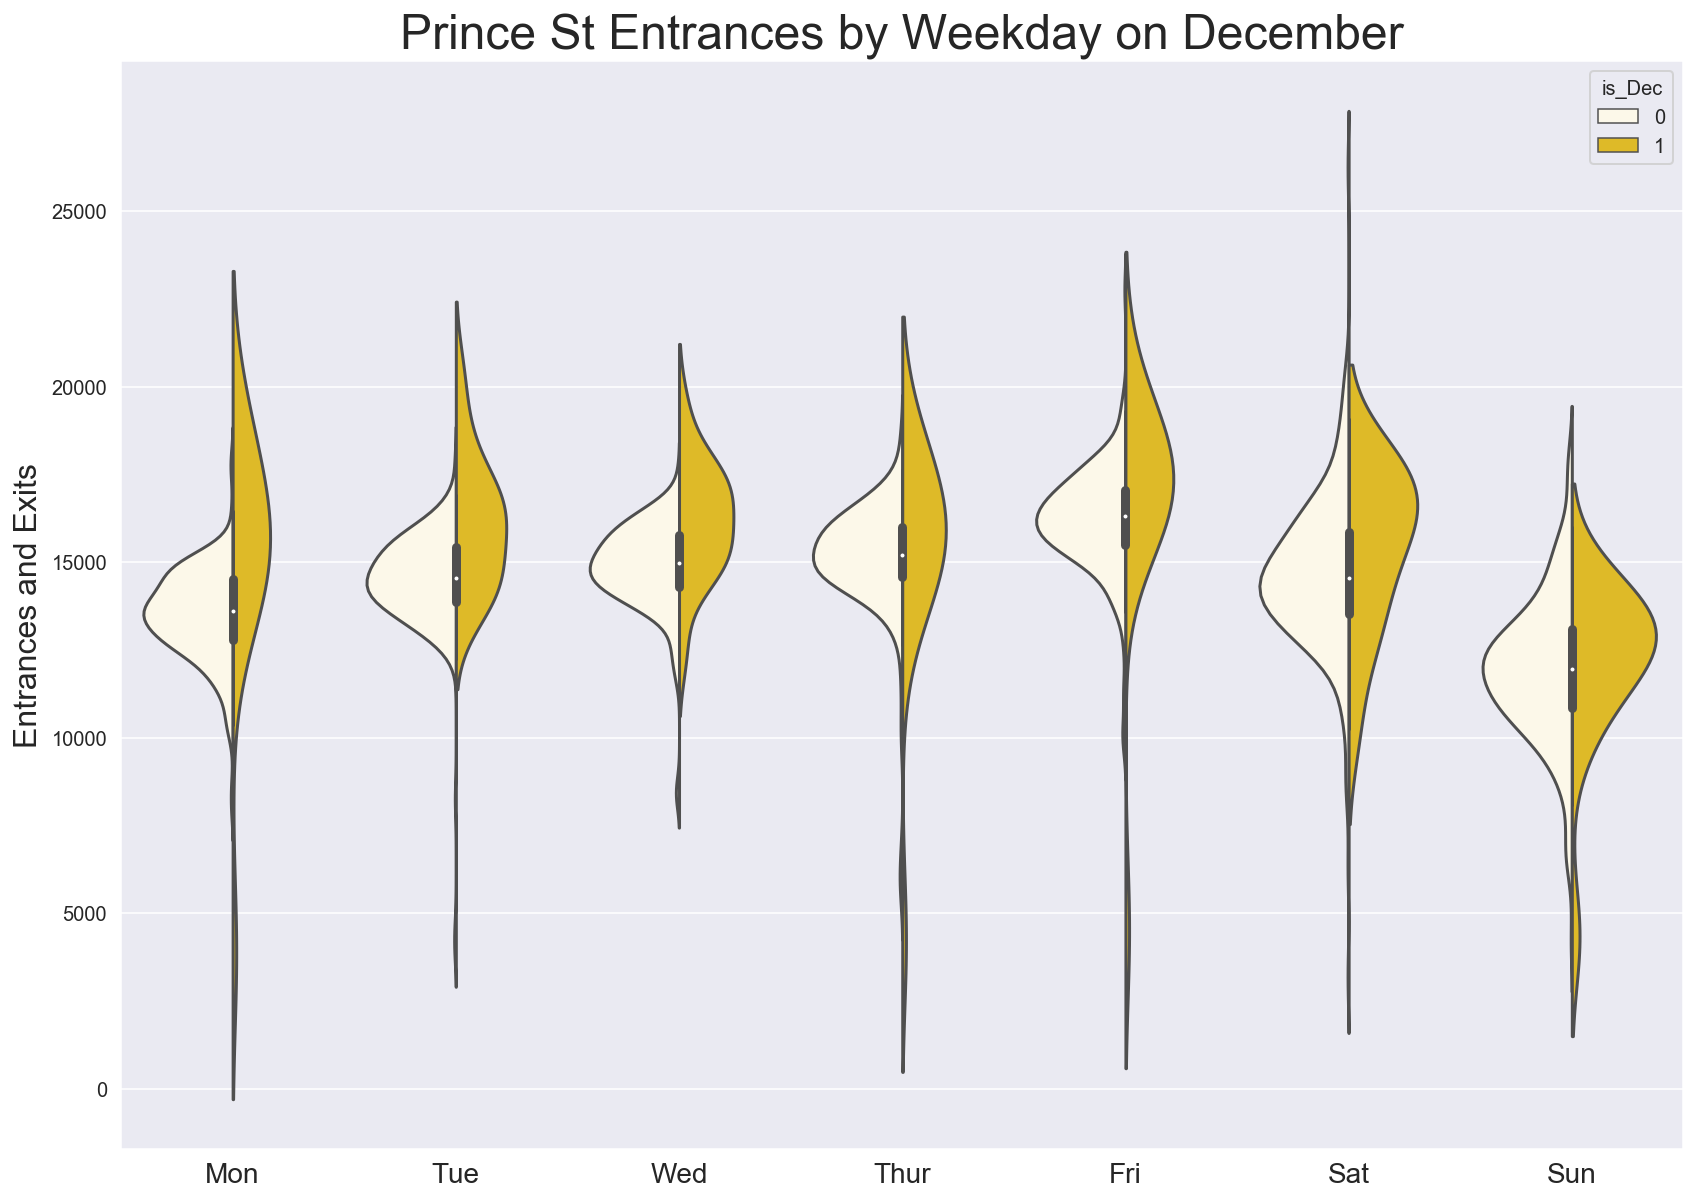

In [209]:
plt.figure(figsize=(14,10))
sns.violinplot(x=prince_daily_unclean.weekday, y=prince_daily_unclean.Hourly_Entries,
               hue=prince_daily_unclean.is_Dec, split=True,
               color='#FCCC0A');
plt.title('Prince St Entrances by Weekday on December', fontsize=24);
plt.ylabel('Entrances and Exits', fontsize=16);
plt.xlabel('', fontsize=16);
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], fontsize=14);

In [212]:
# Save the Price St data to a csv for later use
prince_daily_unclean.to_csv('prince_daily_unclean.csv', index=False)